# **Language, Computation and Cognition - FInal Project**
## **Open Ended Tasks**
### Lihi Kaspi (214676140) and Harel Oved (326042389)

In [ ]:
!pip install pyreadr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.7/411.7 kB 21.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.gam.generalized_additive_model import GLMGam
from statsmodels.gam.smooth_basis import BSplines
import pyreadr
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
import math
import string
from statsmodels.genmod.families import Gaussian
from transformers import XLMRobertaTokenizer, XLMRobertaForMaskedLM, XLMRobertaTokenizerFast
from statsmodels.nonparametric.smoothers_lowess import lowess

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Open Ended Task

## Opening MECO Files

In [ ]:
meco_wave1_path = '/content/drive/MyDrive/language_and_cognition/MECO/wave 1/primary data/eye tracking data'
meco_wave2_path = '/content/drive/MyDrive/language_and_cognition/MECO/wave 2/primary data/eye tracking data'

In [ ]:
meco_wave1_joint_l1 = pyreadr.read_r(f'{meco_wave1_path}/joint_l1_data_trimmed_version2.0.rda')
meco_wave1_readrate_l1 = pyreadr.read_r(f'{meco_wave1_path}/joint.readrate_version2.0.rda')
meco_wave1_sacc_l1 = pyreadr.read_r(f'{meco_wave1_path}/joint_sac_trimmed_l1_wave1_version2.0.rda')
meco_wave1_fix_l1 = pyreadr.read_r(f'{meco_wave1_path}/fixation report/joint_l1_fixation_version2.0.rda')
meco_wave1_passage_data = pd.read_csv(f'{meco_wave1_path}/passage_data_version2.0.csv')
meco_wave1_sentence = pd.read_csv(f'{meco_wave1_path}/sentence_data_version2.0.csv')

In [ ]:
meco_wave2_joint_l1 = pyreadr.read_r(f'{meco_wave2_path}/joint_data_trimmed_wave2_version2.0.rda')
meco_wave2_readrate_l1 = pyreadr.read_r(f'{meco_wave2_path}/joint_readrate_wave2_version2.0.rda')
meco_wave2_sacc_l1 = pyreadr.read_r(f'{meco_wave2_path}/joint_sac_trimmed_l1_wave2_version2.0.RDA')
meco_wave2_fix_l1 = pyreadr.read_r(f'{meco_wave2_path}/joint_fix_trimmed_l1_wave2_MinusCh_version2.0.RDA')
meco_wave2_passage_data = pyreadr.read_r(f'{meco_wave2_path}/joint_passage_trimmed_wave2_version2.0.rda')
meco_wave2_sentence = pyreadr.read_r(f'{meco_wave2_path}/joint_sent_trimmed_wave2_2025-01-01.rda')

## Calculating Surprisals For MECO

### Extracting dfs

In [ ]:
meco_wave1_joint_l1 = meco_wave1_joint_l1['joint.data']
meco_wave1_readrate_l1 = meco_wave1_readrate_l1['u']
meco_wave1_sacc_l1 = meco_wave1_sacc_l1['joint.sac']
meco_wave1_fix_l1 = meco_wave1_fix_l1['joint.fix']

In [ ]:
meco_wave1_joint_l1.head()

subid  trialid itemid  cond  sentnum  wordnum         word  blink  skip  \
0  du_01      1.0      1   1.0      7.0    125.0          van    0.0   0.0   
1  du_01      1.0      1   1.0      7.0    124.0        begin    0.0   0.0   
2  du_01      1.0      1   1.0      8.0    146.0  toegewezen,    0.0   0.0   
3  du_01      1.0      1   1.0      8.0    147.0         maar    1.0   0.0   
4  du_01      1.0      1   1.0      8.0    148.0           de    0.0   1.0   

   nrun  reread  nfix  refix  reg.in  reg.out    dur  firstrun.skip  \
0   1.0     0.0   1.0    0.0     0.0      0.0   93.0            1.0   
1   2.0     1.0   2.0    0.0     1.0      1.0  496.0            0.0   
2   1.0     0.0   1.0    0.0     1.0      0.0  191.0            1.0   
3   2.0     1.0   2.0    0.0     1.0      1.0  325.0            0.0   
4   NaN     NaN   NaN    NaN     NaN      NaN    NaN            1.0   

   firstrun.nfix  firstrun.refix  firstrun.reg.in  firstrun.reg.out  \
0            1.0             0.0              0.0               0.0   
1            1.0             0.0              0.0               1.0   
2            1.0             0.0              1.0               0.0   
3            1.0             0.0              0.0               1.0   
4            NaN             NaN              NaN               NaN   

   firstrun.dur  firstrun.gopast  firstrun.gopast.sel firstfix.sac.in  \
0          93.0              0.0                  0.0               5   
1         224.0            457.0                224.0              17   
2         191.0              0.0                  0.0             -10   
3         139.0            330.0                139.0             -86   
4           NaN              NaN                  NaN             NaN   

  firstfix.sac.out  firstfix.launch  firstfix.land  firstfix.cland  \
0               10              3.0            2.0             0.0   
1               -6             13.0            4.0             1.0   
2               22             -8.0            4.0            -2.0   
3              -10            -83.0            2.0            -0.5   
4              NaN              NaN            NaN             NaN   

   firstfix.dur  singlefix singlefix.sac.in singlefix.sac.out  \
0          93.0        1.0                5                10   
1         224.0        1.0               17                -6   
2         191.0        1.0              -10                22   
3         139.0        1.0              -86               -10   
4           NaN        0.0              NaN               NaN   

   singlefix.launch  singlefix.land  singlefix.cland  singlefix.dur lang  \
0               3.0             2.0              0.0           93.0   du   
1              13.0             4.0              1.0          224.0   du   
2              -8.0             4.0             -2.0          191.0   du   
3             -83.0             2.0             -0.5          139.0   du   
4               NaN             NaN              NaN            NaN   du   

   trial supplementary_id uniform_id  
0    NaN            DU_01       du_1  
1    NaN            DU_01       du_1  
2    NaN            DU_01       du_1  
3    NaN            DU_01       du_1  
4    NaN            DU_01       du_1

In [ ]:
meco_wave2_joint_l1 = meco_wave2_joint_l1['joint.data']
meco_wave2_readrate_l1 = meco_wave2_readrate_l1['read_rate']
meco_wave2_sacc_l1 = meco_wave2_sacc_l1['joint.sac']
meco_wave2_fix_l1 = meco_wave2_fix_l1['joint.fix']
meco_wave2_passage_data = meco_wave2_passage_data['joint.passage']
meco_wave2_sentence_data = meco_wave2_sentence['joint.sent']
meco_wave2_sentence_data_ch = meco_wave2_sentence['ch.sent']
meco_wave2_sentence_data_tw = meco_wave2_sentence['tw.sent']

In [ ]:
meco_wave2_joint_l1.head()

subid  trialid  trialnum itemid  cond  sentnum  wordnum         word  \
0  53_6415      1.0       1.0      0   1.0      1.0      1.0    Antzinako   
1  53_6415      1.0       1.0      0   1.0      1.0      2.0     Erromako   
2  53_6415      1.0       1.0      0   1.0      1.0      3.0      erlijio   
3  53_6415      1.0       1.0      0   1.0      1.0      4.0          eta   
4  53_6415      1.0       1.0      0   1.0      1.0      5.0  mitologian,   

   blink  skip  nrun  reread  nfix  refix  reg.in  reg.out    dur  \
0    0.0   0.0   1.0     0.0   1.0    0.0     1.0      0.0  132.0   
1    0.0   0.0   1.0     0.0   1.0    0.0     0.0      0.0  236.0   
2    0.0   0.0   1.0     0.0   1.0    0.0     0.0      0.0  208.0   
3    0.0   1.0   NaN     NaN   NaN    NaN     NaN      NaN    NaN   
4    0.0   0.0   1.0     0.0   2.0    1.0     0.0      0.0  470.0   

   firstrun.skip  firstrun.nfix  firstrun.refix  firstrun.reg.in  \
0            1.0            1.0             0.0              1.0   
1            1.0            1.0             0.0              0.0   
2            1.0            1.0             0.0              0.0   
3            1.0            NaN             NaN              NaN   
4            1.0            2.0             1.0              0.0   

   firstrun.reg.out  firstrun.dur  firstrun.gopast  firstrun.gopast.sel  \
0               0.0         132.0              0.0                  0.0   
1               0.0         236.0              0.0                  0.0   
2               0.0         208.0              0.0                  0.0   
3               NaN           NaN              NaN                  NaN   
4               0.0         470.0              0.0                  0.0   

  firstfix.sac.in firstfix.sac.out  firstfix.launch  firstfix.land  \
0               5                8             -2.0            7.0   
1               8                8              3.0            5.0   
2               8               11              4.0            4.0   
3             NaN              NaN              NaN            NaN   
4              11                5              8.0            3.0   

   firstfix.cland  firstfix.dur  singlefix singlefix.sac.in singlefix.sac.out  \
0             2.0         132.0        1.0                5                 8   
1             0.5         236.0        1.0                8                 8   
2             0.0         208.0        1.0                8                11   
3             NaN           NaN        0.0              NaN               NaN   
4            -3.0         338.0        0.0              NaN               NaN   

   singlefix.launch  singlefix.land  singlefix.cland  singlefix.dur lang  \
0              -2.0             7.0              2.0          132.0   ba   
1               3.0             5.0              0.5          236.0   ba   
2               4.0             4.0              0.0          208.0   ba   
3               NaN             NaN              NaN            NaN   ba   
4               NaN             NaN              NaN            NaN   ba   

   trial supplementary_id uniform_id  
0    NaN              NaN      ba_56  
1    NaN              NaN      ba_56  
2    NaN              NaN      ba_56  
3    NaN              NaN      ba_56  
4    NaN              NaN      ba_56

In [ ]:
meco_wave2_readrate_l1.head()

uniform_id lang  trialid   rate
0      ba_56   ba      1.0  159.0
1      ba_56   ba      2.0  129.0
2      ba_56   ba      3.0  178.0
3      ba_56   ba      4.0  114.0
4      ba_56   ba      6.0  129.0

In [ ]:
meco_wave2_sacc_l1.head()

subid  trialid  trialnum itemid  cond  sacid  msg     xs     xe     ys  \
0  53_6415      1.0       1.0      0   1.0      1  SAC  879.0  290.9  472.0   
1  53_6415      1.0       1.0      0   1.0      2  SAC  290.9  175.3  180.9   
2  53_6415      1.0       1.0      0   1.0      3  SAC  175.3  203.9  126.2   
3  53_6415      1.0       1.0      0   1.0      4  SAC  203.9  320.1   97.7   
4  53_6415      1.0       1.0      0   1.0      5  SAC  320.1  436.9   83.7   

      ye    xsn    xen    ysn    yen   start    stop   dur  lines  linee  \
0  180.9  879.0  290.9  472.0  180.9   178.0   247.0  70.0    9.0    3.0   
1  126.2  290.9  175.3  180.9  126.2   346.0   370.0  25.0    3.0    2.0   
2   97.7  175.3  203.9  126.2   97.7   603.0   624.0  22.0    2.0    1.0   
3   83.7  203.9  320.1   97.7   83.7   757.0   790.0  34.0    1.0    1.0   
4  100.3  320.1  436.9   83.7  100.3  1027.0  1052.0  26.0    1.0    1.0   

   dist.line  lets  lete  dist.let     dx     dy  dist.px  amp.px  amp.deg  \
0       -6.0  52.0  13.0     -39.0 -588.1 -291.1    656.0   707.0    13.55   
1       -1.0  13.0   6.0      -7.0 -115.6  -54.7    128.0   146.0     2.76   
2       -1.0   6.0   7.0       1.0   28.6  -28.5     40.0    55.0     0.72   
3        0.0   7.0  15.0       8.0  116.2  -14.0    117.0   146.0     1.99   
4        0.0  15.0  23.0       8.0  116.8   16.6    118.0   135.0     2.31   

     pv.px  pv.deg lang  trial supplementary_id uniform_id  
0  28108.0   585.0   ba    NaN              NaN      ba_56  
1  13545.0   230.0   ba    NaN              NaN      ba_56  
2   6794.0   109.0   ba    NaN              NaN      ba_56  
3  13526.0   234.0   ba    NaN              NaN      ba_56  
4  12185.0   213.0   ba    NaN              NaN      ba_56

In [ ]:
meco_wave2_fix_l1.head()

subid  trialid  trialnum itemid  cond  fixid  start    stop     xs  \
0  53_6415      1.0       1.0      0   1.0      1    1.0   177.0  879.0   
1  53_6415      1.0       1.0      0   1.0      2  248.0   345.0  290.9   
2  53_6415      1.0       1.0      0   1.0      3  371.0   602.0  175.3   
3  53_6415      1.0       1.0      0   1.0      4  625.0   756.0  203.9   
4  53_6415      1.0       1.0      0   1.0      5  791.0  1026.0  320.1   

      ys     xn     yn     ym    dur      ps sac.in sac.out type  blink  line  \
0  472.0  879.0  472.0  493.0  177.0  1633.0    NaN      39   in    0.0   9.0   
1  180.9  290.9  180.9  199.0   98.0  1675.0     45       7   in    0.0   3.0   
2  126.2  175.3  126.2  150.0  232.0  1575.0     11      -1   in    0.0   2.0   
3   97.7  203.9   97.7  101.0  132.0  1372.0      5       8   in    0.0   1.0   
4   83.7  320.1   83.7  101.0  236.0  1304.0      8       8   in    0.0   1.0   

   line.change  line.let  line.word letternum letter  wordnum          word  \
0          0.0      52.0        7.0       941      e    128.0    greziarrek   
1         -6.0      13.0        2.0       237      u     33.0         ditu,   
2         -1.0       6.0        2.0       117      r     19.0  aurpegirekin   
3         -1.0       7.0        1.0         7      a      1.0     Antzinako   
4          0.0      15.0        2.0        15      m      2.0      Erromako   

   ianum            ia  sentnum                  sent  sent.nwords  \
0  128.0    greziarrek     10.0  Antzinako greziarrek         13.0   
1   33.0         ditu,      3.0  Janok gatazkaren has         12.0   
2   19.0  aurpegirekin      2.0  Izaera bikoitza du e         15.0   
3    1.0     Antzinako      1.0  Antzinako Erromako e         11.0   
4    2.0      Erromako      1.0  Antzinako Erromako e         11.0   

                                      trial.x trial.nwords  word.fix  \
0  Antzinako Erromako erlijio eta mitologian,          139       1.0   
1  Antzinako Erromako erlijio eta mitologian,          139       1.0   
2  Antzinako Erromako erlijio eta mitologian,          139       1.0   
3  Antzinako Erromako erlijio eta mitologian,          139       1.0   
4  Antzinako Erromako erlijio eta mitologian,          139       1.0   

   word.run  word.runid  word.run.fix  word.firstskip  word.refix  \
0       1.0         1.0           1.0             0.0         0.0   
1       1.0         2.0           1.0             1.0         0.0   
2       1.0         2.0           1.0             1.0         0.0   
3       1.0         2.0           1.0             1.0         0.0   
4       1.0         2.0           1.0             1.0         0.0   

   word.launch  word.land  word.cland  word.reg.out  word.reg.in  \
0          NaN        3.0        -2.5           1.0          0.0   
1         41.0        4.0         1.0           1.0          1.0   
2          8.0        3.0        -3.5           1.0          1.0   
3         -2.0        7.0         2.0           0.0          1.0   
4          3.0        5.0         0.5           0.0          0.0   

   word.reg.out.to  word.reg.in.from  ia.fix  ia.run  ia.runid  ia.run.fix  \
0             33.0               NaN     1.0     1.0       1.0         1.0   
1             19.0             128.0     1.0     1.0       2.0         1.0   
2              1.0              33.0     1.0     1.0       2.0         1.0   
3              NaN              19.0     1.0     1.0       2.0         1.0   
4              NaN               NaN     1.0     1.0       2.0         1.0   

   ia.firstskip  ia.refix  ia.launch  ia.land  ia.cland  ia.reg.out  \
0           0.0       0.0        NaN      4.0      -1.5         1.0   
1           1.0       0.0       40.0      5.0       2.0         1.0   
2           1.0       0.0        7.0      4.0      -2.5         1.0   
3           1.0       0.0       -2.0      7.0       2.0         0.0   
4           1.0       0.0        2.0      6.0       1.5         0.0   

   ia.reg.in  ia.r

In [ ]:
meco_wave2_passage_data.head()

subid  trialid  trialnum itemid  cond  \
0  53_6415      1.0       1.0      0   1.0   
1  53_6415      2.0       2.0      1   1.0   
2  53_6415      3.0       3.0      2   1.0   
3  53_6415      4.0       4.0      3   1.0   
4  53_6415      6.0       6.0      5   1.0   

                                               trial  trial.nwords  nblink  \
0         Antzinako Erromako erlijio eta mitologian,           139    20.0   
1                    Shaka Hawaiiko kultura eta surf           154    22.0   
2       Kirol lehiakorretan kirolariek hartzen duten           162    16.0   
3  Thylacinus cynocephalus, euskaraz Tasmaniako t...           140    22.0   
4           Monokuloa begi baten ikusmena zuzentzeko           125    20.0   

   nrun   nfix  nout    sac   skip  refix    reg   mfix  firstpass  rereading  \
0  28.0  243.0     0  7.219  0.928  0.365  0.270  216.0    35064.0    17451.0   
1  40.0  335.0     0  7.508  0.448  0.393  0.300  214.0    41753.0    29999.0   
2  25.0  254.0     0  7.573  0.438  0.352  0.172  215.0    42846.0    11716.0   
3  46.0  344.0     0  8.101  0.793  0.437  0.349  213.0    36183.0    37232.0   
4  33.0  272.0     0  7.202  0.216  0.407  0.306  213.0    32874.0    25055.0   

     total   rate lang supplementary_id uniform_id  
0  52515.0  159.0   ba              NaN      ba_56  
1  71752.0  129.0   ba              NaN      ba_56  
2  54562.0  178.0   ba              NaN      ba_56  
3  73415.0  114.0   ba              NaN      ba_56  
4  57929.0  129.0   ba              NaN      ba_56

In [ ]:
meco_wave2_sentence_data.head()

subid  trialid  trialnum itemid  cond  sentnum                  sent  \
0  53_6415      1.0       1.0      0   1.0      1.0  Antzinako Erromako e   
1  53_6415      1.0       1.0      0   1.0      2.0  Izaera bikoitza du e   
2  53_6415      1.0       1.0      0   1.0      3.0  Janok gatazkaren has   
3  53_6415      1.0       1.0      0   1.0      4.0  Bere tenpluko ateak    
4  53_6415      1.0       1.0      0   1.0      5.0  Ateen jainko bezala,   

   sent.nwords  skip  nrun  reread  reg.in  reg.out  total.nfix  total.dur  \
0         11.0   0.0   2.0     1.0     1.0      1.0        14.0     2935.0   
1         15.0   0.0   2.0     1.0     1.0      1.0        20.0     4276.0   
2         12.0   0.0   2.0     1.0     1.0      1.0        17.0     3153.0   
3         11.0   0.0   4.0     1.0     1.0      1.0        26.0     5628.0   
4         11.0   0.0   3.0     1.0     1.0      1.0        26.0     5951.0   

    rate  gopast  gopast.sel  firstrun.skip  firstrun.reg.in  \
0  225.0     0.0         0.0            1.0              1.0   
1  210.0     0.0         0.0            1.0              1.0   
2  228.0     0.0         0.0            1.0              1.0   
3  117.0     0.0         0.0            1.0              1.0   
4  111.0     0.0         0.0            1.0              1.0   

   firstrun.reg.out  firstpass.nfix  firstpass.dur  firstpass.forward.nfix  \
0               1.0            11.0         2480.0                     0.0   
1               1.0            18.0         3878.0                     5.0   
2               1.0            15.0         2775.0                     5.0   
3               0.0            15.0         3252.0                     5.0   
4               1.0            26.0         5951.0                     6.0   

   firstpass.forward.dur  firstpass.reread.nfix  firstpass.reread.dur  \
0                    0.0                   11.0                2480.0   
1                 1139.0                   13.0                2739.0   
2                 1219.0                   10.0                1556.0   
3                 1148.0                   10.0                2104.0   
4                 1535.0                   20.0                4416.0   

   lookback.nfix  lookback.dur  lookfrom.nfix  lookfrom.dur lang  \
0            3.0         455.0            0.0           0.0   ba   
1            2.0         398.0           14.0        2935.0   ba   
2            2.0         378.0            2.0         398.0   ba   
3           11.0        2376.0            0.0           0.0   ba   
4            0.0           0.0           11.0        2376.0   ba   

  supplementary_id uniform_id  
0              NaN      ba_56  
1              NaN      ba_56  
2              NaN      ba_56  
3              NaN      ba_56  
4              NaN      ba_56

### Extracting Sentences And Calculating Surprisals

In [ ]:
wave1_sentences = meco_wave1_joint_l1[['lang', 'trialid', 'wordnum', 'word']].drop_duplicates()
wave2_sentences = meco_wave2_joint_l1[['lang', 'trialid', 'wordnum', 'word']].drop_duplicates()

In [ ]:
wave1_sentences.head(10)

lang  trialid  wordnum          word
0   du      1.0    125.0           van
1   du      1.0    124.0         begin
2   du      1.0    146.0   toegewezen,
3   du      1.0    147.0          maar
4   du      1.0    148.0            de
5   du      1.0    149.0  hogepriester
6   du      1.0    150.0          zelf
7   du      1.0    151.0        voerde
8   du      1.0    152.0          zijn
9   du      1.0    153.0    ceremonies

In [ ]:
wave2_sentences.head(10)

lang  trialid  wordnum         word
0   ba      1.0      1.0    Antzinako
1   ba      1.0      2.0     Erromako
2   ba      1.0      3.0      erlijio
3   ba      1.0      4.0          eta
4   ba      1.0      5.0  mitologian,
5   ba      1.0      6.0         Jano
6   ba      1.0      7.0     hasieren
7   ba      1.0      8.0          eta
8   ba      1.0      9.0        ateen
9   ba      1.0     10.0      jainkoa

In [ ]:
wave1_sentences['sentence'] = wave1_sentences.sort_values(['lang','trialid','wordnum']).groupby(['lang','trialid'])['word'].transform(lambda x: ' '.join(x))
wave2_sentences['sentence'] = wave2_sentences.sort_values(['lang','trialid','wordnum']).groupby(['lang','trialid'])['word'].transform(lambda x: ' '.join(x))

In [ ]:
wave1_sentences = wave1_sentences[['lang', 'trialid', 'sentence']].drop_duplicates()
wave2_sentences = wave2_sentences[['lang', 'trialid', 'sentence']].drop_duplicates()

In [ ]:
wave1_sentences

lang  trialid                                           sentence
0        du      1.0  Janus is in de oude Romeinse religie en mythes...
101      du      2.0  Het shaka- teken, ook bekend als ‘laat het los...
116      du      3.0  Doping is het gebruik van verboden prestatiebe...
465      du      4.0  De buidelwolf was een van de grotere vleeseten...
507      du      5.0  De wereldmilieudag wordt sinds 1974 jaarlijks ...
...     ...      ...                                                ...
824620   tr     10.0  Bayrak belli bir ülkenin, topluluğun ya da bir...
824747   tr     11.0  Dünya Doğa ve Doğal Kaynakları Koruma Birliği ...
825767   tr      7.0  Şarap tadımı, şarabın duyumsal olarak incelenm...
825917   tr      8.0  Nar ekşisi, nar suyunun içindeki şekerin karam...
826458   tr     12.0  Taşıt kayıt plakası, resmi tanımlama amacıyla ...

[156 rows x 3 columns]

In [ ]:
wave2_sentences

lang  trialid                                           sentence
0          ba      1.0  Antzinako Erromako erlijio eta mitologian, Jan...
139        ba      2.0  Shaka Hawaiiko kultura eta surf kirolarekin lo...
293        ba      3.0  Kirol lehiakorretan kirolariek hartzen duten d...
455        ba      4.0  Thylacinus cynocephalus, euskaraz Tasmaniako t...
595        ba      6.0  Monokuloa begi baten ikusmena zuzentzeko leiar...
...       ...      ...                                                ...
896457  en_uk      8.0  Orange juice is a liquid extract of the orange...
896593  en_uk      9.0  Beekeeping A is national the flag maintenance ...
896793  en_uk     10.0  A The national International flag Union is for...
896973  en_uk     11.0  The A International vehicle Union registration...
897149  en_uk     12.0  A vehicle registration plate is a metal or pla...

[192 rows x 3 columns]

In [ ]:
def get_words_with_offsets(paragraph):
    words = []
    offset = 0
    for w in paragraph.split():
        start = paragraph.find(w, offset)
        end = start + len(w)
        words.append((w, start, end))
        offset = end
    return words

In [ ]:
def compute_xlm_surprisal_per_word(paragraph):
    words_with_offsets = get_words_with_offsets(paragraph)
    word_surprisals = []

    # Truncate paragraph if longer than max model length
    max_len = tokenizer.model_max_length - 2 # account for special tokens
    if len(paragraph) > max_len:
      paragraph = paragraph[:max_len]

    for word, start, end in words_with_offsets:
        # Ensure word is within truncated paragraph bounds
        if start >= len(paragraph):
          continue

        # Mask the word in the paragraph
        masked_paragraph = paragraph[:start] + tokenizer.mask_token + paragraph[end:]

        # Tokenize
        encoding = tokenizer(masked_paragraph, return_tensors="pt", return_offsets_mapping=True, truncation=True)
        input_ids = encoding["input_ids"].to(device)
        offset_mapping = encoding["offset_mapping"][0]

        # Find the masked token index
        mask_index = (input_ids == tokenizer.mask_token_id).nonzero(as_tuple=True)[1].item()

        with torch.no_grad():
            outputs = model(input_ids)
            logits = outputs.logits
            log_probs = torch.log_softmax(logits, dim=-1)

        # Encode the target word
        target_token_ids = tokenizer.encode(word, add_special_tokens=False)

        # Only calculate surprisal if word maps to a single token
        if len(target_token_ids) == 1:
            token_id = target_token_ids[0]
            log_prob = log_probs[0, mask_index, token_id]
            surprisal = -log_prob.item() / math.log(2)  # log base 2
            word_surprisals.append((word, surprisal))
        else:
            word_surprisals.append((word, None))  # skip multi-token words

    return word_surprisals

In [ ]:
wave1_sentences['XLM_surprisal'] = wave1_sentences['sentence'].apply(compute_xlm_surprisal_per_word)
wave2_sentences['XLM_surprisal'] = wave2_sentences['sentence'].apply(compute_xlm_surprisal_per_word)

In [ ]:
wave1_sentences = wave1_sentences.explode('XLM_surprisal', ignore_index=True)
wave1_sentences[['word', 'surprisal']] = pd.DataFrame(wave1_sentences['XLM_surprisal'].tolist(), index=wave1_sentences.index)
wave1_sentences['wordnum'] = wave1_sentences.groupby('sentence').cumcount() + 1
wave1_sentences.head(10)

lang  trialid                                           sentence  \
0   du      1.0  Janus is in de oude Romeinse religie en mythes...   
1   du      1.0  Janus is in de oude Romeinse religie en mythes...   
2   du      1.0  Janus is in de oude Romeinse religie en mythes...   
3   du      1.0  Janus is in de oude Romeinse religie en mythes...   
4   du      1.0  Janus is in de oude Romeinse religie en mythes...   
5   du      1.0  Janus is in de oude Romeinse religie en mythes...   
6   du      1.0  Janus is in de oude Romeinse religie en mythes...   
7   du      1.0  Janus is in de oude Romeinse religie en mythes...   
8   du      1.0  Janus is in de oude Romeinse religie en mythes...   
9   du      1.0  Janus is in de oude Romeinse religie en mythes...   

                XLM_surprisal      word  surprisal  wordnum  
0               (Janus, None)     Janus        NaN        1  
1    (is, 1.7025544629845855)        is   1.702554        2  
2    (in, 1.8399085790788183)        in   1.839909        3  
3  (de, 0.017498284789867653)        de   0.017498        4  
4  (oude, 1.1434314697756074)      oude   1.143431        5  
5            (Romeinse, None)  Romeinse        NaN        6  
6             (religie, None)   religie        NaN        7  
7     (en, 3.418662190753065)        en   3.418662        8  
8              (mythes, None)    mythes        NaN        9  
9    (de, 0.3935344853225977)        de   0.393534       10

In [ ]:
wave2_sentences = wave2_sentences.explode('XLM_surprisal', ignore_index=True)
wave2_sentences[['word', 'surprisal']] = pd.DataFrame(wave2_sentences['XLM_surprisal'].tolist(), index=wave2_sentences.index)
wave2_sentences['wordnum'] = wave2_sentences.groupby('sentence').cumcount() + 1
wave2_sentences.head(10)

lang  trialid                                           sentence  \
0   ba      1.0  Antzinako Erromako erlijio eta mitologian, Jan...   
1   ba      1.0  Antzinako Erromako erlijio eta mitologian, Jan...   
2   ba      1.0  Antzinako Erromako erlijio eta mitologian, Jan...   
3   ba      1.0  Antzinako Erromako erlijio eta mitologian, Jan...   
4   ba      1.0  Antzinako Erromako erlijio eta mitologian, Jan...   
5   ba      1.0  Antzinako Erromako erlijio eta mitologian, Jan...   
6   ba      1.0  Antzinako Erromako erlijio eta mitologian, Jan...   
7   ba      1.0  Antzinako Erromako erlijio eta mitologian, Jan...   
8   ba      1.0  Antzinako Erromako erlijio eta mitologian, Jan...   
9   ba      1.0  Antzinako Erromako erlijio eta mitologian, Jan...   

              XLM_surprisal         word  surprisal  wordnum  
0         (Antzinako, None)    Antzinako        NaN        1  
1          (Erromako, None)     Erromako        NaN        2  
2           (erlijio, None)      erlijio        NaN        3  
3  (eta, 1.666034978969773)          eta   1.666035        4  
4       (mitologian,, None)  mitologian,        NaN        5  
5              (Jano, None)         Jano        NaN        6  
6          (hasieren, None)     hasieren        NaN        7  
7  (eta, 3.029606477624237)          eta   3.029606        8  
8             (ateen, None)        ateen        NaN        9  
9           (jainkoa, None)      jainkoa        NaN       10

In [ ]:
wave1_sentences = wave1_sentences[['lang', 'trialid', 'word', 'surprisal', 'wordnum']]
wave2_sentences = wave2_sentences[['lang', 'trialid', 'word', 'surprisal', 'wordnum']]

In [ ]:
meco_wave1_joint_l1 = meco_wave1_joint_l1.merge(wave1_sentences, on=['lang', 'trialid', 'word', 'wordnum'], how='inner')
meco_wave2_joint_l1 = meco_wave2_joint_l1.merge(wave2_sentences, on=['lang', 'trialid', 'word', 'wordnum'], how='inner')

In [ ]:
meco_wave1_joint_l1.to_csv("/content/drive/MyDrive/language_and_cognition/MECO/wave1_surprisals.csv")
meco_wave2_joint_l1.to_csv("/content/drive/MyDrive/language_and_cognition/MECO/wave2_surprisals.csv")

## Data Preparation

In [ ]:
wave1_surprisals = pd.read_csv("/content/drive/MyDrive/language_and_cognition/MECO/wave1_surprisals.csv")
wave2_surprisals = pd.read_csv("/content/drive/MyDrive/language_and_cognition/MECO/wave2_surprisals.csv")

In [ ]:
wave1_surprisals.columns

Index(['Unnamed: 0', 'subid', 'trialid', 'itemid', 'cond', 'sentnum',
       'wordnum', 'word', 'blink', 'skip', 'nrun', 'reread', 'nfix', 'refix',
       'reg.in', 'reg.out', 'dur', 'firstrun.skip', 'firstrun.nfix',
       'firstrun.refix', 'firstrun.reg.in', 'firstrun.reg.out', 'firstrun.dur',
       'firstrun.gopast', 'firstrun.gopast.sel', 'firstfix.sac.in',
       'firstfix.sac.out', 'firstfix.launch', 'firstfix.land',
       'firstfix.cland', 'firstfix.dur', 'singlefix', 'singlefix.sac.in',
       'singlefix.sac.out', 'singlefix.launch', 'singlefix.land',
       'singlefix.cland', 'singlefix.dur', 'lang', 'trial', 'supplementary_id',
       'uniform_id', 'surprisal'],
      dtype='object')

In [ ]:
wave1_surprisals

Unnamed: 0  subid  trialid  itemid  cond  sentnum  wordnum  \
0                0  du_01      1.0       1   1.0      4.0     65.0   
1                1  du_01      1.0       1   1.0      4.0     66.0   
2                2  du_01      1.0       1   1.0      4.0     67.0   
3                3  du_01      1.0       1   1.0      4.0     68.0   
4                4  du_01      1.0       1   1.0      4.0     69.0   
...            ...    ...      ...     ...   ...      ...      ...   
352801      352801  tr_52     10.0      10   1.0      2.0     36.0   
352802      352802  tr_52     10.0      10   1.0      3.0     37.0   
352803      352803  tr_52     10.0      10   1.0      3.0     38.0   
352804      352804  tr_52     10.0      10   1.0      3.0     39.0   
352805      352805  tr_52     10.0      10   1.0      3.0     40.0   

              word  blink  skip  nrun  reread  nfix  refix  reg.in  reg.out  \
0           oorlog    0.0   0.0   1.0     0.0   1.0    0.0     0.0      0.0   
1               en    0.0   1.0   NaN     NaN   NaN    NaN     NaN      NaN   
2         gesloten    0.0   0.0   1.0     0.0   1.0    0.0     0.0      0.0   
3               in    0.0   1.0   NaN     NaN   NaN    NaN     NaN      NaN   
4           tijden    0.0   0.0   1.0     0.0   1.0    0.0     0.0      0.0   
...            ...    ...   ...   ...     ...   ...    ...     ...      ...   
352801     vardır.    1.0   0.0   1.0     0.0   1.0    0.0     0.0      0.0   
352802      Birkaç    1.0   0.0   1.0     0.0   1.0    0.0     0.0      0.0   
352803     istisna    0.0   0.0   1.0     0.0   1.0    0.0     0.0      0.0   
352804     dışında    0.0   0.0   1.0     0.0   1.0    0.0     0.0      0.0   
352805  genellikle    0.0   0.0   1.0     0.0   2.0    1.0     0.0      0.0   

          dur  firstrun.skip  firstrun.nfix  firstrun.refix  firstrun.reg.in  \
0       242.0            0.0            1.0             0.0              0.0   
1         NaN            1.0            NaN             NaN              NaN   
2       215.0            0.0            1.0             0.0              0.0   
3         NaN            1.0            NaN             NaN              NaN   
4       197.0            0.0            1.0             0.0              0.0   
...       ...            ...            ...             ...              ...   
352801  129.0            0.0            1.0             0.0              0.0   
352802  162.0            0.0            1.0             0.0              0.0   
352803  294.0            0.0            1.0             0.0              0.0   
352804  214.0            0.0            1.0             0.0              0.0   
352805  382.0            0.0            2.0             1.0              0.0   

        firstrun.reg.out  firstrun.dur  firstrun.gopast  firstrun.gopast.sel  \
0                    0.0         242.0            242.0                242.0   
1                    NaN           NaN              NaN                  NaN   
2                    0.0         215.0            215.0                215.0   
3                    NaN           NaN              NaN                  NaN   
4                    0.0         197.0            197.0                197.0   
...                  ...           ...              ...                  ...   
352801               0.0         129.0            129.0                129.0   
352802               0.0         162.0            162.0                162.0   
352803               0.0         294.0            294.0                294.0   
352804               0.0         214.0            214.0                214.0   
352805               0.0         382.0            382.0                382.0   

        firstfix.sac.in  firstfix.sac.out  firstfix.launch  firstfix.land  \
0                  11.0               7.0              5.0            6.0   
1                   NaN               NaN              NaN            NaN   
2                   7.0              14.0              4.0       

### Prepare the Date

In [ ]:
eye_measures_cols = ['dur', 'nrun', 'nfix', 'firstrun.nfix', 'firstrun.dur',
                     'firstrun.gopast', 'firstrun.gopast.sel', 'firstfix.sac.in',
                     'firstfix.sac.out', 'firstfix.dur']

In [ ]:
wave1_languages = wave1_surprisals["lang"].unique()
wave2_languages = wave2_surprisals["lang"].unique()

In [ ]:
languages = {
    # wave 1
    'du': 'Dutch',
    'ee': 'Estonian',
    'fi': 'Finnish',
    'ge': 'German',
    'gr': 'Greek',
    'he': 'Hebrew',
    'it': 'Italian',
    'ko': 'Korean',
    'en': 'English (Canada)',
    'no': 'Norwegian', # both waves
    'ru': 'Russian', # both waves
    'sp': 'Spanish (Argentina)',
    'tr': 'Turkish',

    # wave 2
    'ba': 'Basque',
    'bp': 'Portuguese (Brazil)',
    'ch_s': 'Chinese (Simplified)',
    'sp_ch': 'Spanish (Chile)',
    'da': 'Danish',
    'ge_po': 'German (Poland)',
    'ge_zu': 'German (Switzerland)',
    'hi_iiith': 'Hindi (IIIT Hyderabad)',
    'hi_iitk': 'Hindi (IIT Kanpur)',
    'ic': 'Icelandic',
    'ru_mo': 'Russian',
    'se': 'Serbian',
    'ch_t': 'Chinese (Traditional)',
    'en_uk': 'English (United Kindom)'
}

In [ ]:
language_families = {
    # wave 1
    'du': 'Germanic',
    'ee': 'Uralic',
    'fi': 'Uralic',
    'ge': 'Germanic',
    'gr': 'Indo-European (Hellenic)',
    'he': 'Afro-Asiatic (Semitic)',
    'it': 'Indo-European (Romance)',
    'ko': 'Koreanic',
    'en': 'Germanic',
    'no': 'Germanic',
    'ru': 'Indo-European (Slavic)',
    'sp': 'Indo-European (Romance)',
    'tr': 'Turkic',

    # wave 2
    'ba': 'Language isolate',
    'bp': 'Indo-European (Romance)',
    'ch_s': 'Sino-Tibetan',
    'sp_ch': 'Indo-European (Romance)',
    'da': 'Germanic',
    'ge_po': 'Germanic',
    'ge_zu': 'Germanic',
    'hi_iiith': 'Indo-European (Indo-Aryan)',
    'hi_iitk': 'Indo-European (Indo-Aryan)',
    'ic': 'Germanic',
    'ru_mo': 'Indo-European (Slavic)',
    'se': 'Indo-European (Slavic)',
    'ch_t': 'Sino-Tibetan',
    'en_uk': 'Germanic'
}

In [ ]:
language_scripts = {
    # wave 1
    'du': 'Latin',           # Dutch
    'ee': 'Latin',           # Estonian
    'fi': 'Latin',           # Finnish
    'ge': 'Latin',           # German
    'gr': 'Greek',           # Greek
    'he': 'Hebrew',          # Hebrew
    'it': 'Latin',           # Italian
    'ko': 'Hangul',          # Korean
    'en': 'Latin',           # English (Canada)
    'no': 'Latin',           # Norwegian
    'ru': 'Cyrillic',        # Russian
    'sp': 'Latin',           # Spanish (Argentina)
    'tr': 'Latin',           # Turkish

    # wave 2
    'ba': 'Latin',           # Basque
    'bp': 'Latin',           # Portuguese (Brazil)
    'ch_s': 'Simplified Chinese', # Chinese (Simplified)
    'sp_ch': 'Latin',        # Spanish (Chile)
    'da': 'Latin',           # Danish
    'ge_po': 'Latin',        # German (Poland)
    'ge_zu': 'Latin',        # German (Switzerland)
    'hi_iiith': 'Devanagari',# Hindi (IIIT Hyderabad)
    'hi_iitk': 'Devanagari', # Hindi (IIT Kanpur)
    'ic': 'Latin',           # Icelandic
    'ru_mo': 'Cyrillic',     # Russian (Moscow)
    'se': 'Cyrillic',        # Serbian
    'ch_t': 'Traditional Chinese', # Chinese (Traditional)
    'en_uk': 'Latin'         # English (United Kingdom)
}

In [ ]:
language_orthographic_depth = {
    # wave 1
    'du': 'Shallow',         # Dutch (relatively regular spelling, though slightly deeper than Spanish)
    'ee': 'Shallow',         # Estonian
    'fi': 'Very shallow',    # Finnish (extremely regular spelling)
    'ge': 'Shallow',         # German (fairly regular rules, but with some inconsistencies)
    'gr': 'Shallow',         # Greek (regular spelling rules)
    'he': 'Deep',            # Hebrew (vowel omission in writing makes decoding harder)
    'it': 'Shallow',         # Italian
    'ko': 'Shallow',         # Korean Hangul is highly phonemic
    'en': 'Deep',            # English (Canada) — highly irregular spelling
    'no': 'Shallow',         # Norwegian (regular spelling rules)
    'ru': 'Shallow',         # Russian (fairly phonemic)
    'sp': 'Very shallow',    # Spanish (Argentina)
    'tr': 'Very shallow',    # Turkish

    # wave 2
    'ba': 'Shallow',         # Basque
    'bp': 'Very shallow',    # Portuguese (Brazil) — shallower than European Portuguese
    'ch_s': 'Morphosyllabic',# Chinese Simplified — logographic, not alphabetic
    'sp_ch': 'Very shallow', # Spanish (Chile)
    'da': 'Shallow',         # Danish spelling is *less* transparent than other Scandinavians, borderline deep
    'ge_po': 'Shallow',      # German (Poland)
    'ge_zu': 'Shallow',      # German (Switzerland)
    'hi_iiith': 'Shallow',   # Hindi (Devanagari is phonemic)
    'hi_iitk': 'Shallow',    # Hindi (Devanagari)
    'ic': 'Shallow',         # Icelandic — morphophonemic, slightly deeper than Norwegian
    'ru_mo': 'Shallow',      # Russian
    'se': 'Shallow',         # Serbian (Cyrillic, highly phonemic)
    'ch_t': 'Morphosyllabic',# Chinese Traditional
    'en_uk': 'Deep'          # English (UK)
}

In [ ]:
wave1_dict = {}
for lang in wave1_languages:
  wave1_dict[lang] = wave1_surprisals[wave1_surprisals["lang"] == lang]

wave2_dict = {}
for lang in wave2_languages:
  wave2_dict[lang] = wave2_surprisals[wave2_surprisals["lang"] == lang]

### OLS

In [ ]:
wave1_OLS = {}
wave2_OLS = {}

In [ ]:
for lang in wave1_languages:
  wave1_OLS[lang] = {}
  for measure in eye_measures_cols:
    x = np.array(wave1_dict[lang][measure])
    y = np.array(wave1_dict[lang]['surprisal'])

    valid_mask = np.isfinite(x) & np.isfinite(y)
    x_clean = x[valid_mask]
    y_clean = y[valid_mask]

    model = sm.OLS(y_clean, x_clean).fit()
    wave1_OLS[lang][measure] = model

for lang in wave2_languages:
  wave2_OLS[lang] = {}
  for measure in eye_measures_cols:
    x = np.array(wave2_dict[lang][measure])
    y = np.array(wave2_dict[lang]['surprisal'])

    valid_mask = np.isfinite(x) & np.isfinite(y)
    x_clean = x[valid_mask]
    y_clean = y[valid_mask]

    model = sm.OLS(y_clean, x_clean).fit()
    wave2_OLS[lang][measure] = model

In [ ]:
def dict_models_to_df(OLS_dict):
    rows = []
    for group, group_models in OLS_dict.items():
        for model_name, model in group_models.items():
            for i, (coef, std_err, t_val, p_val) in enumerate(
                zip(model.params, model.bse, model.tvalues, model.pvalues)
            ):
                rows.append({
                    "lang_code": group,
                    "lang": languages[group],
                    "measure": model_name,
                    "coef": coef,
                    "std_err": std_err,
                    "t": t_val,
                    "pval": p_val,
                    "significant_pval": True if p_val < 0.05 else False,
                    "rsq": model.rsquared,
                    "adj_rsq": model.rsquared_adj,
                    "fstat": model.fvalue,
                    "f_pval": model.f_pvalue,
                    "significant_f_pval": True if model.f_pvalue < 0.05 else False,
                    "nobs": model.nobs
                })
    return pd.DataFrame(rows)

In [ ]:
wave1_OLS_summaries = dict_models_to_df(wave1_OLS)
wave1_OLS_summaries

lang_code     lang              measure      coef   std_err          t  \
0          du    Dutch                  dur  0.003769  0.000069  54.325848   
1          du    Dutch                 nrun  1.063722  0.018460  57.622933   
2          du    Dutch                 nfix  0.913473  0.015964  57.221341   
3          du    Dutch        firstrun.nfix  1.568384  0.025400  61.746761   
4          du    Dutch         firstrun.dur  0.006168  0.000109  56.668712   
..        ...      ...                  ...       ...       ...        ...   
125        tr  Turkish      firstrun.gopast  0.000644  0.000050  12.923658   
126        tr  Turkish  firstrun.gopast.sel  0.007238  0.000204  35.476486   
127        tr  Turkish      firstfix.sac.in  0.000511  0.002387   0.213955   
128        tr  Turkish     firstfix.sac.out -0.005116  0.002450  -2.088576   
129        tr  Turkish         firstfix.dur  0.011346  0.000226  50.123897   

              pval  significant_pval       rsq   adj_rsq        fstat  \
0     0.000000e+00              True  0.199018  0.198951  2951.297812   
1     0.000000e+00              True  0.218470  0.218405  3320.402403   
2     0.000000e+00              True  0.216092  0.216026  3274.281888   
3     0.000000e+00              True  0.242989  0.242926  3812.662475   
4     0.000000e+00              True  0.212822  0.212756  3211.342877   
..             ...               ...       ...       ...          ...   
125   1.213150e-37              True  0.030423  0.030240   167.020931   
126  1.194654e-247              True  0.191228  0.191076  1258.581033   
127   8.305907e-01             False  0.000009 -0.000182     0.045777   
128   3.679335e-02              True  0.000820  0.000632     4.362152   
129   0.000000e+00              True  0.320648  0.320520  2512.405043   

            f_pval  significant_f_pval     nobs  
0     0.000000e+00                True  11879.0  
1     0.000000e+00                True  11879.0  
2     0.000000e+00                True  11879.0  
3     0.000000e+00                True  11879.0  
4     0.000000e+00                True  11879.0  
..             ...                 ...      ...  
125   1.213150e-37                True   5324.0  
126  1.194654e-247                True   5324.0  
127   8.305907e-01               False   5236.0  
128   3.679335e-02                True   5314.0  
129   0.000000e+00                True   5324.0  

[130 rows x 14 columns]

In [ ]:
wave1_OLS_summaries[wave1_OLS_summaries['significant_pval'] == False]

lang_code              lang           measure      coef   std_err  \
18         ee          Estonian  firstfix.sac.out  0.002073  0.002786   
28         fi           Finnish  firstfix.sac.out -0.002458  0.001912   
48         gr             Greek  firstfix.sac.out  0.002079  0.001105   
57         he            Hebrew   firstfix.sac.in  0.003159  0.001753   
68         it           Italian  firstfix.sac.out  0.000561  0.001096   
88         en  English (Canada)  firstfix.sac.out  0.000412  0.001211   
97         no         Norwegion   firstfix.sac.in -0.001835  0.001301   
98         no         Norwegion  firstfix.sac.out -0.001209  0.001165   
127        tr           Turkish   firstfix.sac.in  0.000511  0.002387   

            t      pval  significant_pval       rsq   adj_rsq     fstat  \
18   0.744105  0.457047             False  0.000740 -0.000596  0.553692   
28  -1.285423  0.198689             False  0.000249  0.000098  1.652312   
48   1.881895  0.059881             False  0.000372  0.000267  3.541528   
57   1.802106  0.071559             False  0.000327  0.000226  3.247587   
68   0.511549  0.608974             False  0.000016 -0.000045  0.261682   
88   0.340343  0.733603             False  0.000006 -0.000049  0.115833   
97  -1.410334  0.158468             False  0.000171  0.000085  1.989042   
98  -1.038156  0.299219             False  0.000091  0.000007  1.077768   
127  0.213955  0.830591             False  0.000009 -0.000182  0.045777   

       f_pval  significant_f_pval     nobs  
18   0.457047               False    749.0  
28   0.198689               False   6635.0  
48   0.059881               False   9512.0  
57   0.071559               False   9927.0  
68   0.608974               False  16267.0  
88   0.733603               False  17940.0  
97   0.158468               False  11661.0  
98   0.299219               False  11818.0  
127  0.830591               False   5236.0

In [ ]:
wave2_OLS_summaries = dict_models_to_df(wave2_OLS)
wave2_OLS_summaries

lang_code                     lang              measure      coef  \
0          ba                   Basque                  dur  0.004652   
1          ba                   Basque                 nrun  1.614624   
2          ba                   Basque                 nfix  1.214135   
3          ba                   Basque        firstrun.nfix  2.210316   
4          ba                   Basque         firstrun.dur  0.008782   
..        ...                      ...                  ...       ...   
155     en_uk  English (United Kindom)      firstrun.gopast  0.001190   
156     en_uk  English (United Kindom)  firstrun.gopast.sel  0.006657   
157     en_uk  English (United Kindom)      firstfix.sac.in  0.012829   
158     en_uk  English (United Kindom)     firstfix.sac.out  0.002835   
159     en_uk  English (United Kindom)         firstfix.dur  0.008970   

      std_err          t           pval  significant_pval       rsq   adj_rsq  \
0    0.000105  44.248517   0.000000e+00              True  0.266823  0.266687   
1    0.033222  48.601080   0.000000e+00              True  0.305095  0.304966   
2    0.026198  46.344091   0.000000e+00              True  0.285313  0.285181   
3    0.043281  51.068859   0.000000e+00              True  0.326492  0.326367   
4    0.000175  50.232150   0.000000e+00              True  0.319269  0.319142   
..        ...        ...            ...               ...       ...       ...   
155  0.000042  28.273073  3.193346e-171              True  0.052327  0.052262   
156  0.000108  61.580570   0.000000e+00              True  0.207572  0.207517   
157  0.001452   8.836424   1.103806e-18              True  0.005511  0.005440   
158  0.001451   1.954524   5.065851e-02             False  0.000264  0.000195   
159  0.000122  73.679332   0.000000e+00              True  0.272719  0.272669   

           fstat         f_pval  significant_f_pval     nobs  
0    1957.931264   0.000000e+00                True   5381.0  
1    2362.064952   0.000000e+00                True   5381.0  
2    2147.774787   0.000000e+00                True   5381.0  
3    2608.028315   0.000000e+00                True   5381.0  
4    2523.268912   0.000000e+00                True   5381.0  
..           ...            ...                 ...      ...  
155   799.366662  3.193346e-171                True  14478.0  
156  3792.166663   0.000000e+00                True  14478.0  
157    78.082383   1.103806e-18                True  14092.0  
158     3.820164   5.065851e-02               False  14467.0  
159  5428.643942   0.000000e+00                True  14478.0  

[160 rows x 14 columns]

In [ ]:
wave2_OLS_summaries[wave2_OLS_summaries['significant_pval'] == False]

lang_code                     lang           measure      coef   std_err  \
17         bp      Portuguese (Brazil)   firstfix.sac.in  0.001822  0.000961   
28       ch_s     Chinese (Simplified)  firstfix.sac.out  0.000246  0.007359   
47         da                   Danish   firstfix.sac.in  0.001516  0.001774   
58      ge_po          German (Poland)  firstfix.sac.out  0.000407  0.001280   
67      ge_zu     German (Switzerland)   firstfix.sac.in  0.013912  0.009211   
68      ge_zu     German (Switzerland)  firstfix.sac.out -0.004801  0.005112   
87    hi_iitk       Hindi (IIT Kanpur)   firstfix.sac.in  0.008931  0.005253   
97         ic                Icelandic   firstfix.sac.in -0.000075  0.001720   
107        no                Norwegion   firstfix.sac.in  0.002518  0.002270   
108        no                Norwegion  firstfix.sac.out -0.002199  0.002040   
127        se                  Serbian   firstfix.sac.in -0.002745  0.001716   
137        tr                  Turkish   firstfix.sac.in  0.005846  0.003225   
148      ch_t    Chinese (Traditional)  firstfix.sac.out  0.003424  0.005432   
158     en_uk  English (United Kindom)  firstfix.sac.out  0.002835  0.001451   

            t      pval  significant_pval           rsq   adj_rsq     fstat  \
17   1.895258  0.058074             False  2.012260e-04  0.000145  3.592004   
28   0.033483  0.973296             False  1.131282e-06 -0.001008  0.001121   
47   0.854308  0.392964             False  1.060859e-04 -0.000039  0.729842   
58   0.317704  0.750716             False  9.838633e-06 -0.000088  0.100936   
67   1.510339  0.133960             False  2.126306e-02  0.011942  2.281125   
68  -0.939057  0.349857             False  8.328415e-03 -0.001116  0.881828   
87   1.699995  0.090254             False  1.032543e-02  0.006753  2.889983   
97  -0.043880  0.965001             False  2.323712e-07 -0.000120  0.001925   
107  1.109117  0.267445             False  3.023772e-04  0.000057  1.230140   
108 -1.078182  0.281016             False  2.831055e-04  0.000040  1.162477   
127 -1.599479  0.109757             False  3.444842e-04  0.000210  2.558332   
137  1.812577  0.070013             False  1.267878e-03  0.000882  3.285434   
148  0.630455  0.528496             False  2.723541e-04 -0.000413  0.397473   
158  1.954524  0.050659             False  2.640091e-04  0.000195  3.820164   

       f_pval  significant_f_pval     nobs  
17   0.058074               False  17848.0  
28   0.973296               False    992.0  
47   0.392964               False   6880.0  
58   0.750716               False  10260.0  
67   0.133960               False    106.0  
68   0.349857               False    106.0  
87   0.090254               False    278.0  
97   0.965001               False   8287.0  
107  0.267445               False   4068.0  
108  0.281016               False   4106.0  
127  0.109757               False   7425.0  
137  0.070013               False   2589.0  
148  0.528496               False   1460.0  
158  0.050659               False  14467.0

### GAM Preparation

In [ ]:
def add_log_frequency_per_language(df, word_col, lang_col):
    freq = df.groupby(lang_col)[word_col].value_counts()
    freq_df = freq.rename('count').reset_index()
    df = df.merge(freq_df, on=[lang_col, word_col], how='left')
    df['log_frequency'] = np.log(df['count'])
    df = df.drop(columns='count')
    return df

In [ ]:
def add_spillover(df, surprisal_col, subj_col, trial_col, sentence_col, word_col):
    df = df.copy()
    df['spillover'] = df[surprisal_col]

    df['spillover'] += (
        df.groupby([subj_col, trial_col, sentence_col, word_col])[surprisal_col]
          .shift(-1)
          .fillna(0)  # no next word → no spillover
    )
    return df

In [ ]:
wave1_surprisals['word_len'] = wave1_surprisals['word'].apply(lambda x: len(x))
wave1_surprisals = add_log_frequency_per_language(wave1_surprisals, 'word', 'lang')
wave1_surprisals = add_spillover(wave1_surprisals, 'surprisal', 'subid', 'trialid', 'sentnum', 'wordnum')
wave1_surprisals['lang_fam'] = wave1_surprisals['lang'].apply(lambda x: language_families[x])
wave1_surprisals['lang_script'] = wave1_surprisals['lang'].apply(lambda x: language_scripts[x])
wave1_surprisals['lang_orth_depth'] = wave1_surprisals['lang'].apply(lambda x: language_orthographic_depth[x])
wave1_surprisals['lang_code'] = wave1_surprisals['lang'].astype('category').cat.codes
wave1_surprisals['lang_fam_code'] = wave1_surprisals['lang_fam'].astype('category').cat.codes
wave1_surprisals['lang_script_code'] = wave1_surprisals['lang_script'].astype('category').cat.codes
wave1_surprisals['lang_orth_depth_code'] = wave1_surprisals['lang_orth_depth'].astype('category').cat.codes
wave1_surprisals['subj_id'] = wave1_surprisals['subid'].astype('category').cat.codes

In [ ]:
wave2_surprisals['word_len'] = wave2_surprisals['word'].apply(lambda x: len(x))
wave2_surprisals = add_log_frequency_per_language(wave2_surprisals, 'word', 'lang')
wave2_surprisals = add_spillover(wave2_surprisals, 'surprisal', 'subid', 'trialid', 'sentnum', 'wordnum')
wave2_surprisals['lang_fam'] = wave2_surprisals['lang'].apply(lambda x: language_families[x])
wave2_surprisals['lang_script'] = wave2_surprisals['lang'].apply(lambda x: language_scripts[x])
wave2_surprisals['lang_orth_depth'] = wave2_surprisals['lang'].apply(lambda x: language_orthographic_depth[x])
wave2_surprisals['lang_code'] = wave2_surprisals['lang'].astype('category').cat.codes
wave2_surprisals['lang_fam_code'] = wave2_surprisals['lang_fam'].astype('category').cat.codes
wave2_surprisals['lang_script_code'] = wave2_surprisals['lang_script'].astype('category').cat.codes
wave2_surprisals['lang_orth_depth_code'] = wave2_surprisals['lang_orth_depth'].astype('category').cat.codes
wave2_surprisals['subj_id'] = wave2_surprisals['subid'].astype('category').cat.codes

In [ ]:
wave1_surprisals.to_csv('/content/drive/MyDrive/language_and_cognition/GAM_ready/wave1_GAM.csv')
wave2_surprisals.to_csv('/content/drive/MyDrive/language_and_cognition/GAM_ready/wave2_GAM.csv')

In [ ]:
wave1_surprisals

Unnamed: 0  subid  trialid  itemid  cond  sentnum  wordnum  \
0                0  du_01      1.0       1   1.0      4.0     65.0   
1                1  du_01      1.0       1   1.0      4.0     66.0   
2                2  du_01      1.0       1   1.0      4.0     67.0   
3                3  du_01      1.0       1   1.0      4.0     68.0   
4                4  du_01      1.0       1   1.0      4.0     69.0   
...            ...    ...      ...     ...   ...      ...      ...   
352801      352801  tr_52     10.0      10   1.0      2.0     36.0   
352802      352802  tr_52     10.0      10   1.0      3.0     37.0   
352803      352803  tr_52     10.0      10   1.0      3.0     38.0   
352804      352804  tr_52     10.0      10   1.0      3.0     39.0   
352805      352805  tr_52     10.0      10   1.0      3.0     40.0   

              word  blink  skip  nrun  reread  nfix  refix  reg.in  reg.out  \
0           oorlog    0.0   0.0   1.0     0.0   1.0    0.0     0.0      0.0   
1               en    0.0   1.0   NaN     NaN   NaN    NaN     NaN      NaN   
2         gesloten    0.0   0.0   1.0     0.0   1.0    0.0     0.0      0.0   
3               in    0.0   1.0   NaN     NaN   NaN    NaN     NaN      NaN   
4           tijden    0.0   0.0   1.0     0.0   1.0    0.0     0.0      0.0   
...            ...    ...   ...   ...     ...   ...    ...     ...      ...   
352801     vardır.    1.0   0.0   1.0     0.0   1.0    0.0     0.0      0.0   
352802      Birkaç    1.0   0.0   1.0     0.0   1.0    0.0     0.0      0.0   
352803     istisna    0.0   0.0   1.0     0.0   1.0    0.0     0.0      0.0   
352804     dışında    0.0   0.0   1.0     0.0   1.0    0.0     0.0      0.0   
352805  genellikle    0.0   0.0   1.0     0.0   2.0    1.0     0.0      0.0   

          dur  firstrun.skip  firstrun.nfix  firstrun.refix  firstrun.reg.in  \
0       242.0            0.0            1.0             0.0              0.0   
1         NaN            1.0            NaN             NaN              NaN   
2       215.0            0.0            1.0             0.0              0.0   
3         NaN            1.0            NaN             NaN              NaN   
4       197.0            0.0            1.0             0.0              0.0   
...       ...            ...            ...             ...              ...   
352801  129.0            0.0            1.0             0.0              0.0   
352802  162.0            0.0            1.0             0.0              0.0   
352803  294.0            0.0            1.0             0.0              0.0   
352804  214.0            0.0            1.0             0.0              0.0   
352805  382.0            0.0            2.0             1.0              0.0   

        firstrun.reg.out  firstrun.dur  firstrun.gopast  firstrun.gopast.sel  \
0                    0.0         242.0            242.0                242.0   
1                    NaN           NaN              NaN                  NaN   
2                    0.0         215.0            215.0                215.0   
3                    NaN           NaN              NaN                  NaN   
4                    0.0         197.0            197.0                197.0   
...                  ...           ...              ...                  ...   
352801               0.0         129.0            129.0                129.0   
352802               0.0         162.0            162.0                162.0   
352803               0.0         294.0            294.0                294.0   
352804               0.0         214.0            214.0                214.0   
352805               0.0         382.0            382.0                382.0   

        firstfix.sac.in  firstfix.sac.out  firstfix.launch  firstfix.land  \
0                  11.0               7.0              5.0            6.0   
1                   NaN               NaN              NaN            NaN   
2                   7.0              14.0              4.0       

## Plots

In [ ]:
def scatter_plot_per_language(wave_dict, wave_languages, languages, wave_OLS, x_column, x_label, wave_number):
    n_cols = 3
    n_rows = (len(wave_languages) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, (n_rows+1)*n_cols))
    axes = axes.flatten()

    max_x = None
    max_y = None

    for i, lang in enumerate(wave_languages):
        ax = axes[i]
        x = np.array(wave_dict[lang][x_column])
        y = np.array(wave_dict[lang]['surprisal'])

        valid_mask = np.isfinite(x) & np.isfinite(y)
        x_clean = x[valid_mask]
        y_clean = y[valid_mask]

        if max_x is None or max_x < np.max(x_clean):
            max_x = np.max(x_clean)
        if max_y is None or max_y < np.max(y_clean):
            max_y = np.max(y_clean)

        ax.scatter(x_clean, y_clean, alpha=0.5, color='skyblue')

        preds = wave_OLS[lang][x_column].predict(x_clean)
        ax.plot(x_clean, preds, color='darkred', label='prediction')

        if len(x_clean) > 1:
            coeffs = np.polyfit(x_clean, y_clean, deg=1)
            trend = np.poly1d(coeffs)
            x_sorted = np.sort(x_clean)
            ax.plot(x_sorted, trend(x_sorted), color='red', linewidth=2, label='average')

        ax.set_xlabel(x_label, fontsize=9)
        ax.set_ylabel('Surprisal', fontsize=9)
        ax.set_title(f'{languages[lang]}', fontsize=12)
        ax.legend()

    for ax in axes:
      ax.set_xlim(0,max_x+(max_x/20))
      ax.set_ylim(0,max_y+2)

    # Hide unused subplots if any
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    fig.suptitle(f'Wave {wave_number} - Surprisal vs {x_label} per Language', fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.99])
    plt.show()

### Duration

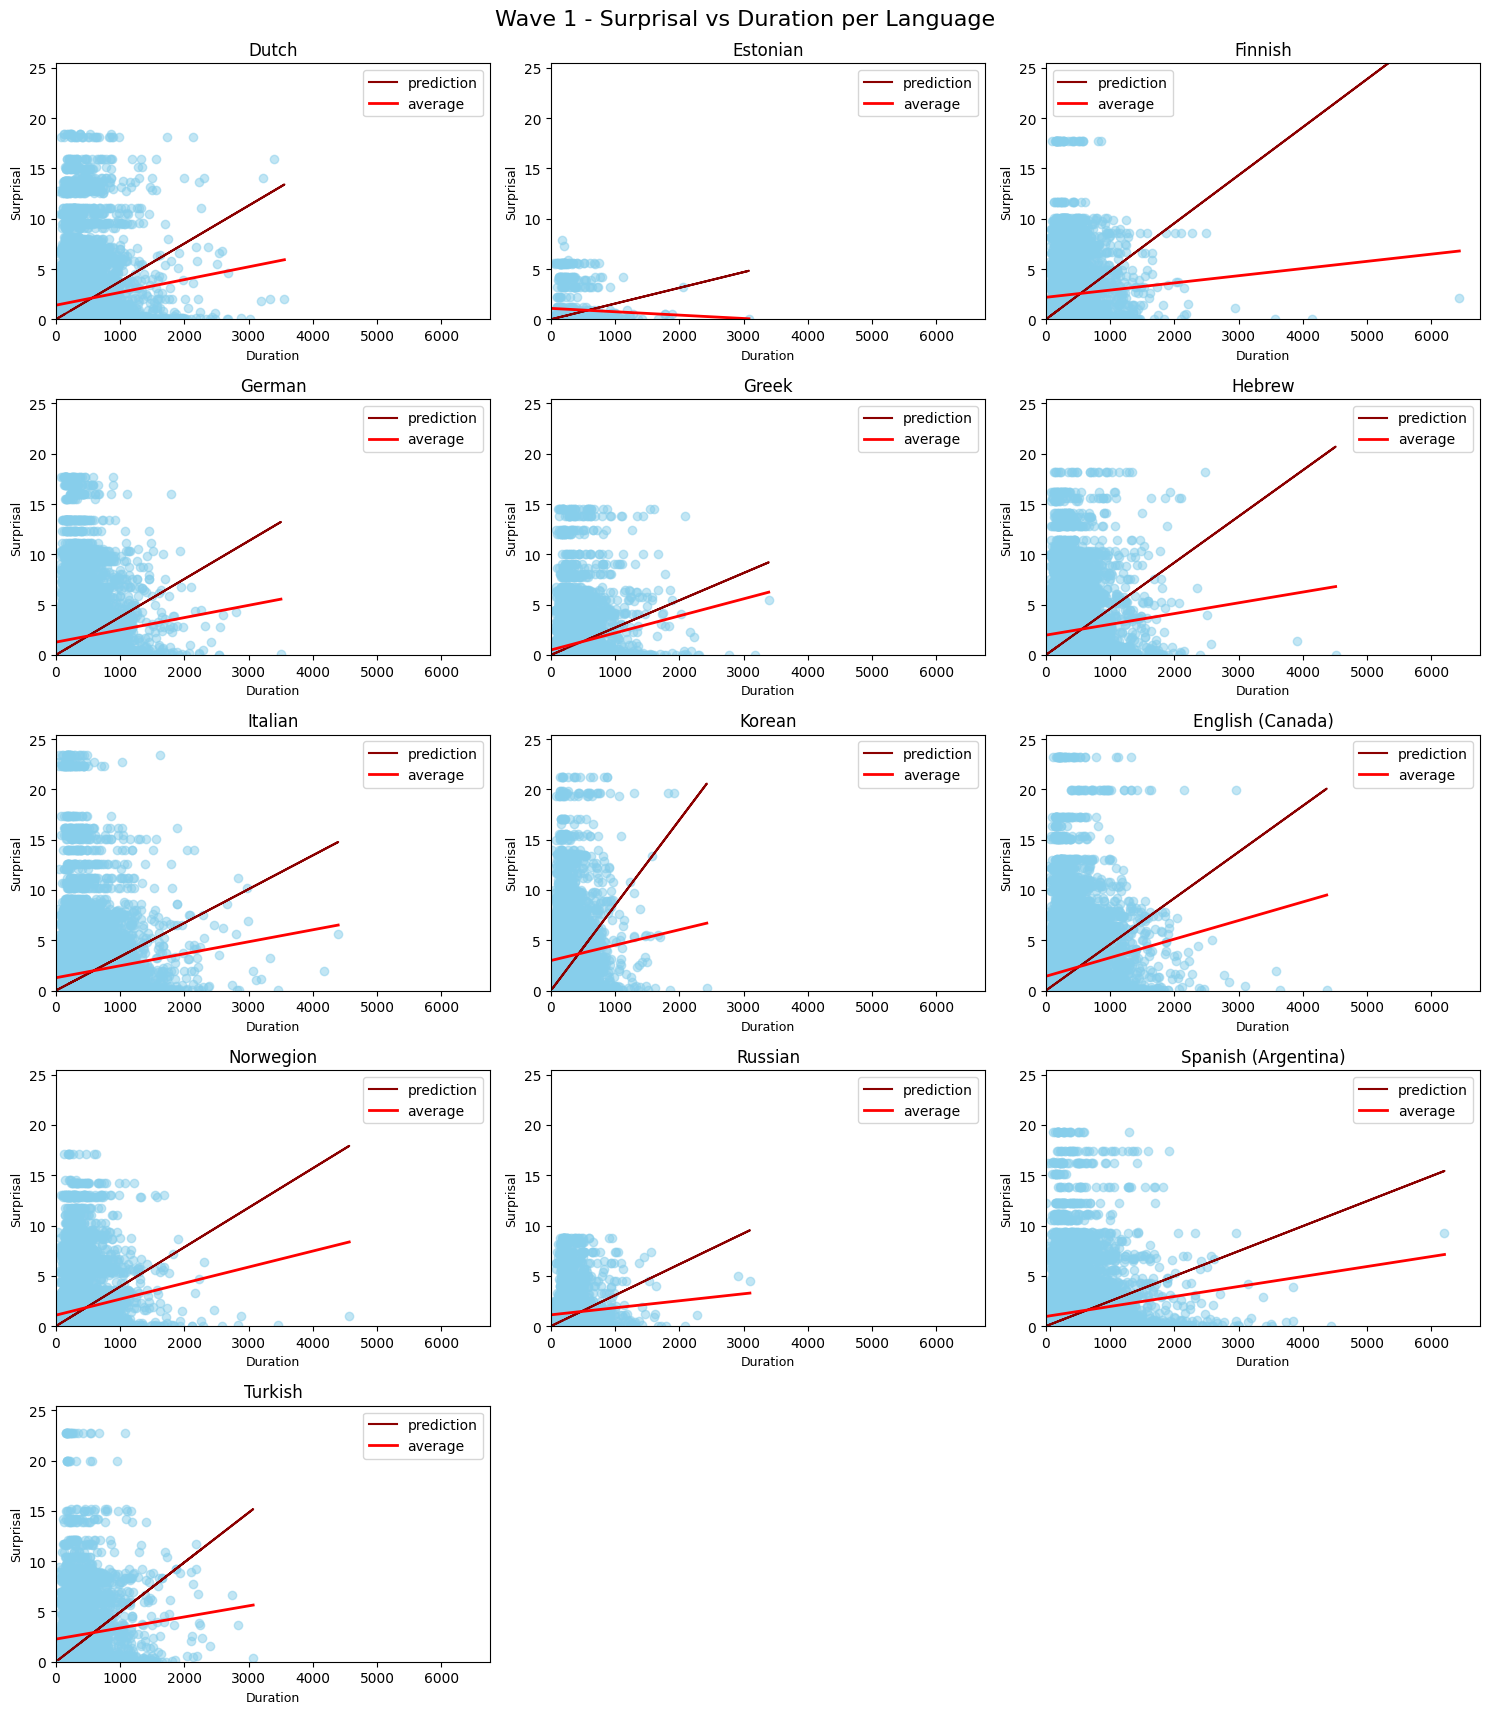

In [ ]:
scatter_plot_per_language(wave1_dict, wave1_languages, languages, wave1_OLS, 'dur', 'Duration', 1)

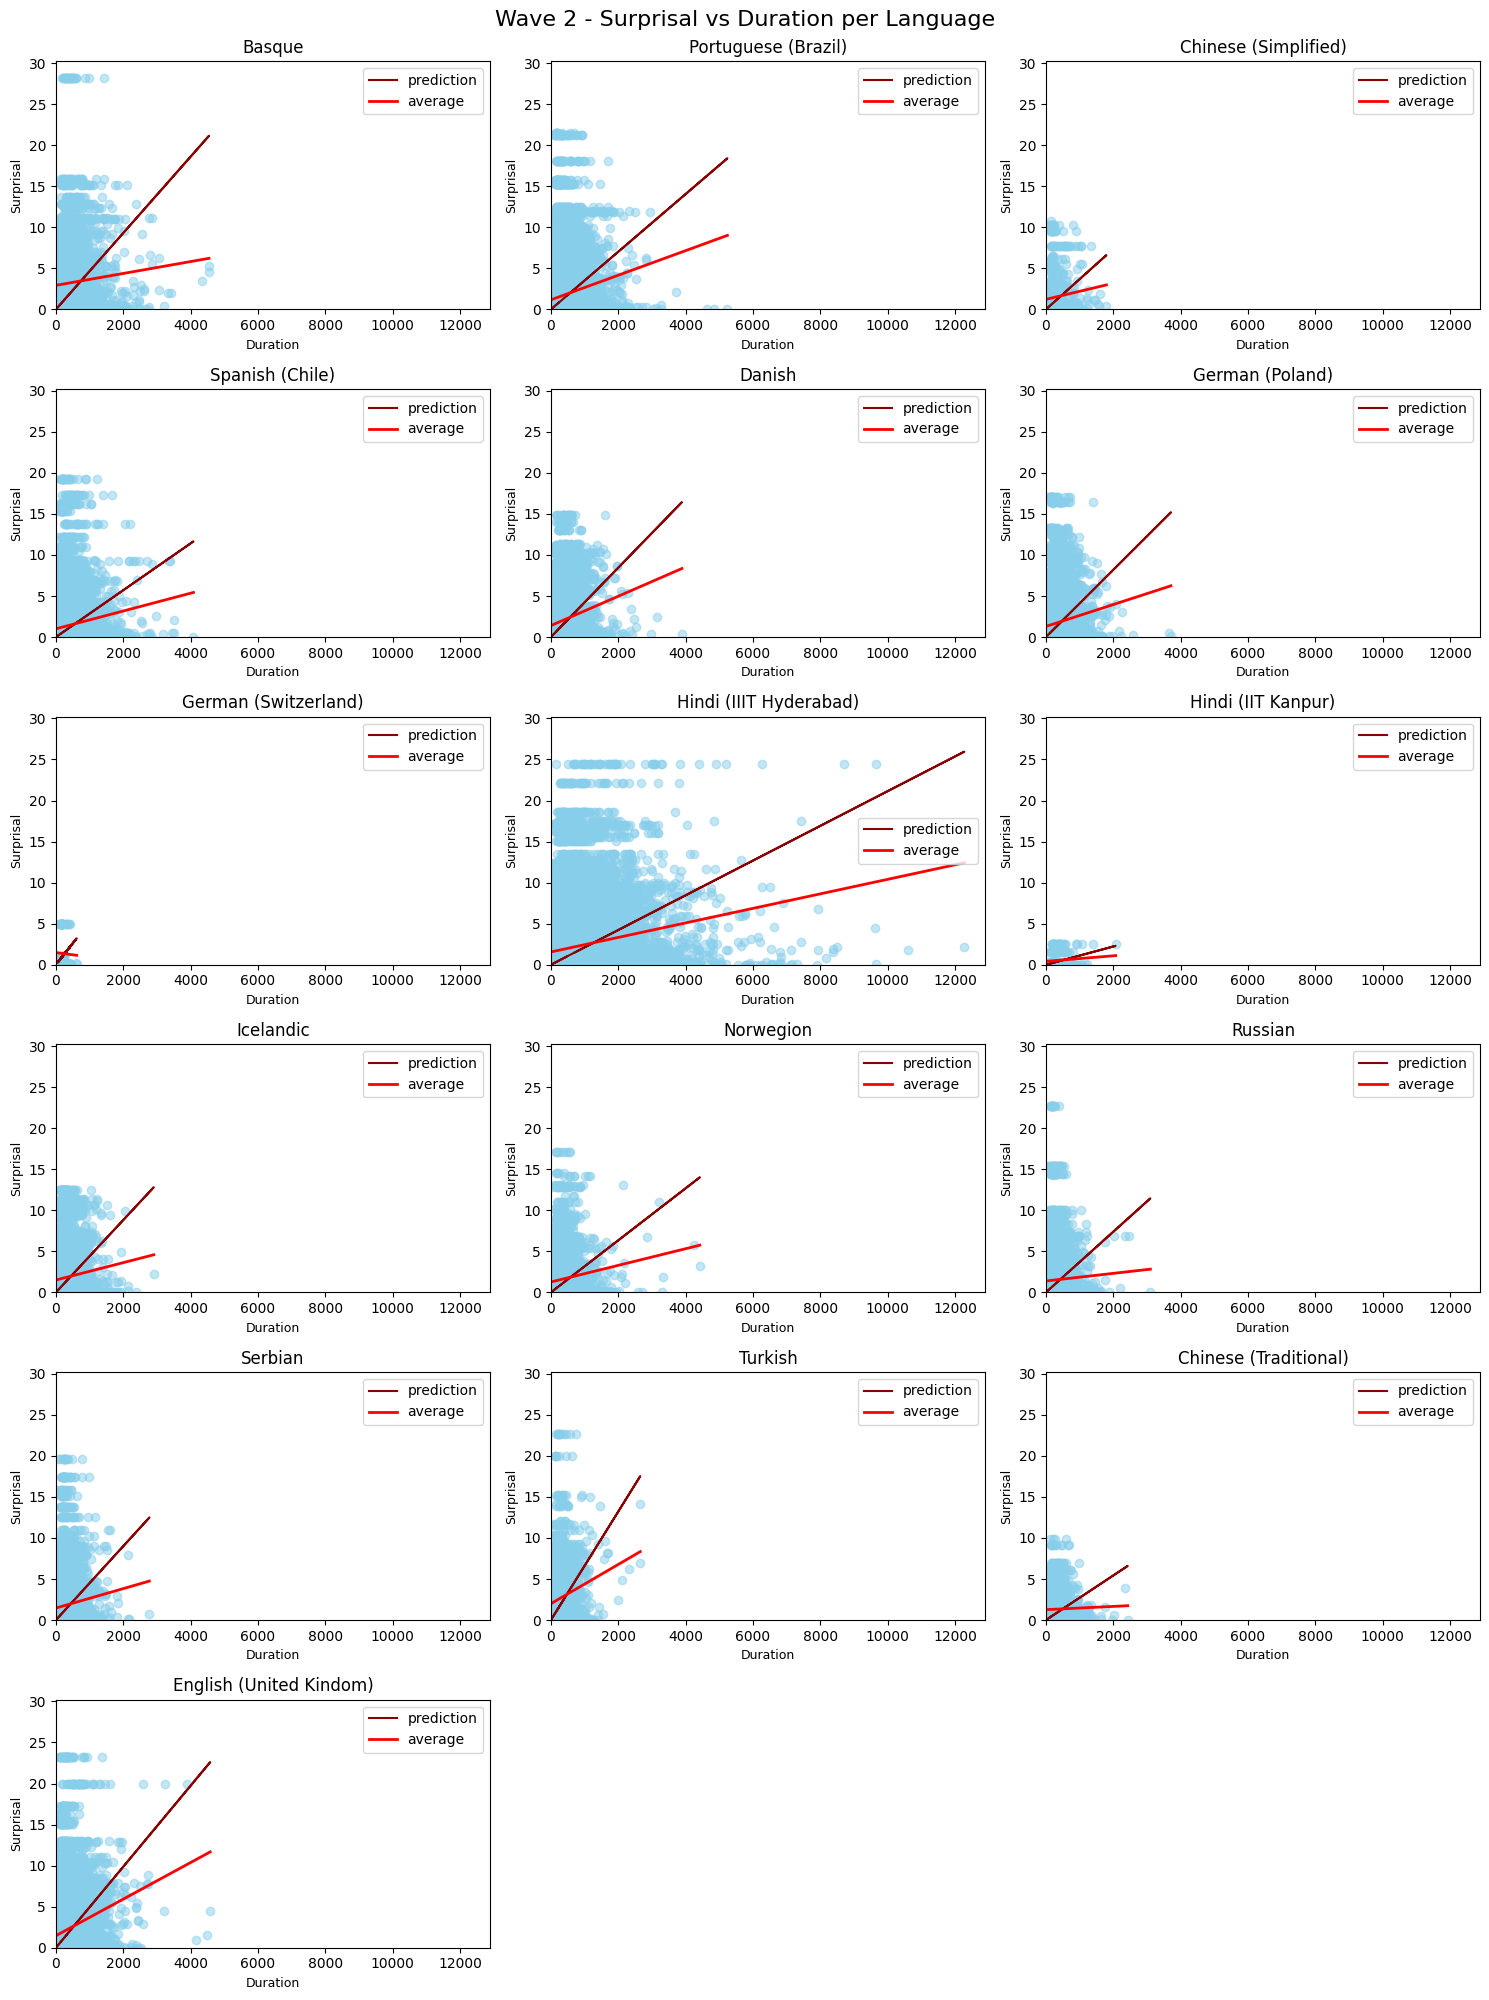

In [ ]:
scatter_plot_per_language(wave2_dict, wave2_languages, languages, wave2_OLS, 'dur', 'Duration', 2)

### Number of Rereads

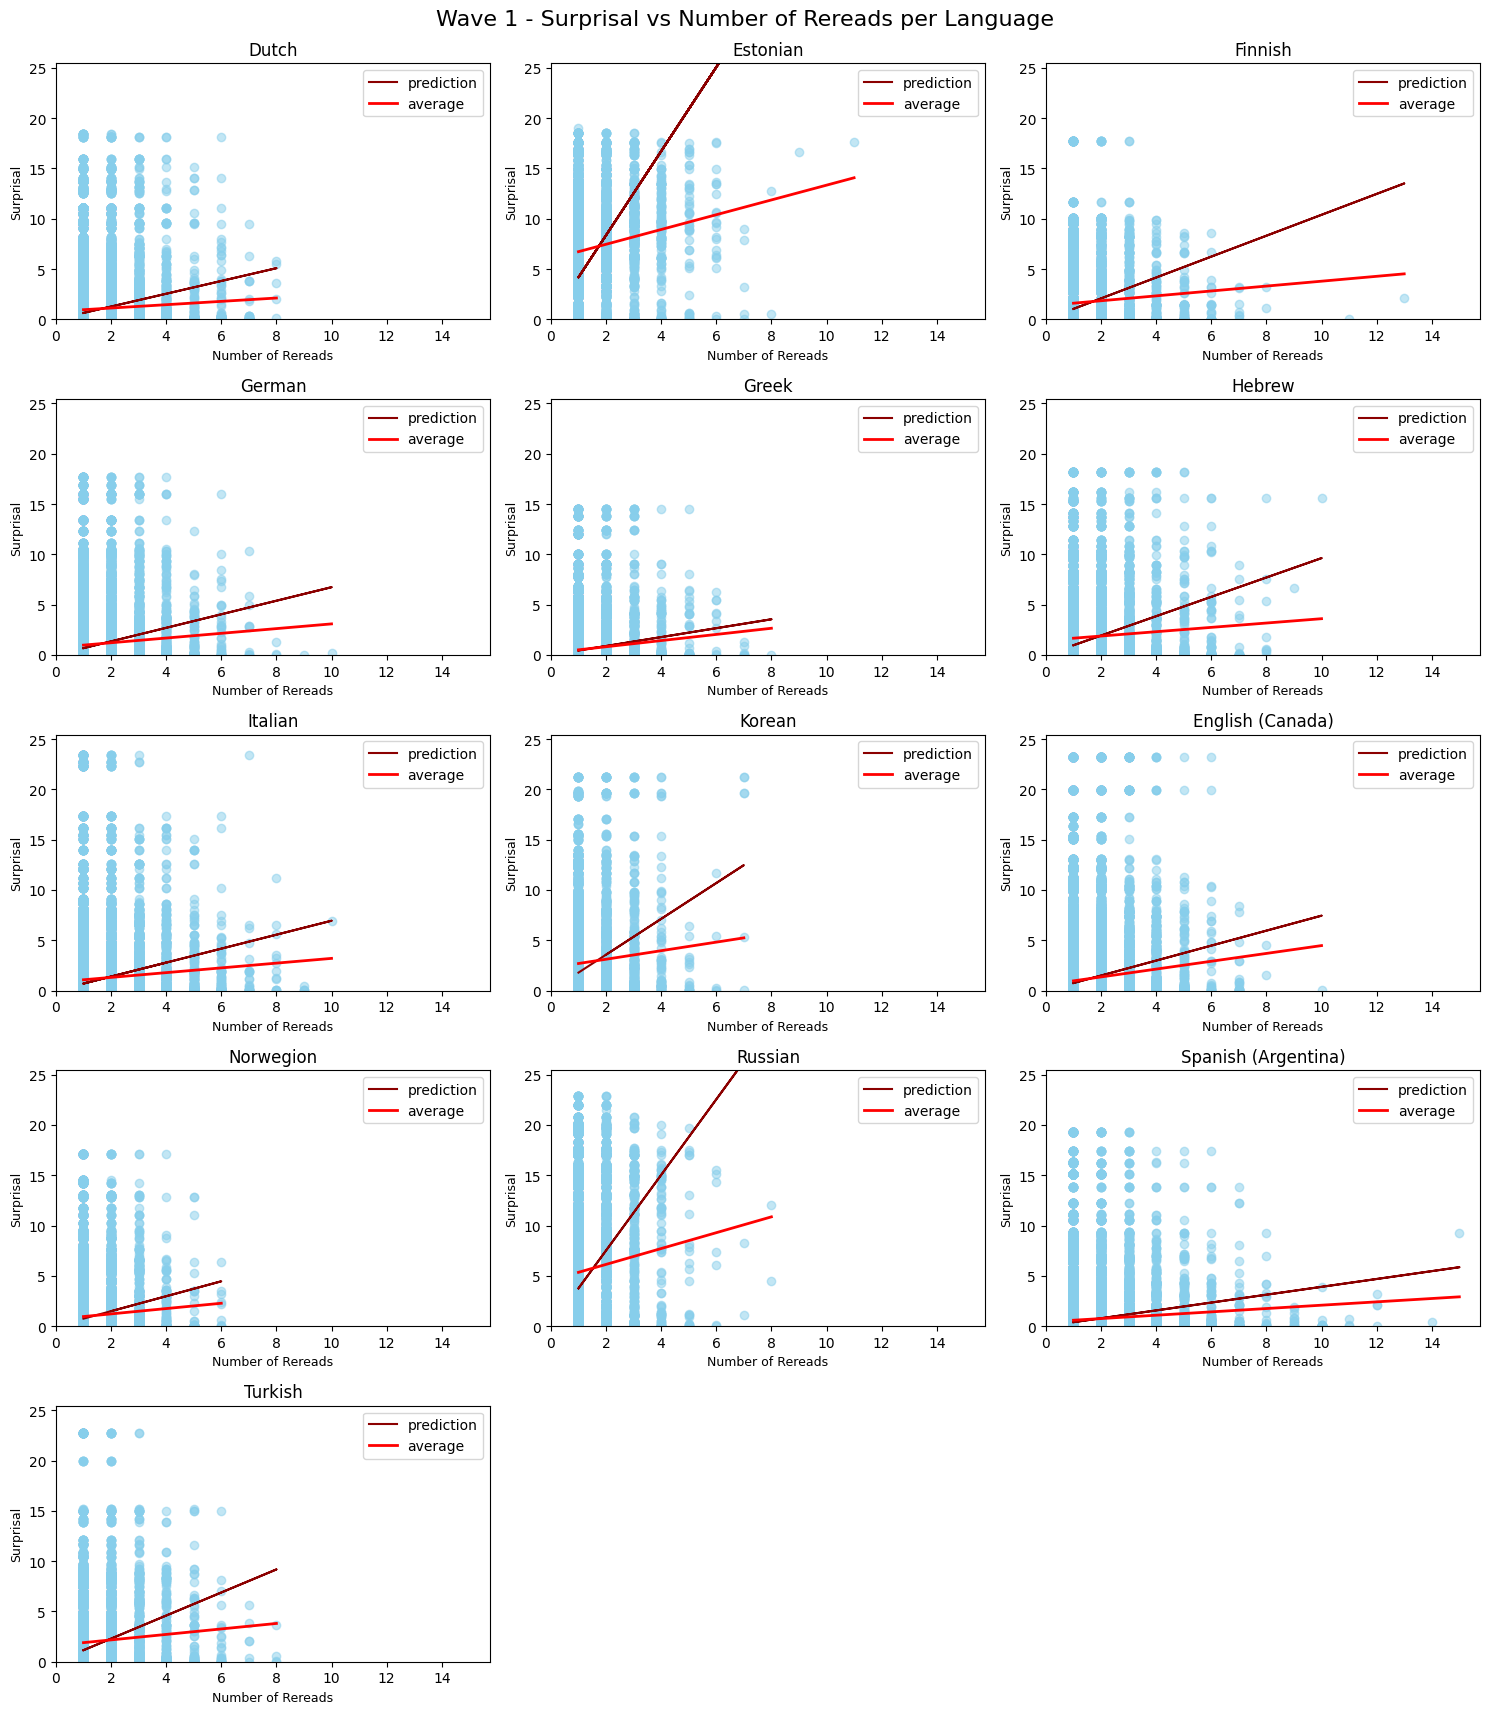

In [ ]:
scatter_plot_per_language(wave1_dict, wave1_languages, languages, wave1_OLS, 'nrun', 'Number of Rereads', 1)

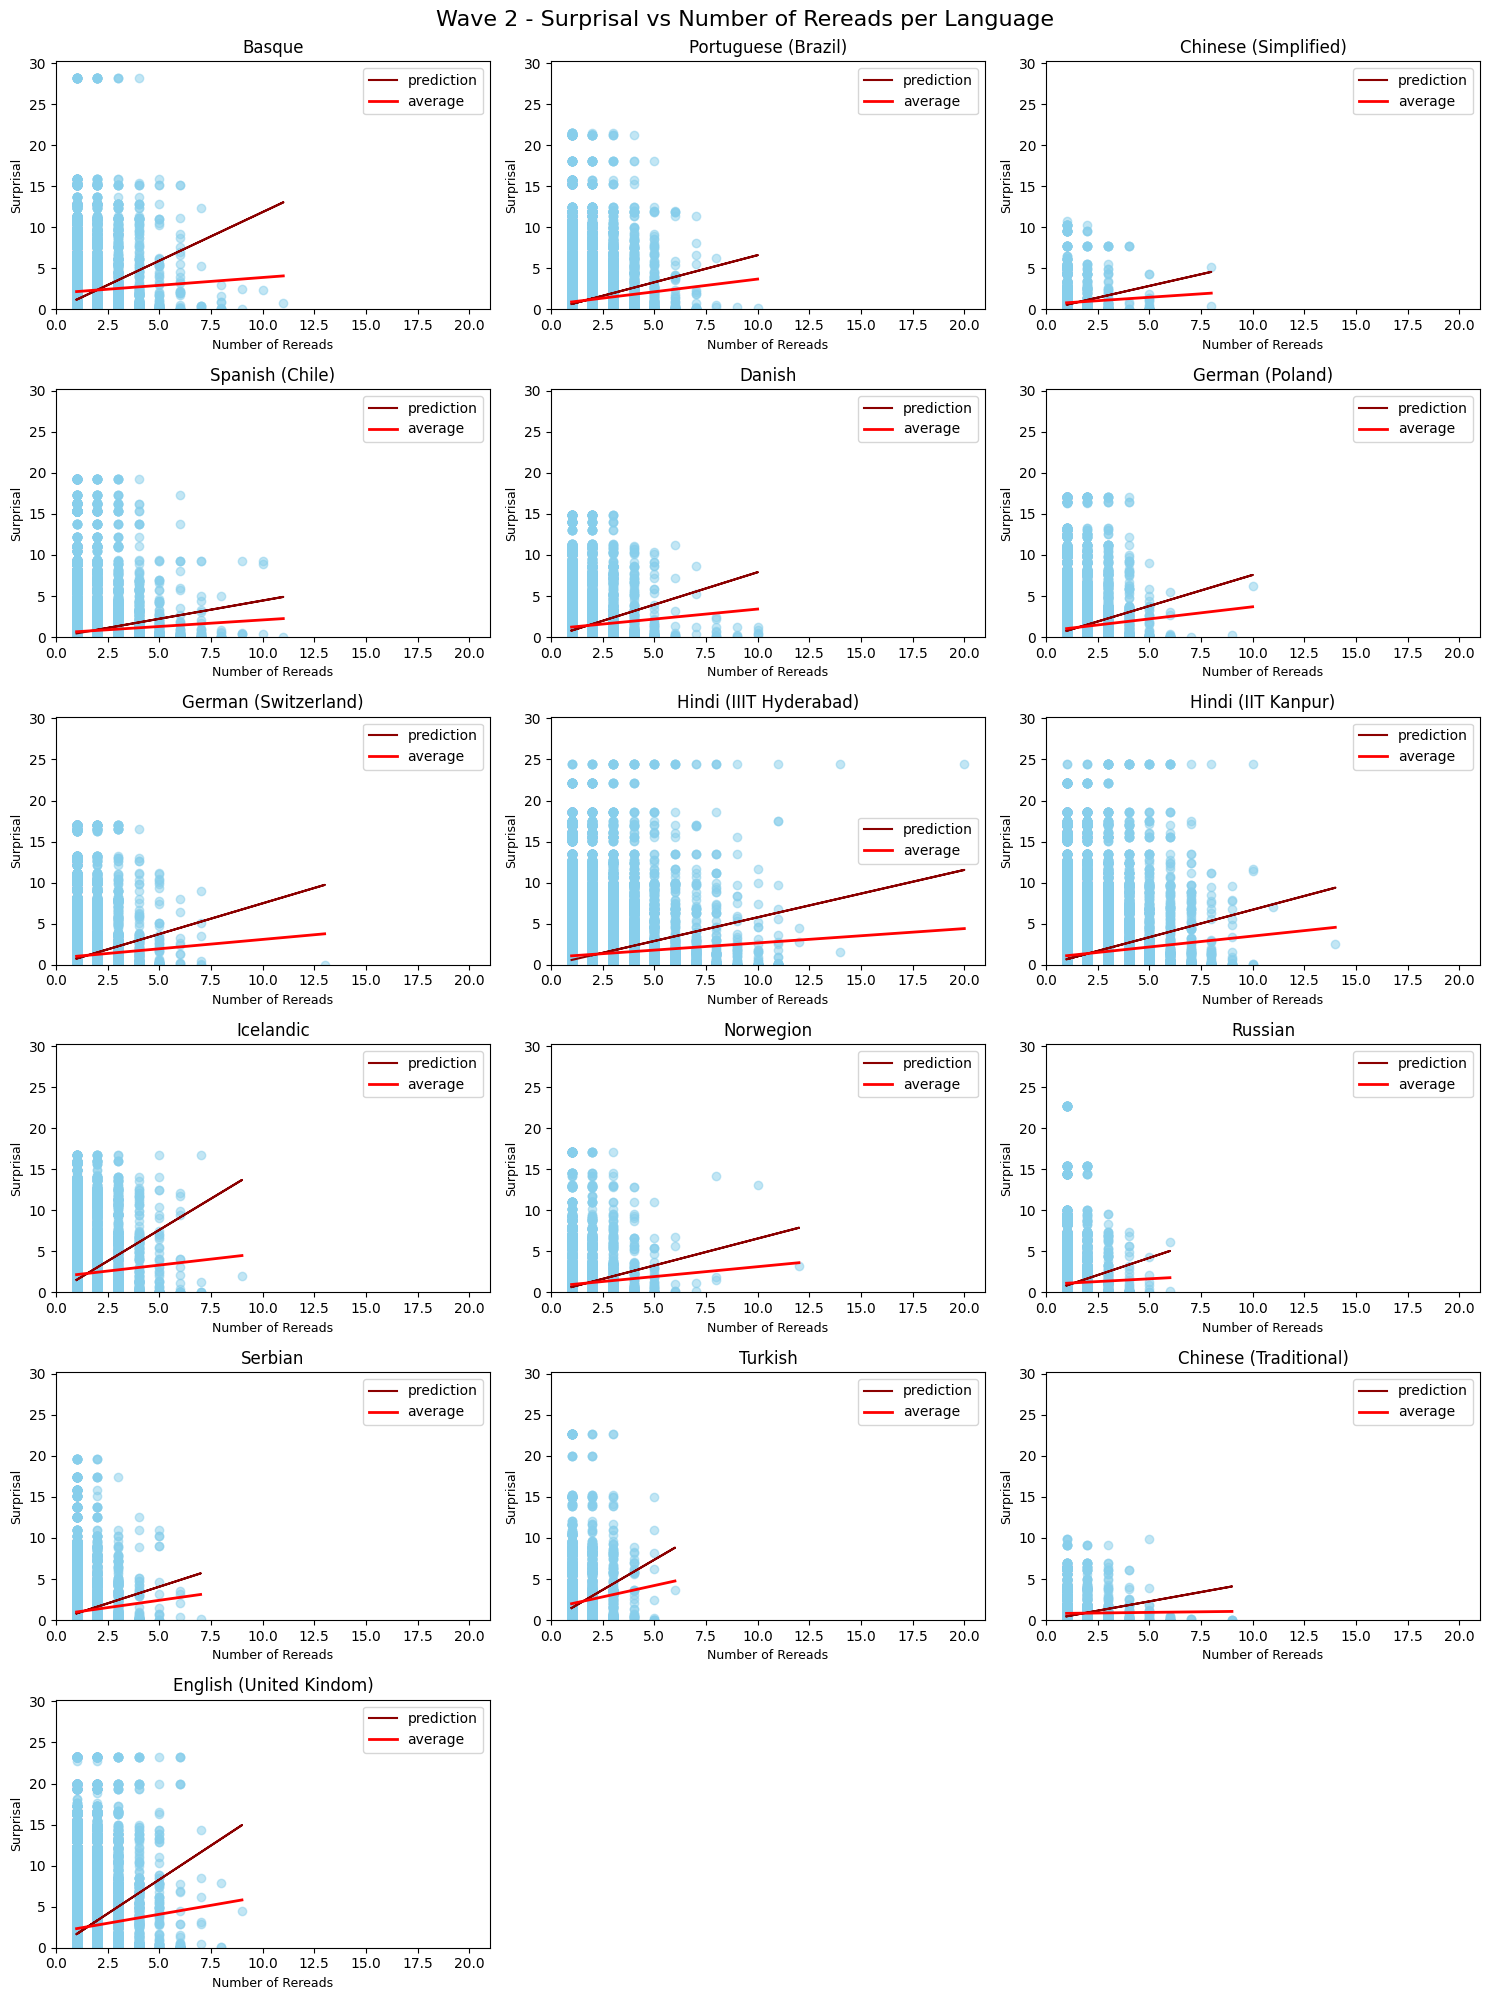

In [ ]:
scatter_plot_per_language(wave2_dict, wave2_languages, languages, wave2_OLS, 'nrun', 'Number of Rereads', 2)

### Number of Fixations

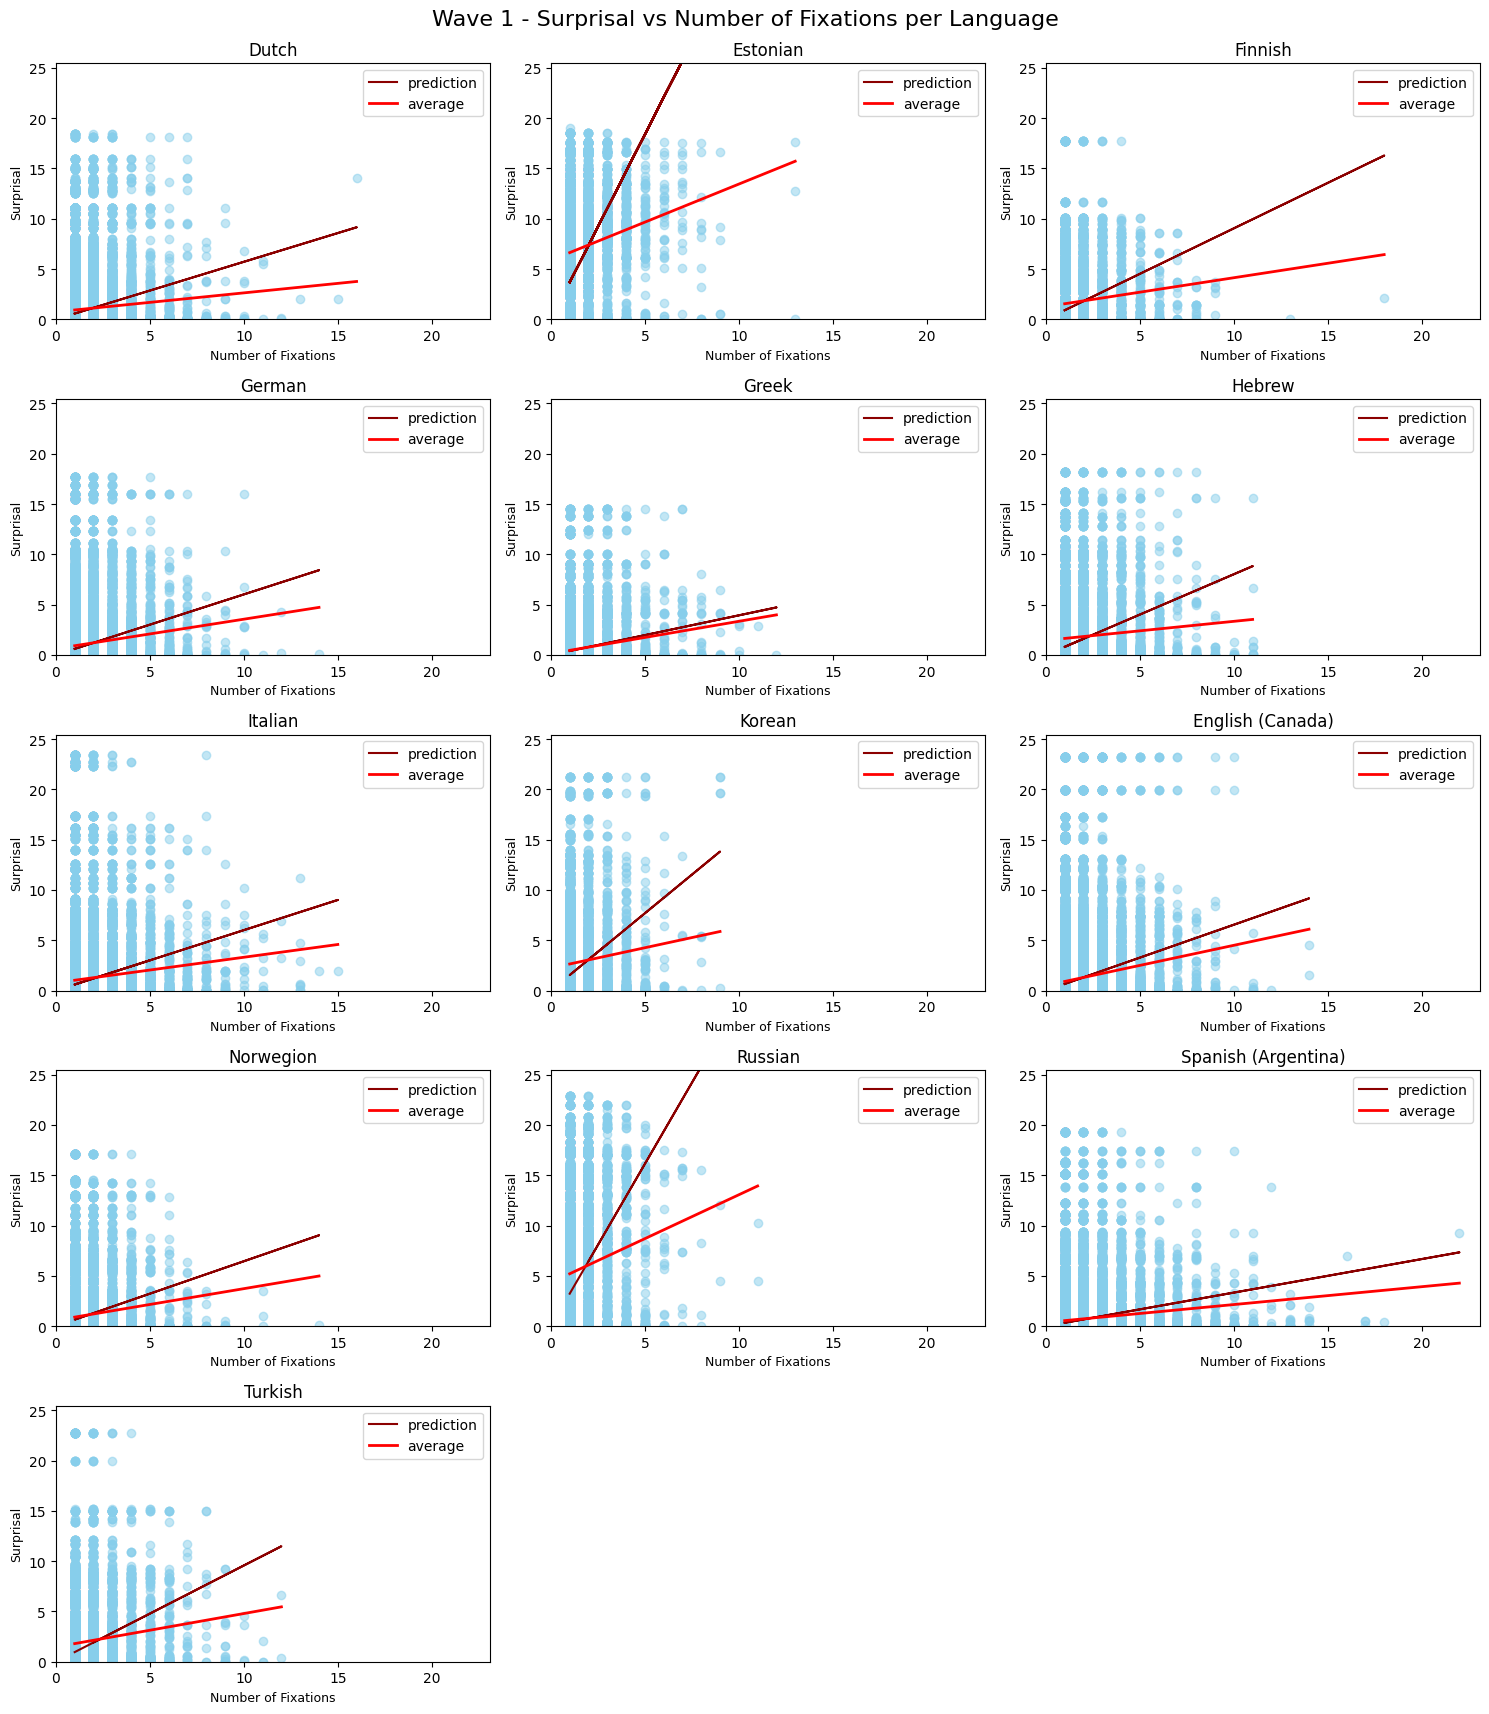

In [ ]:
scatter_plot_per_language(wave1_dict, wave1_languages, languages, wave1_OLS, 'nfix', 'Number of Fixations', 1)

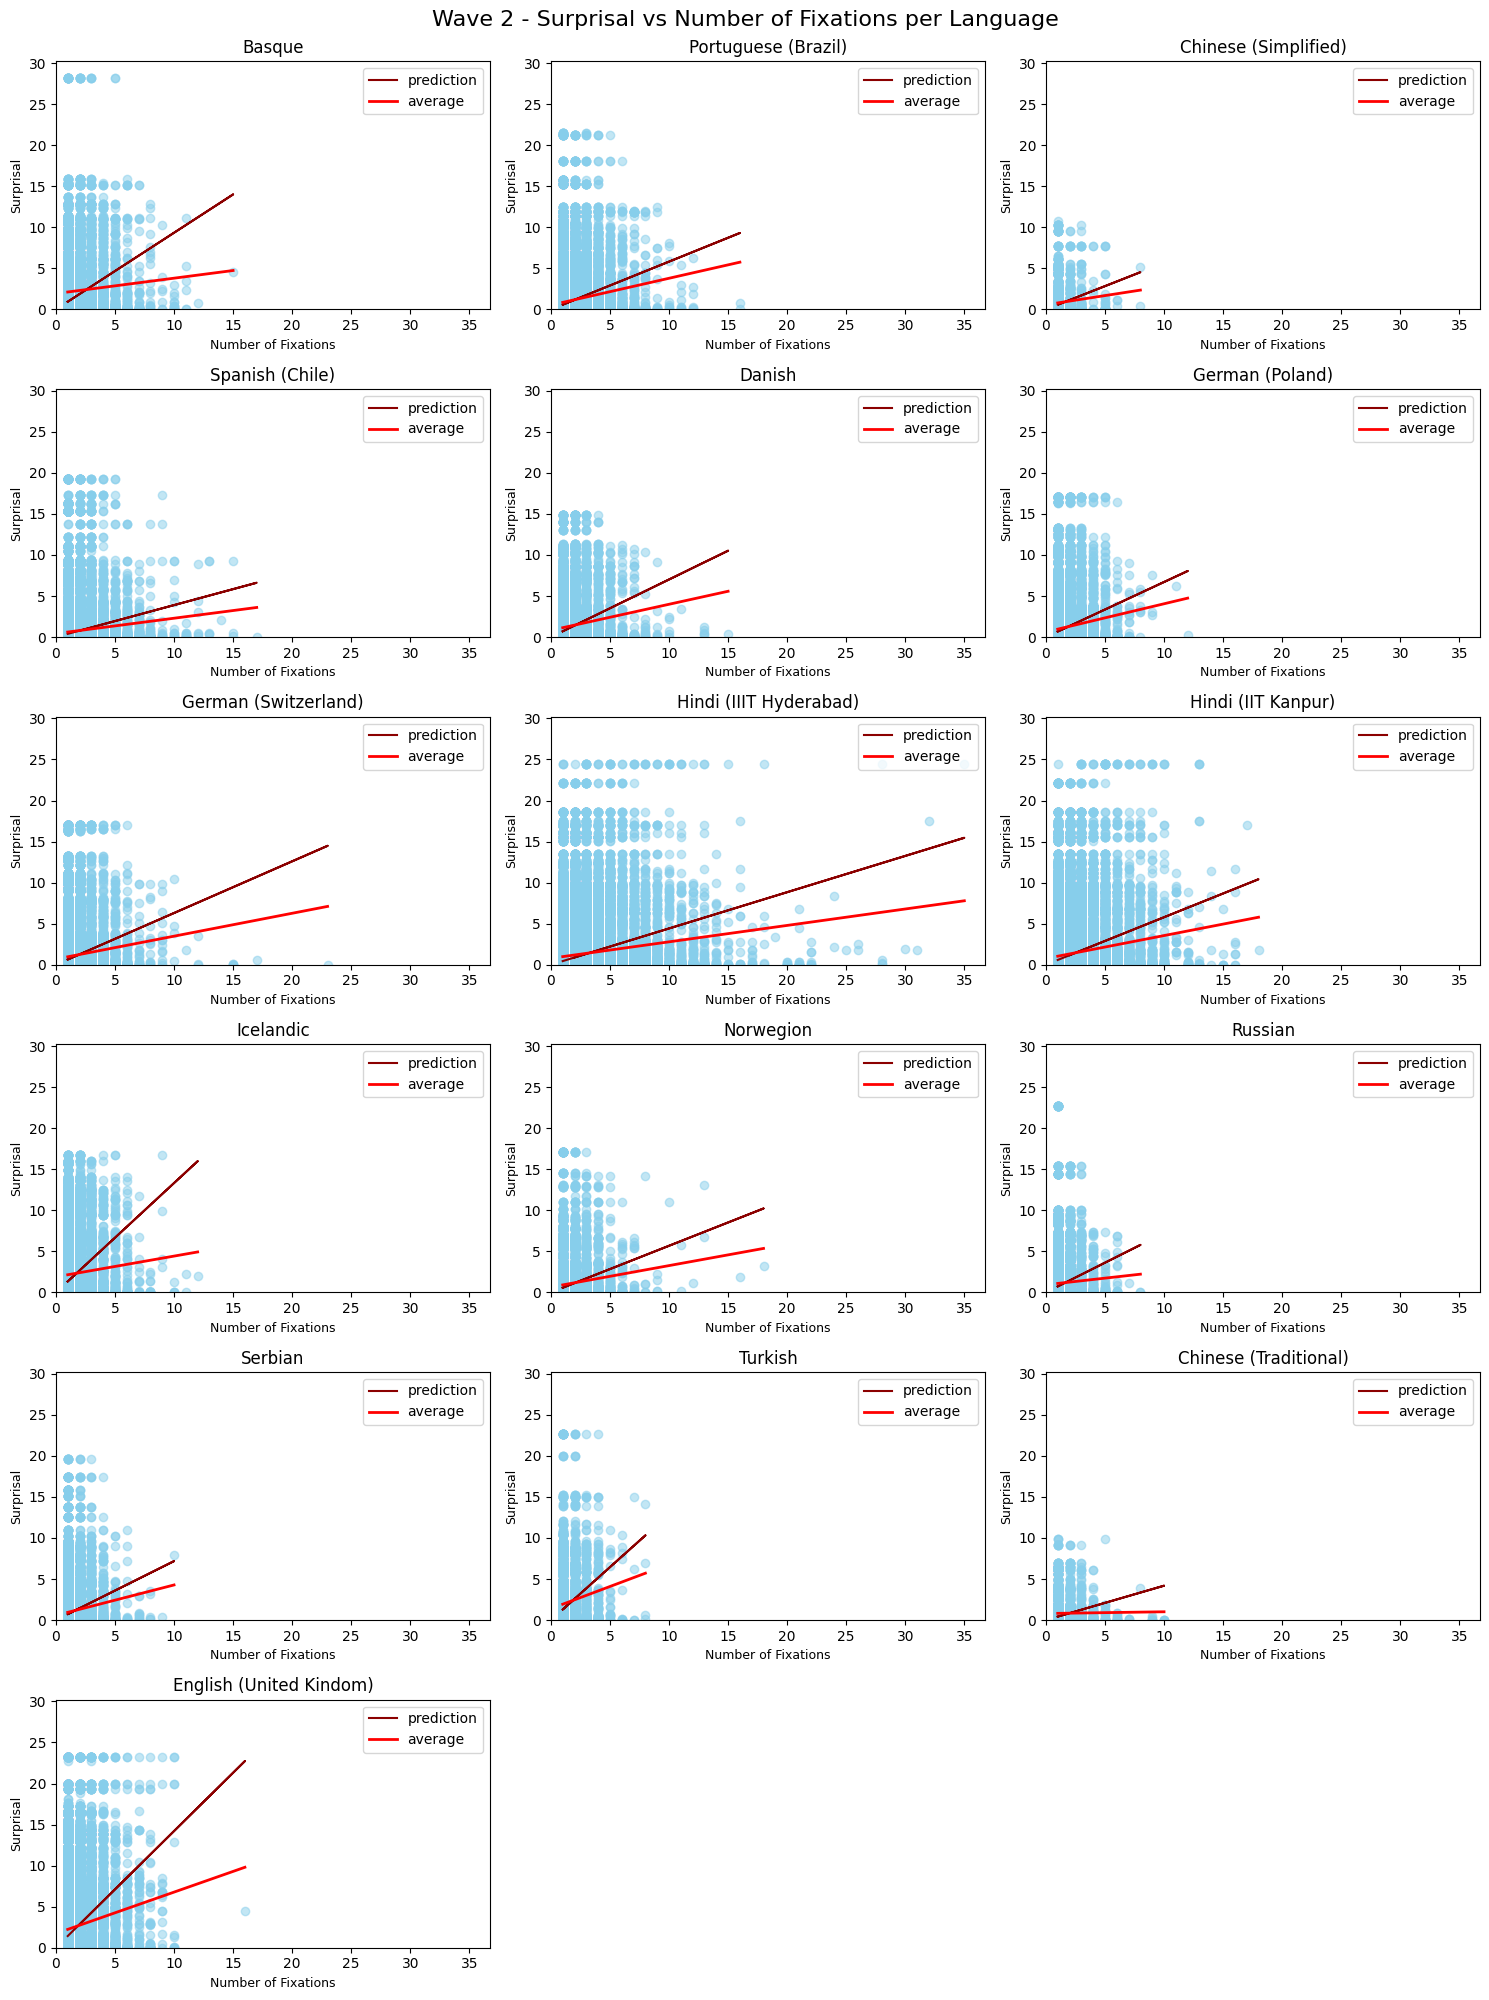

In [ ]:
scatter_plot_per_language(wave2_dict, wave2_languages, languages, wave2_OLS, 'nfix', 'Number of Fixations', 2)

### Number of Fixations in the First Run

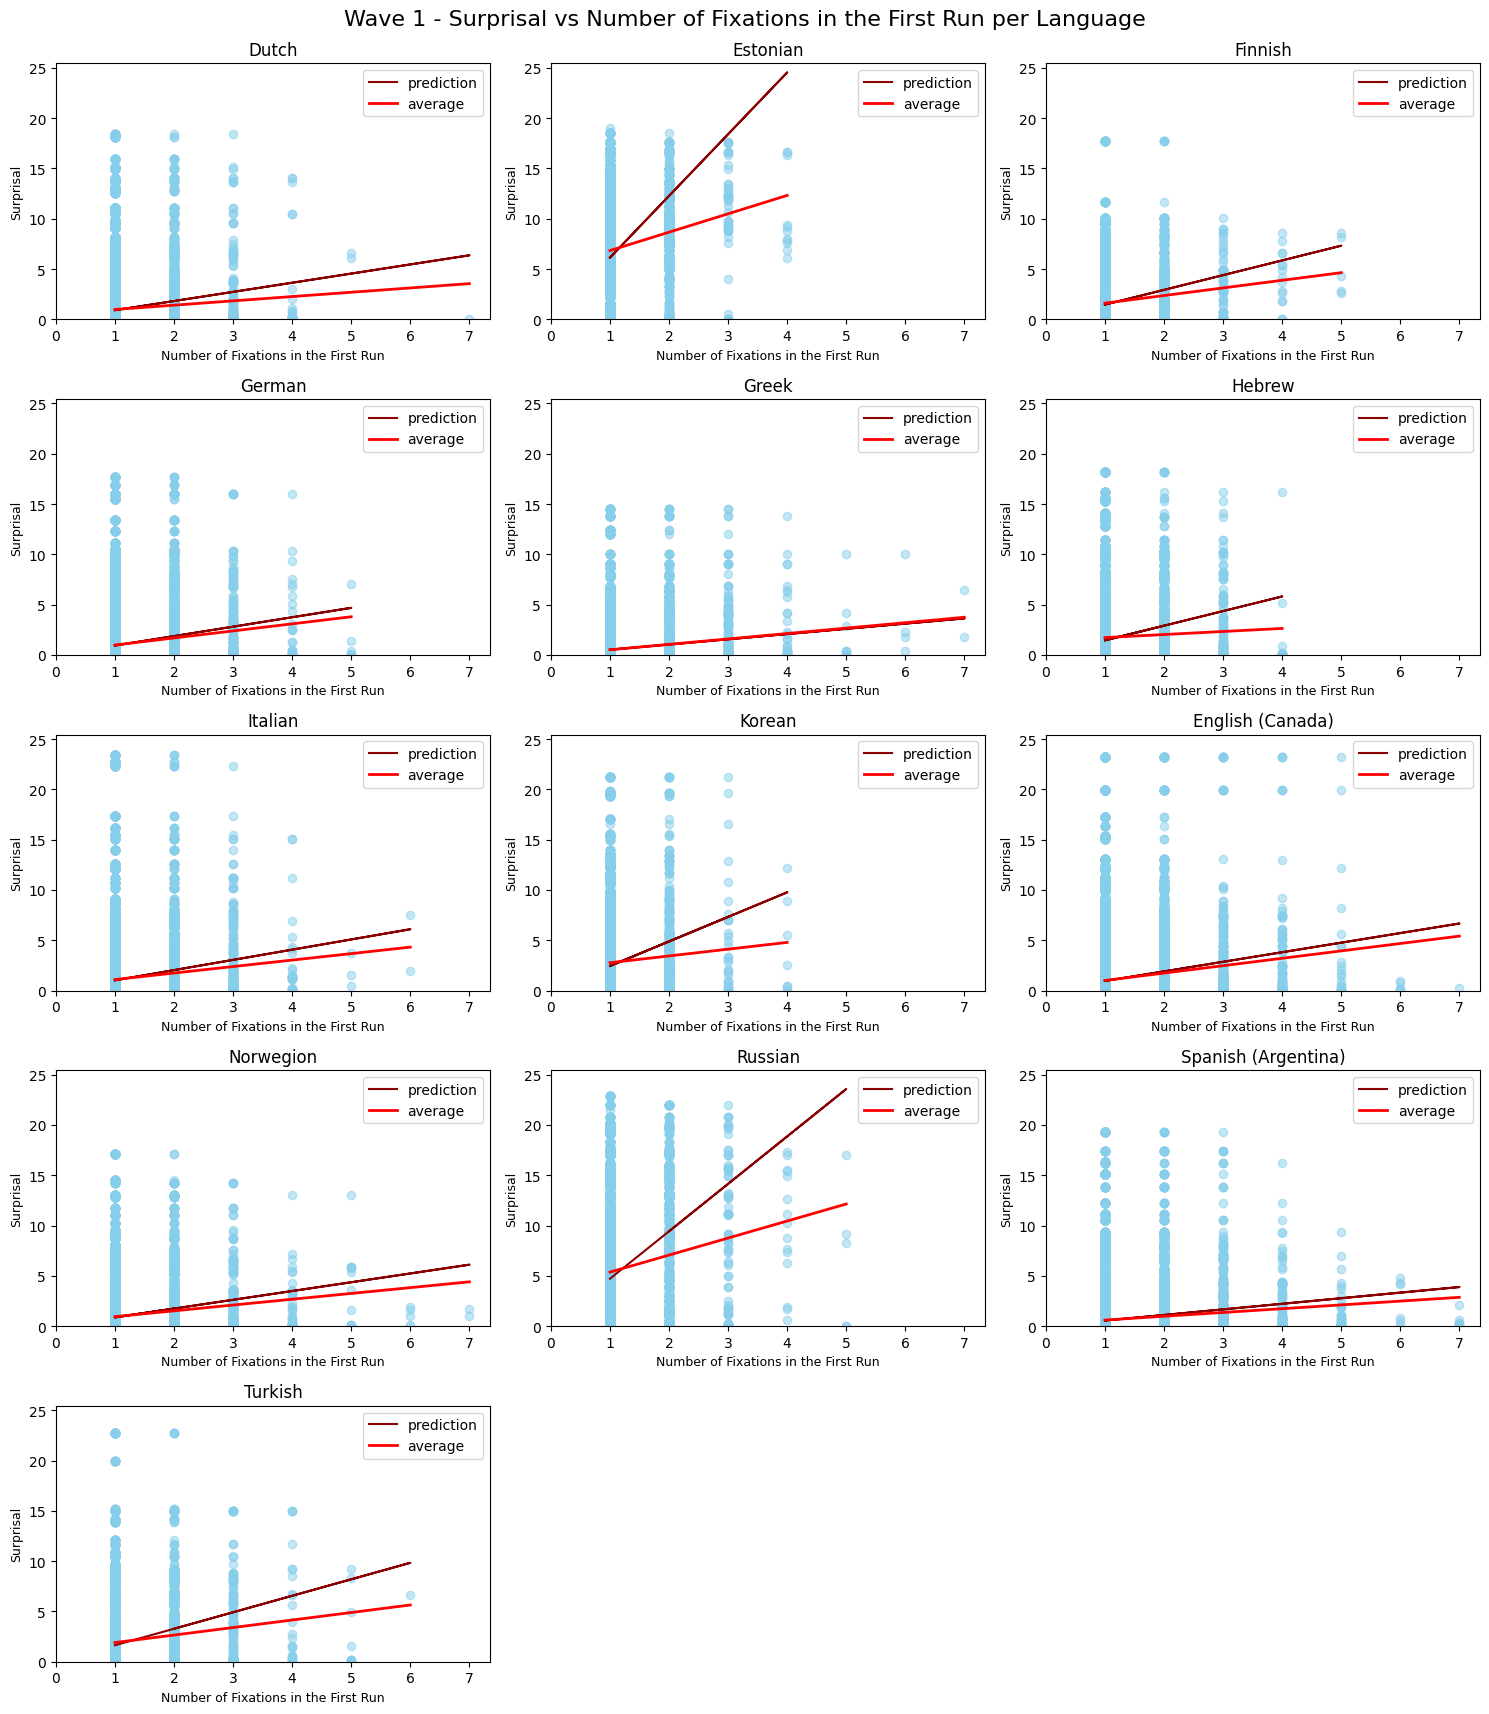

In [ ]:
scatter_plot_per_language(wave1_dict, wave1_languages, languages, wave1_OLS, 'firstrun.nfix', 'Number of Fixations in the First Run', 1)

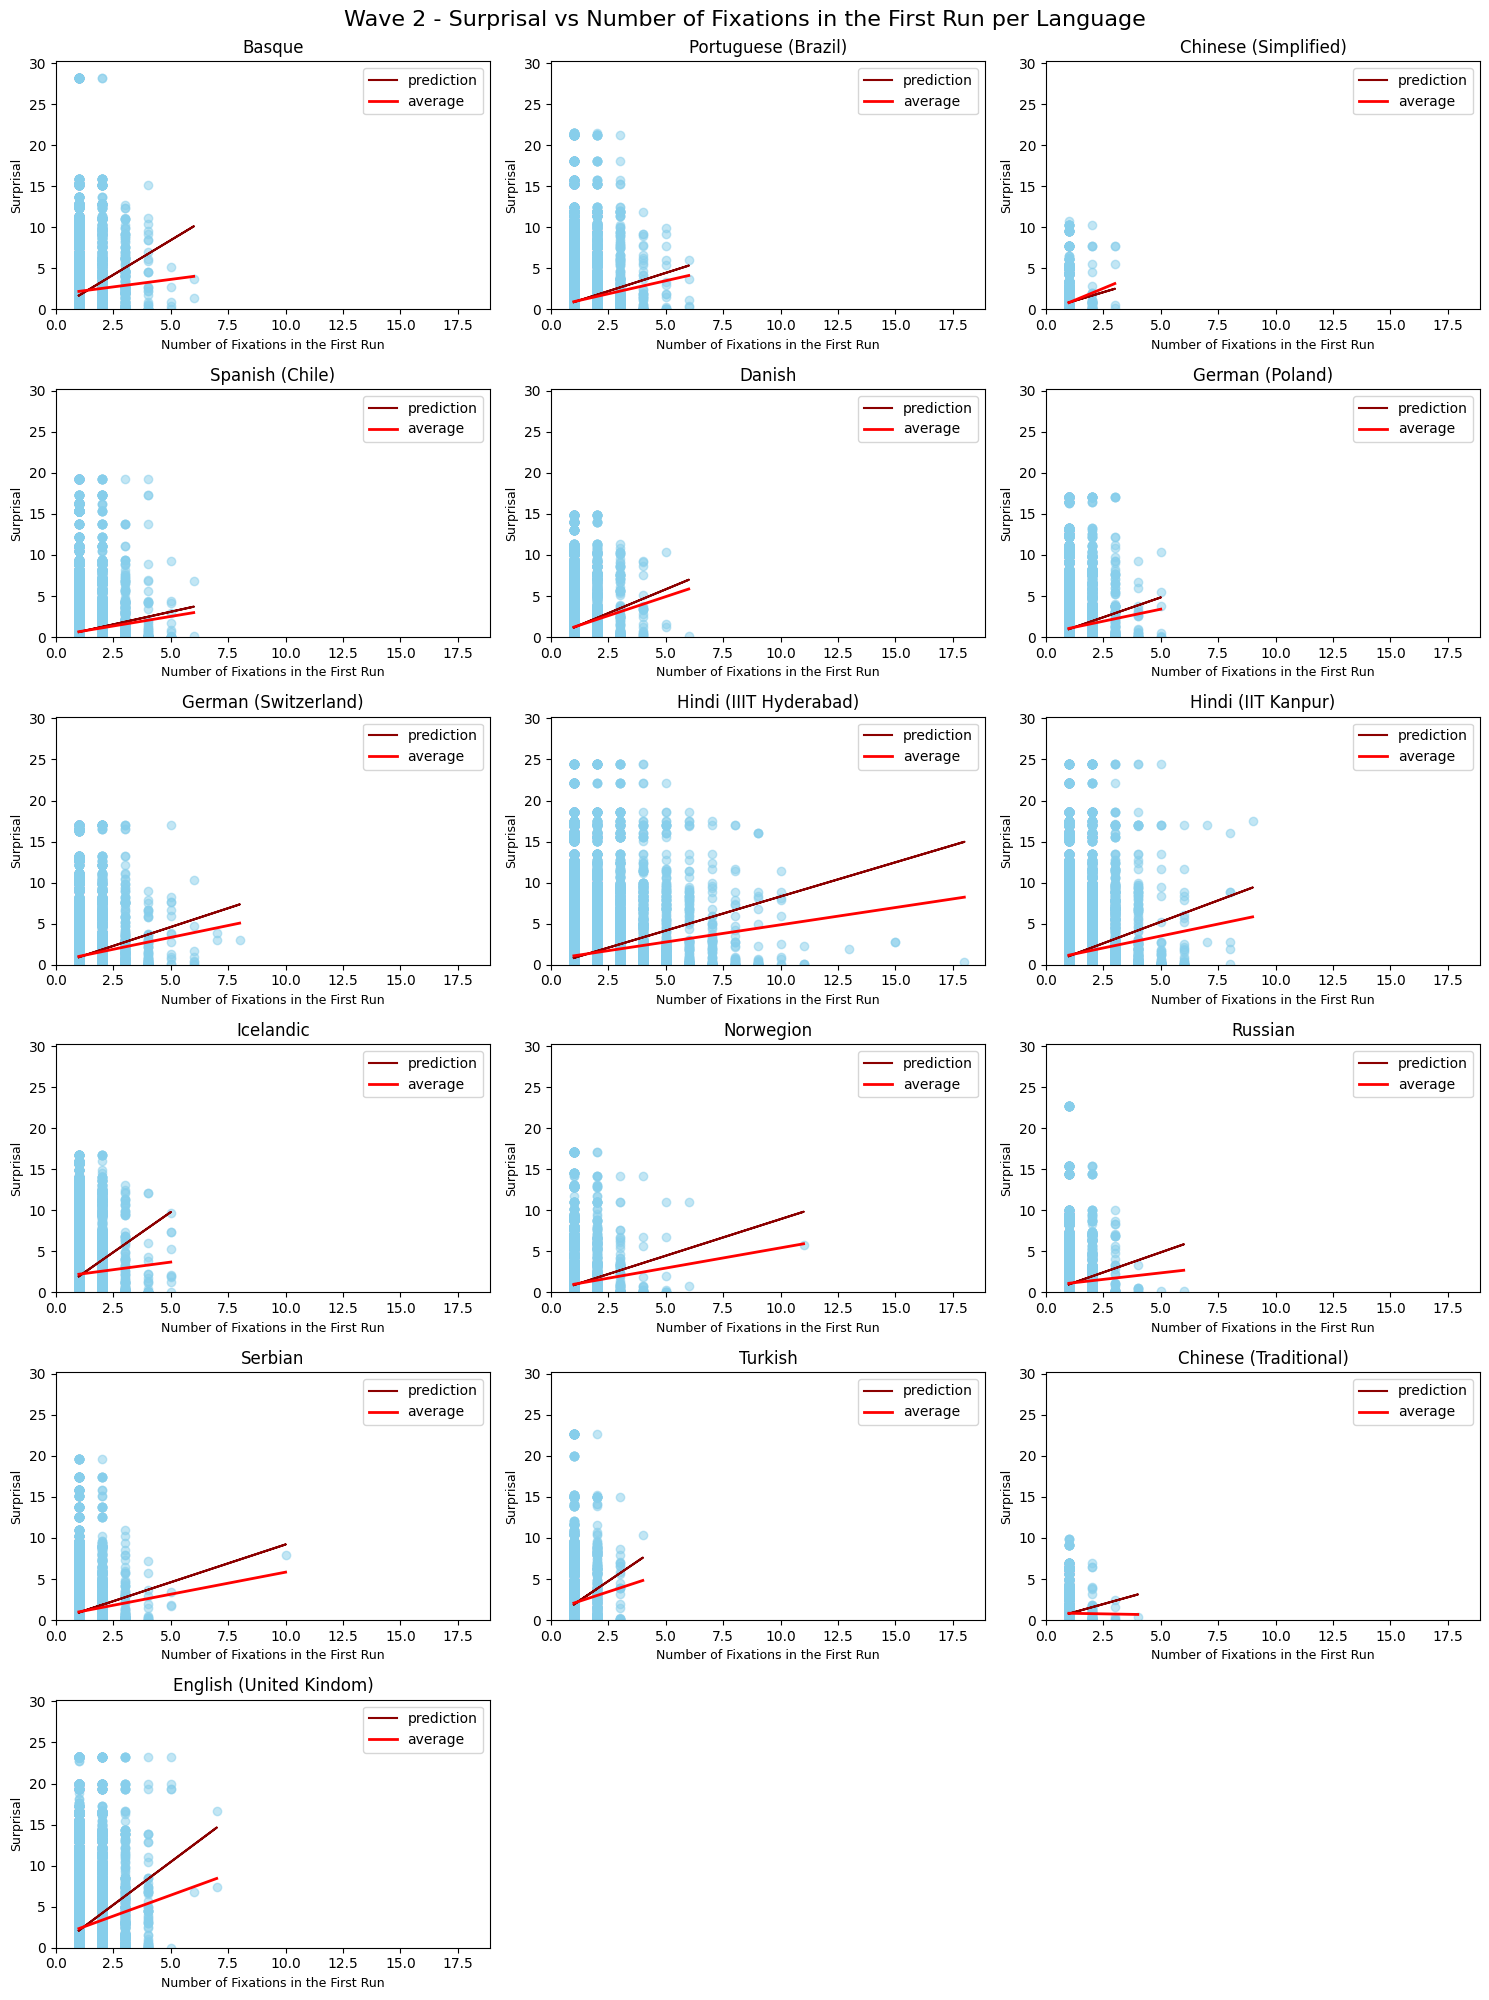

In [ ]:
scatter_plot_per_language(wave2_dict, wave2_languages, languages, wave2_OLS, 'firstrun.nfix', 'Number of Fixations in the First Run', 2)

### Duration in the First Run

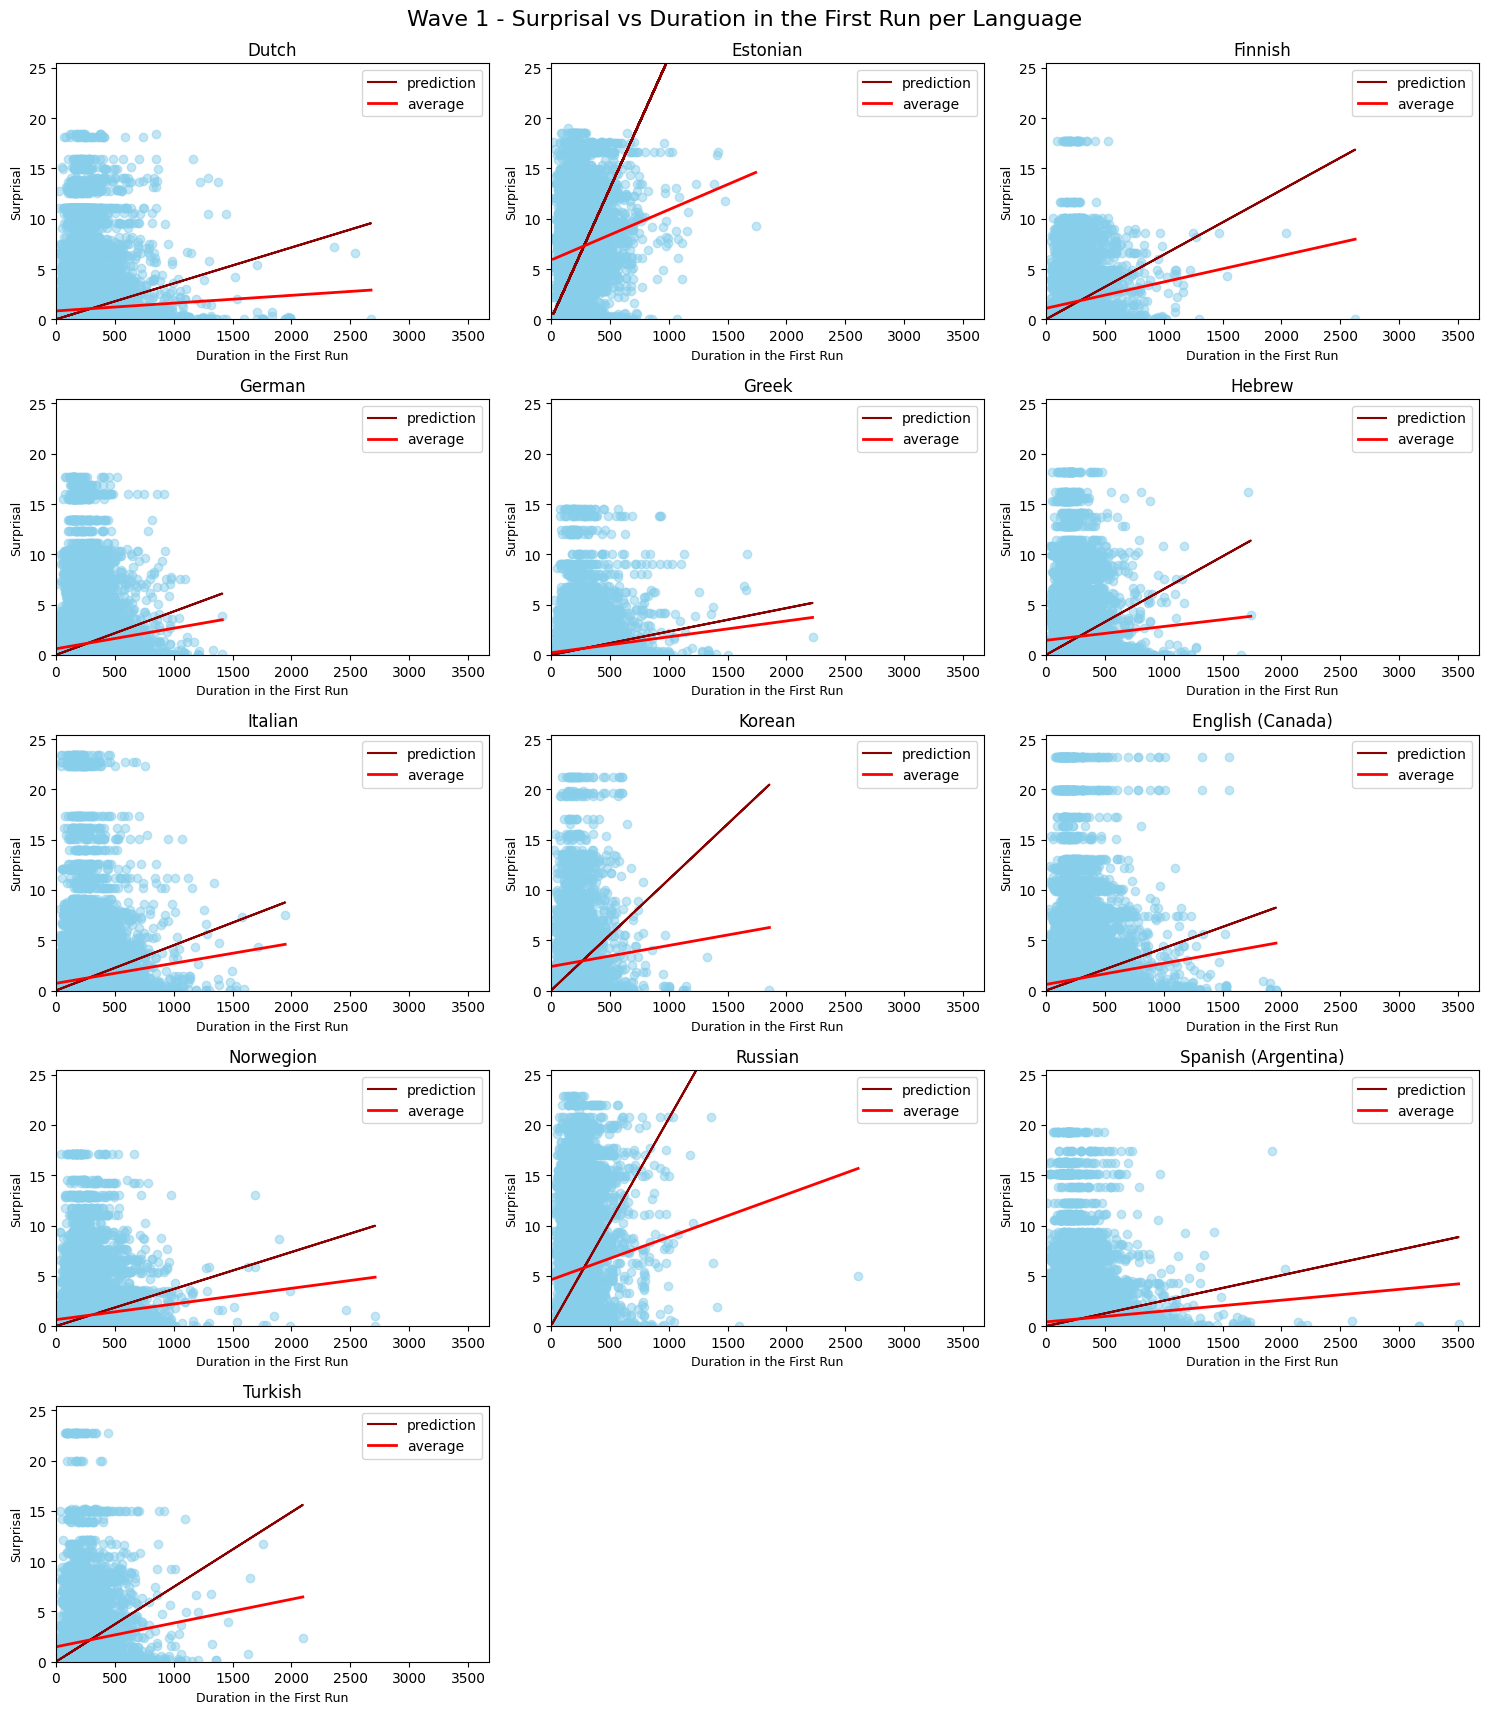

In [ ]:
scatter_plot_per_language(wave1_dict, wave1_languages, languages, wave1_OLS, 'firstrun.dur', 'Duration in the First Run', 1)

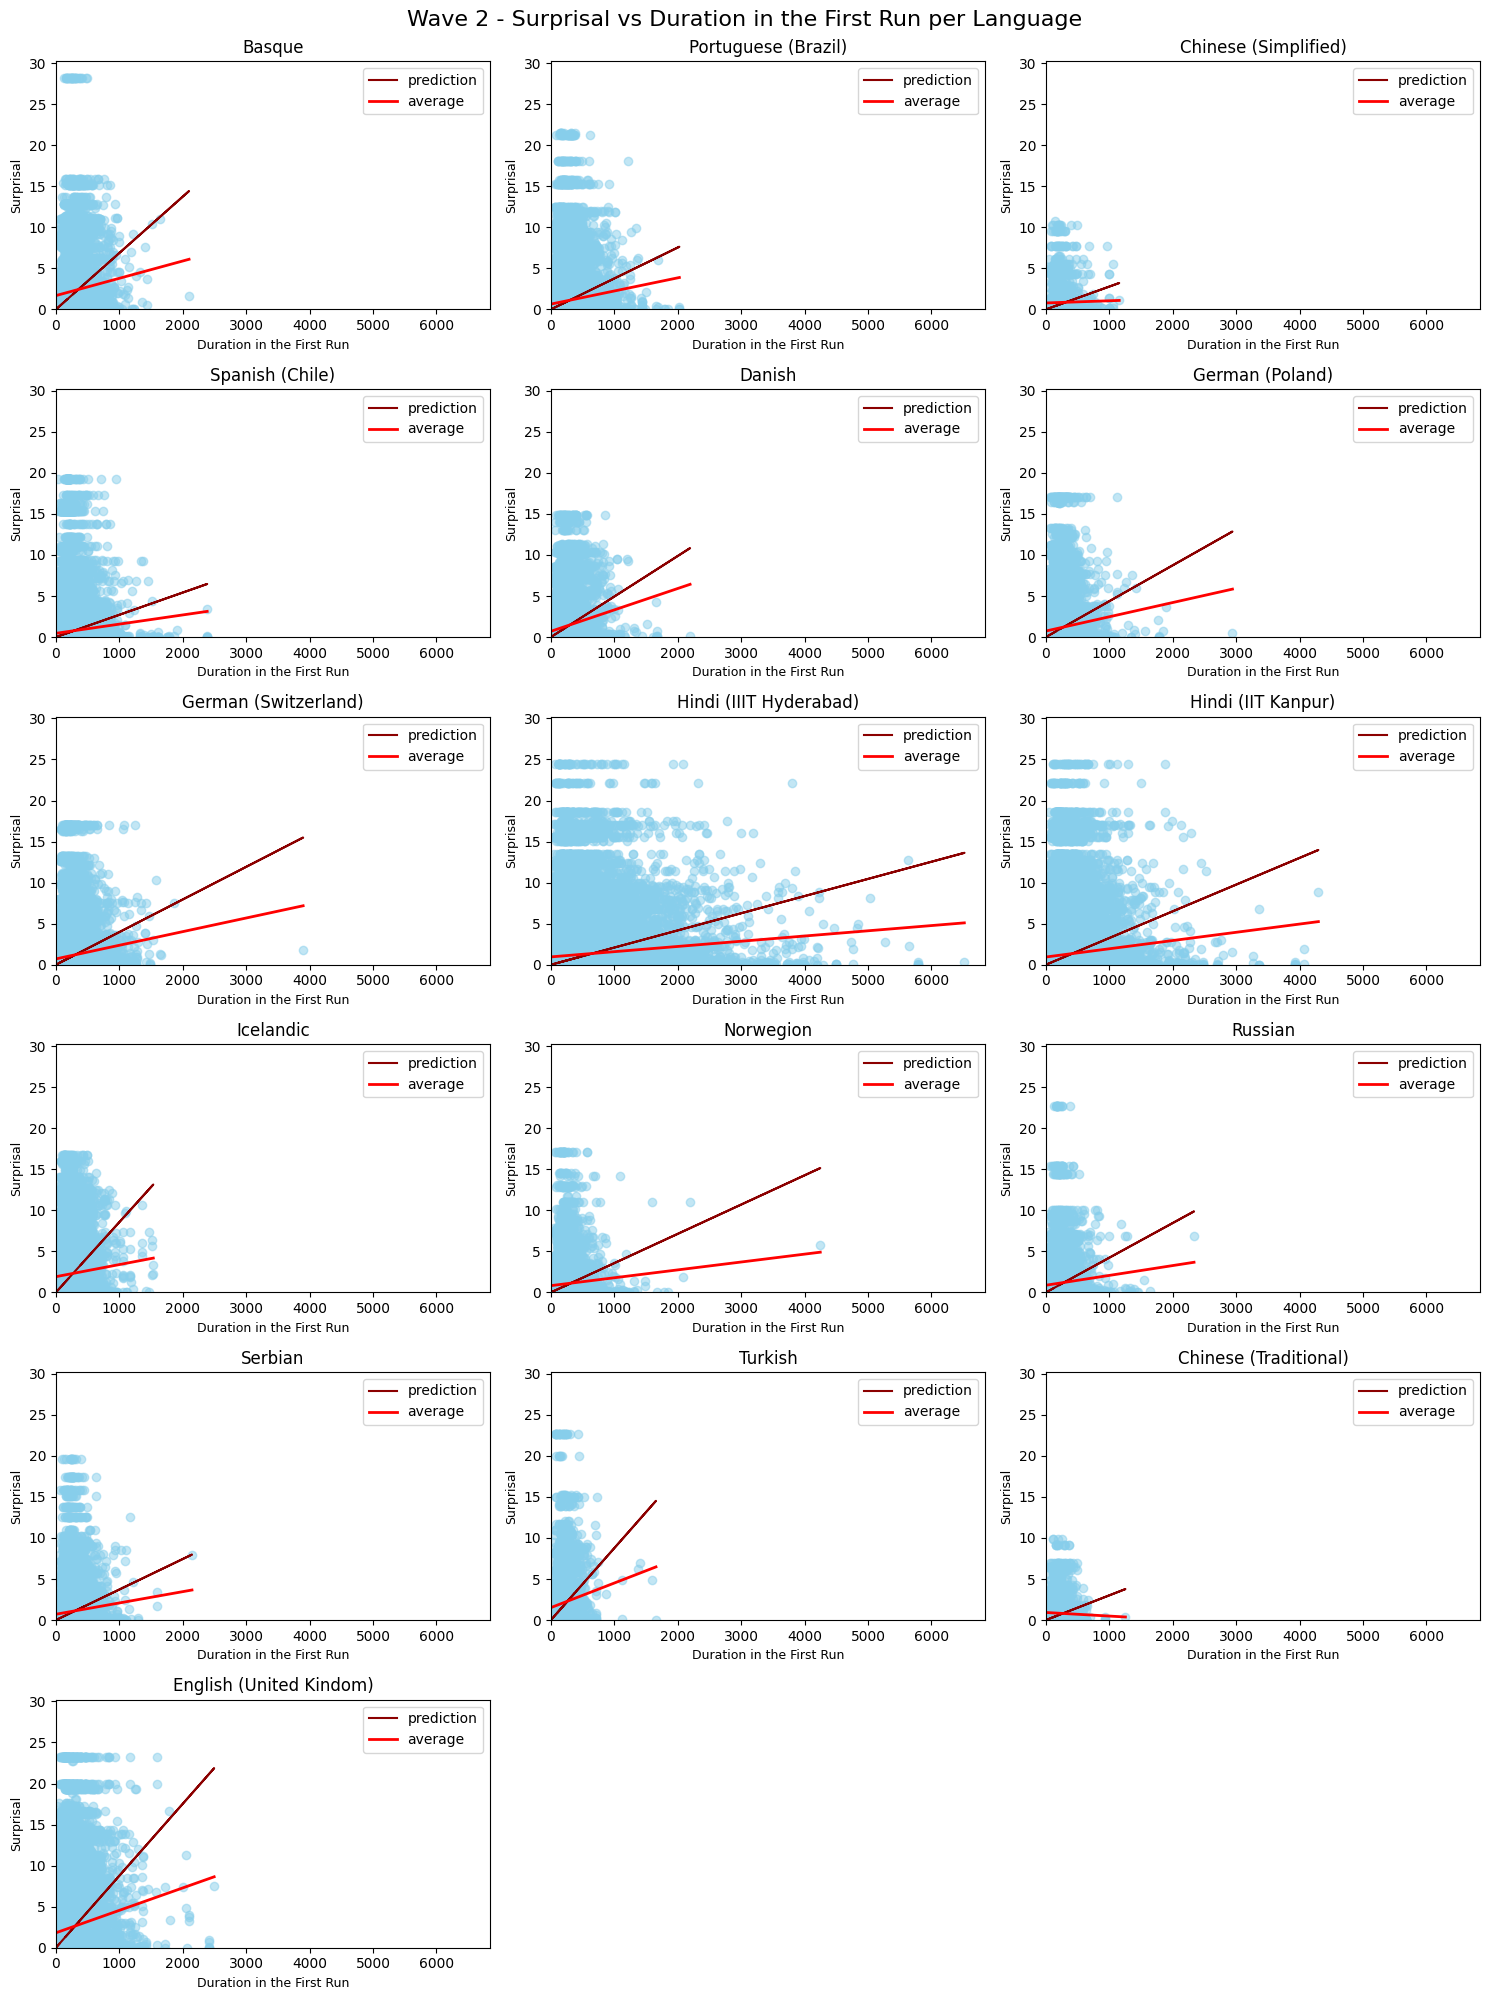

In [ ]:
scatter_plot_per_language(wave2_dict, wave2_languages, languages, wave2_OLS, 'firstrun.dur', 'Duration in the First Run', 2)

### Go-Past Time in the First Run

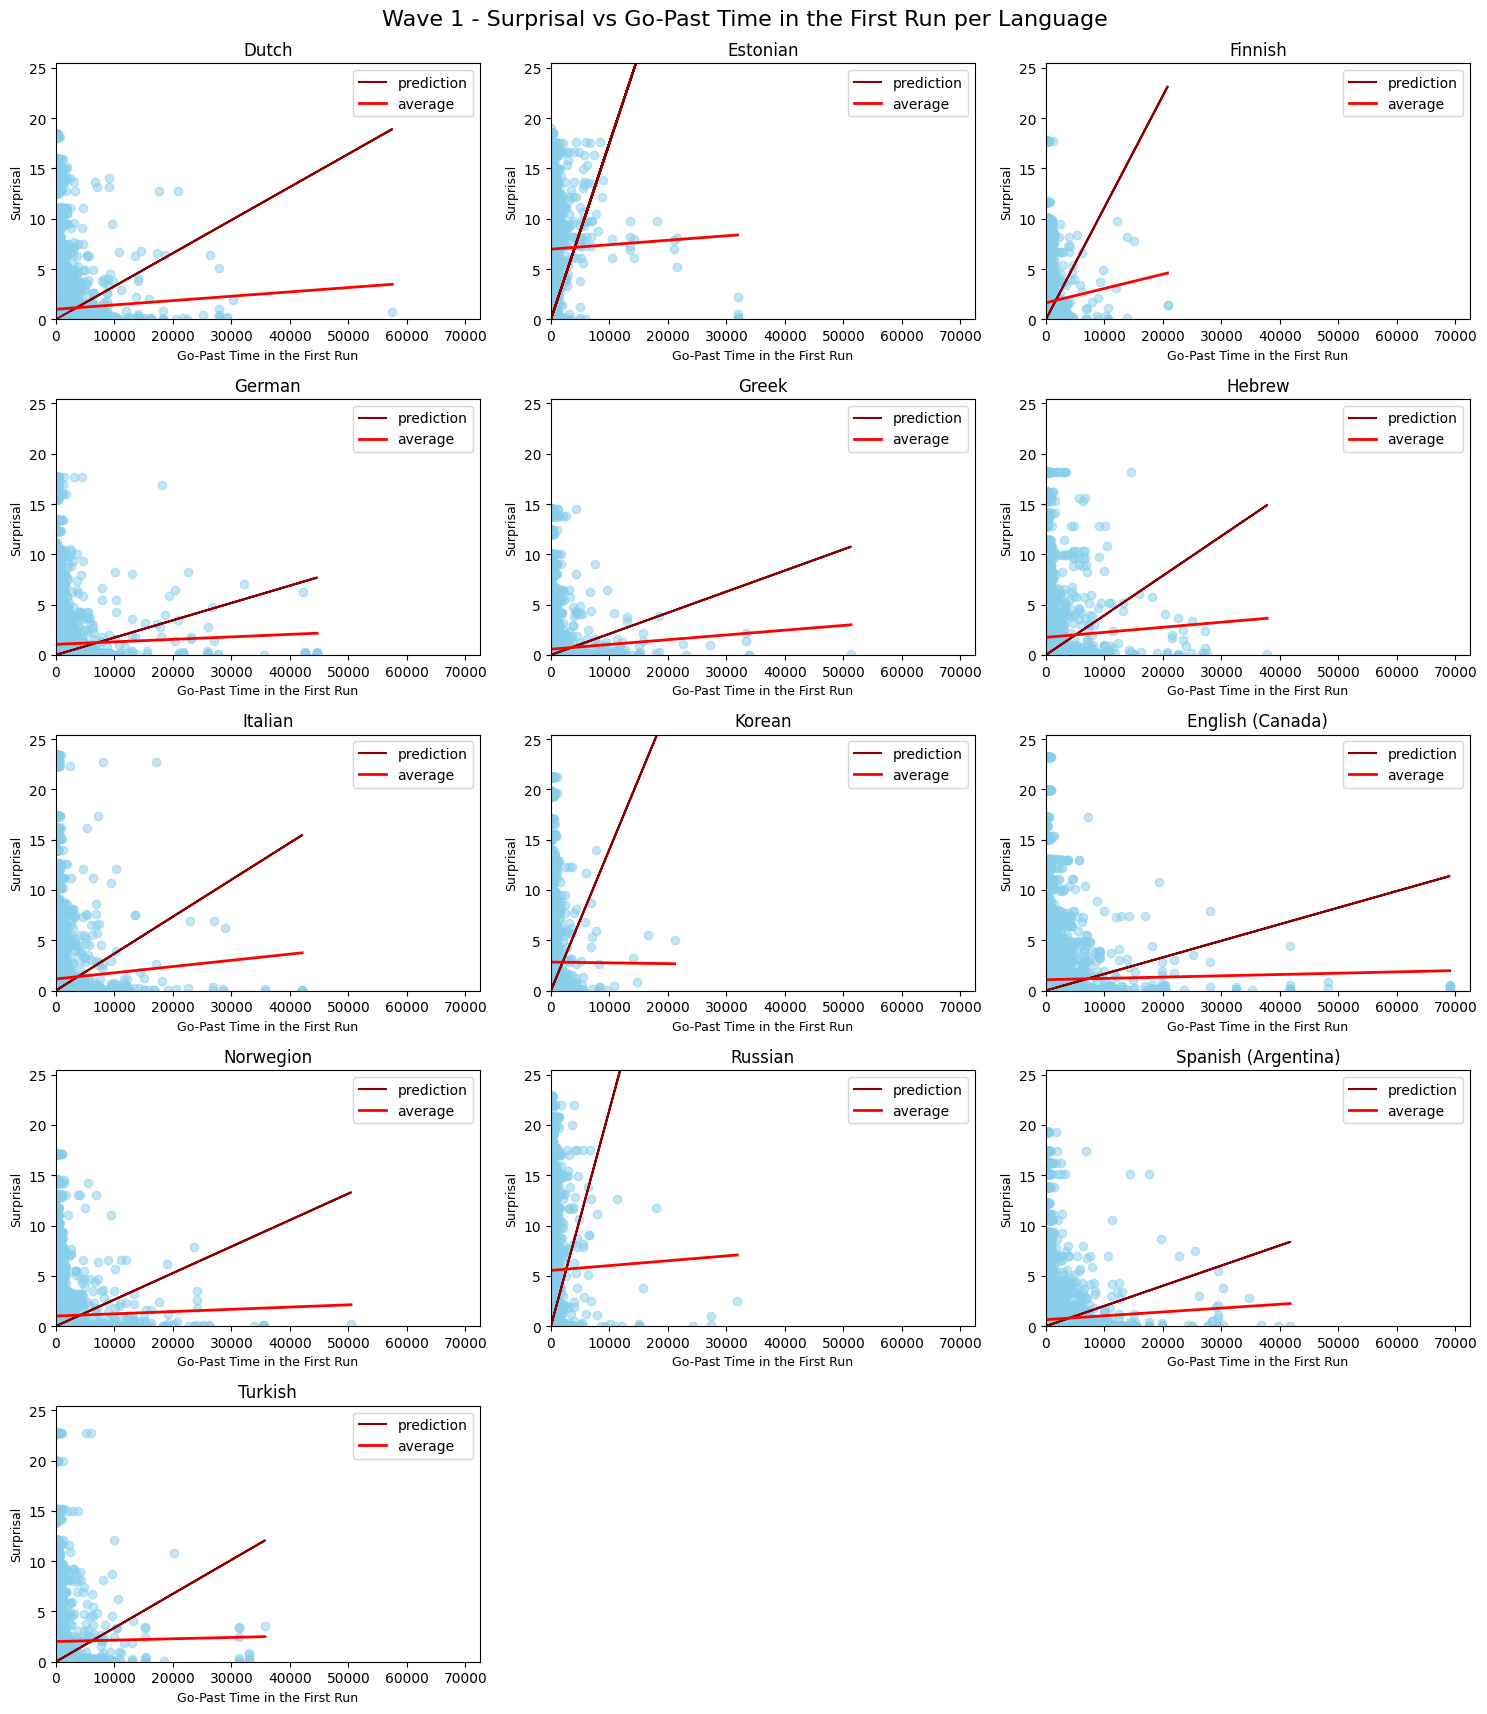

In [ ]:
scatter_plot_per_language(wave1_dict, wave1_languages, languages, wave1_OLS, 'firstrun.gopast', 'Go-Past Time in the First Run', 1)

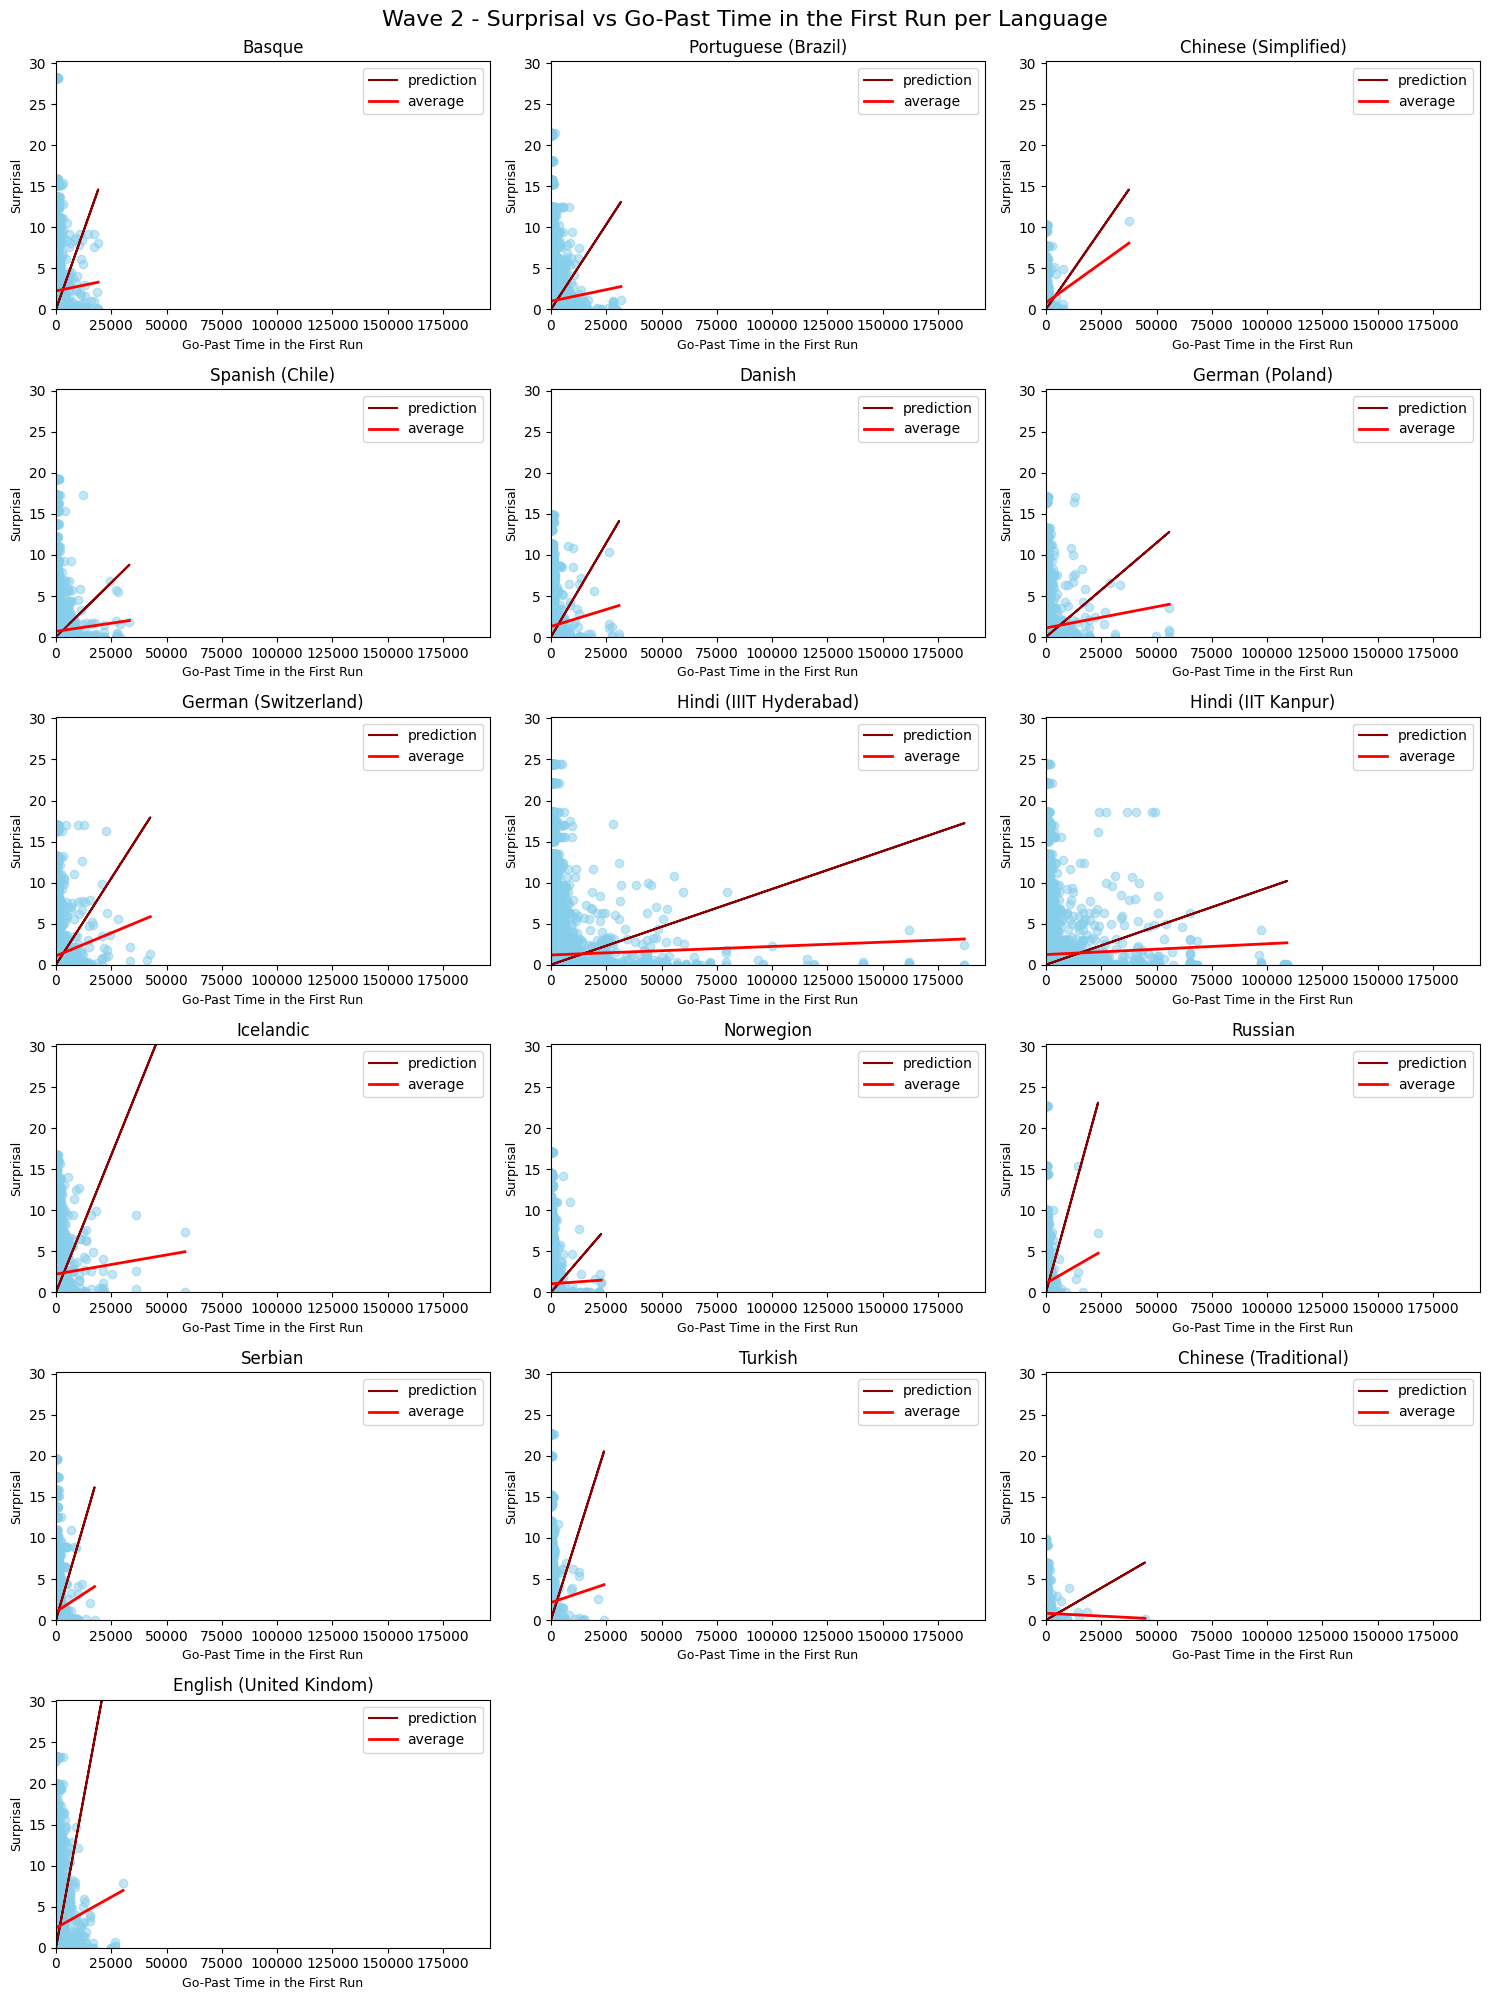

In [ ]:
scatter_plot_per_language(wave2_dict, wave2_languages, languages, wave2_OLS, 'firstrun.gopast', 'Go-Past Time in the First Run', 2)

### Selective Go-Past Time in the First Run

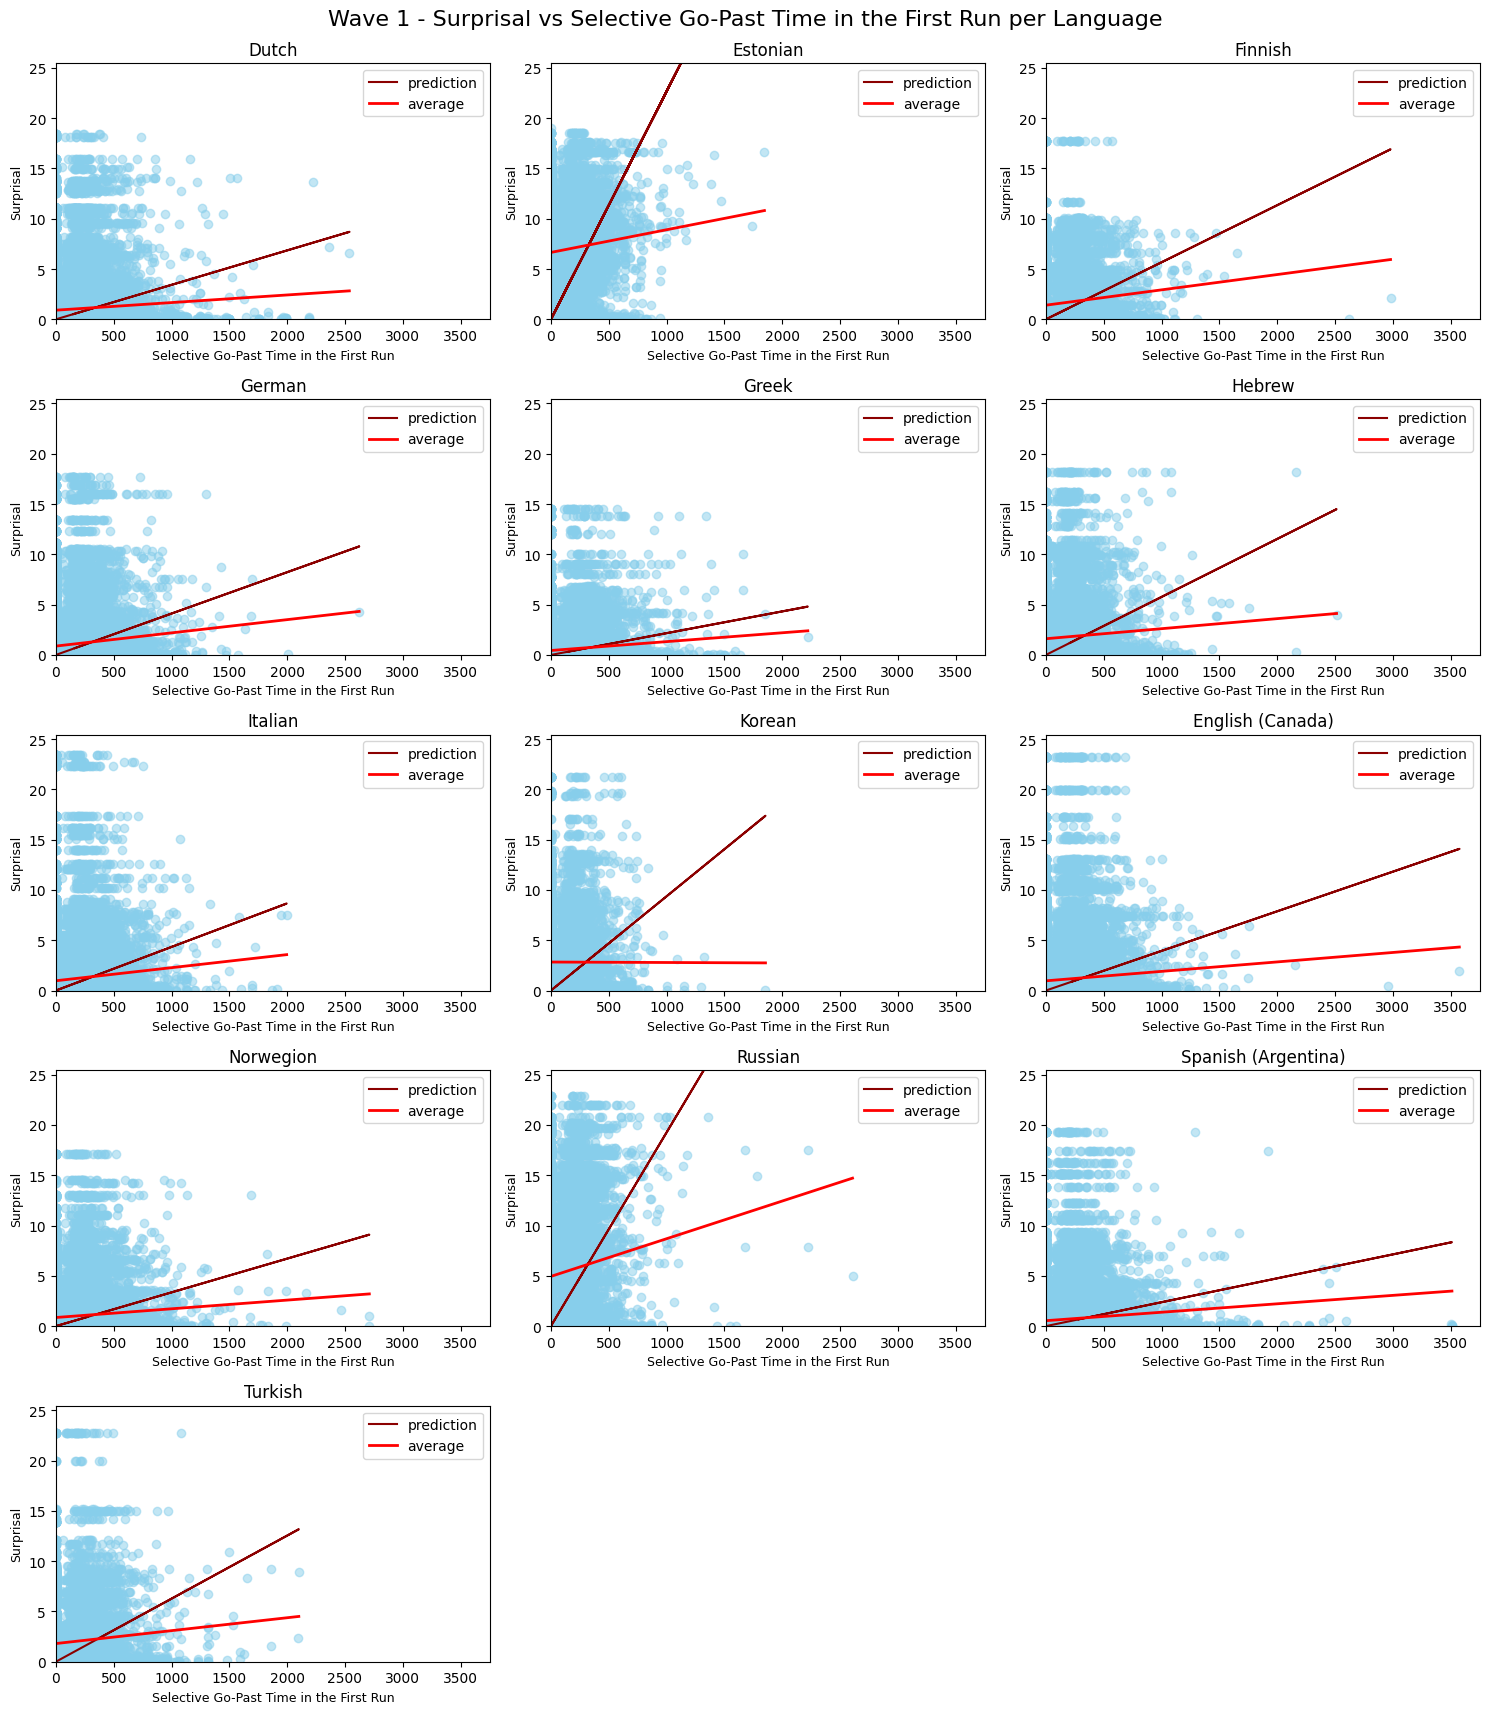

In [ ]:
scatter_plot_per_language(wave1_dict, wave1_languages, languages, wave1_OLS, 'firstrun.gopast.sel', 'Selective Go-Past Time in the First Run', 1)

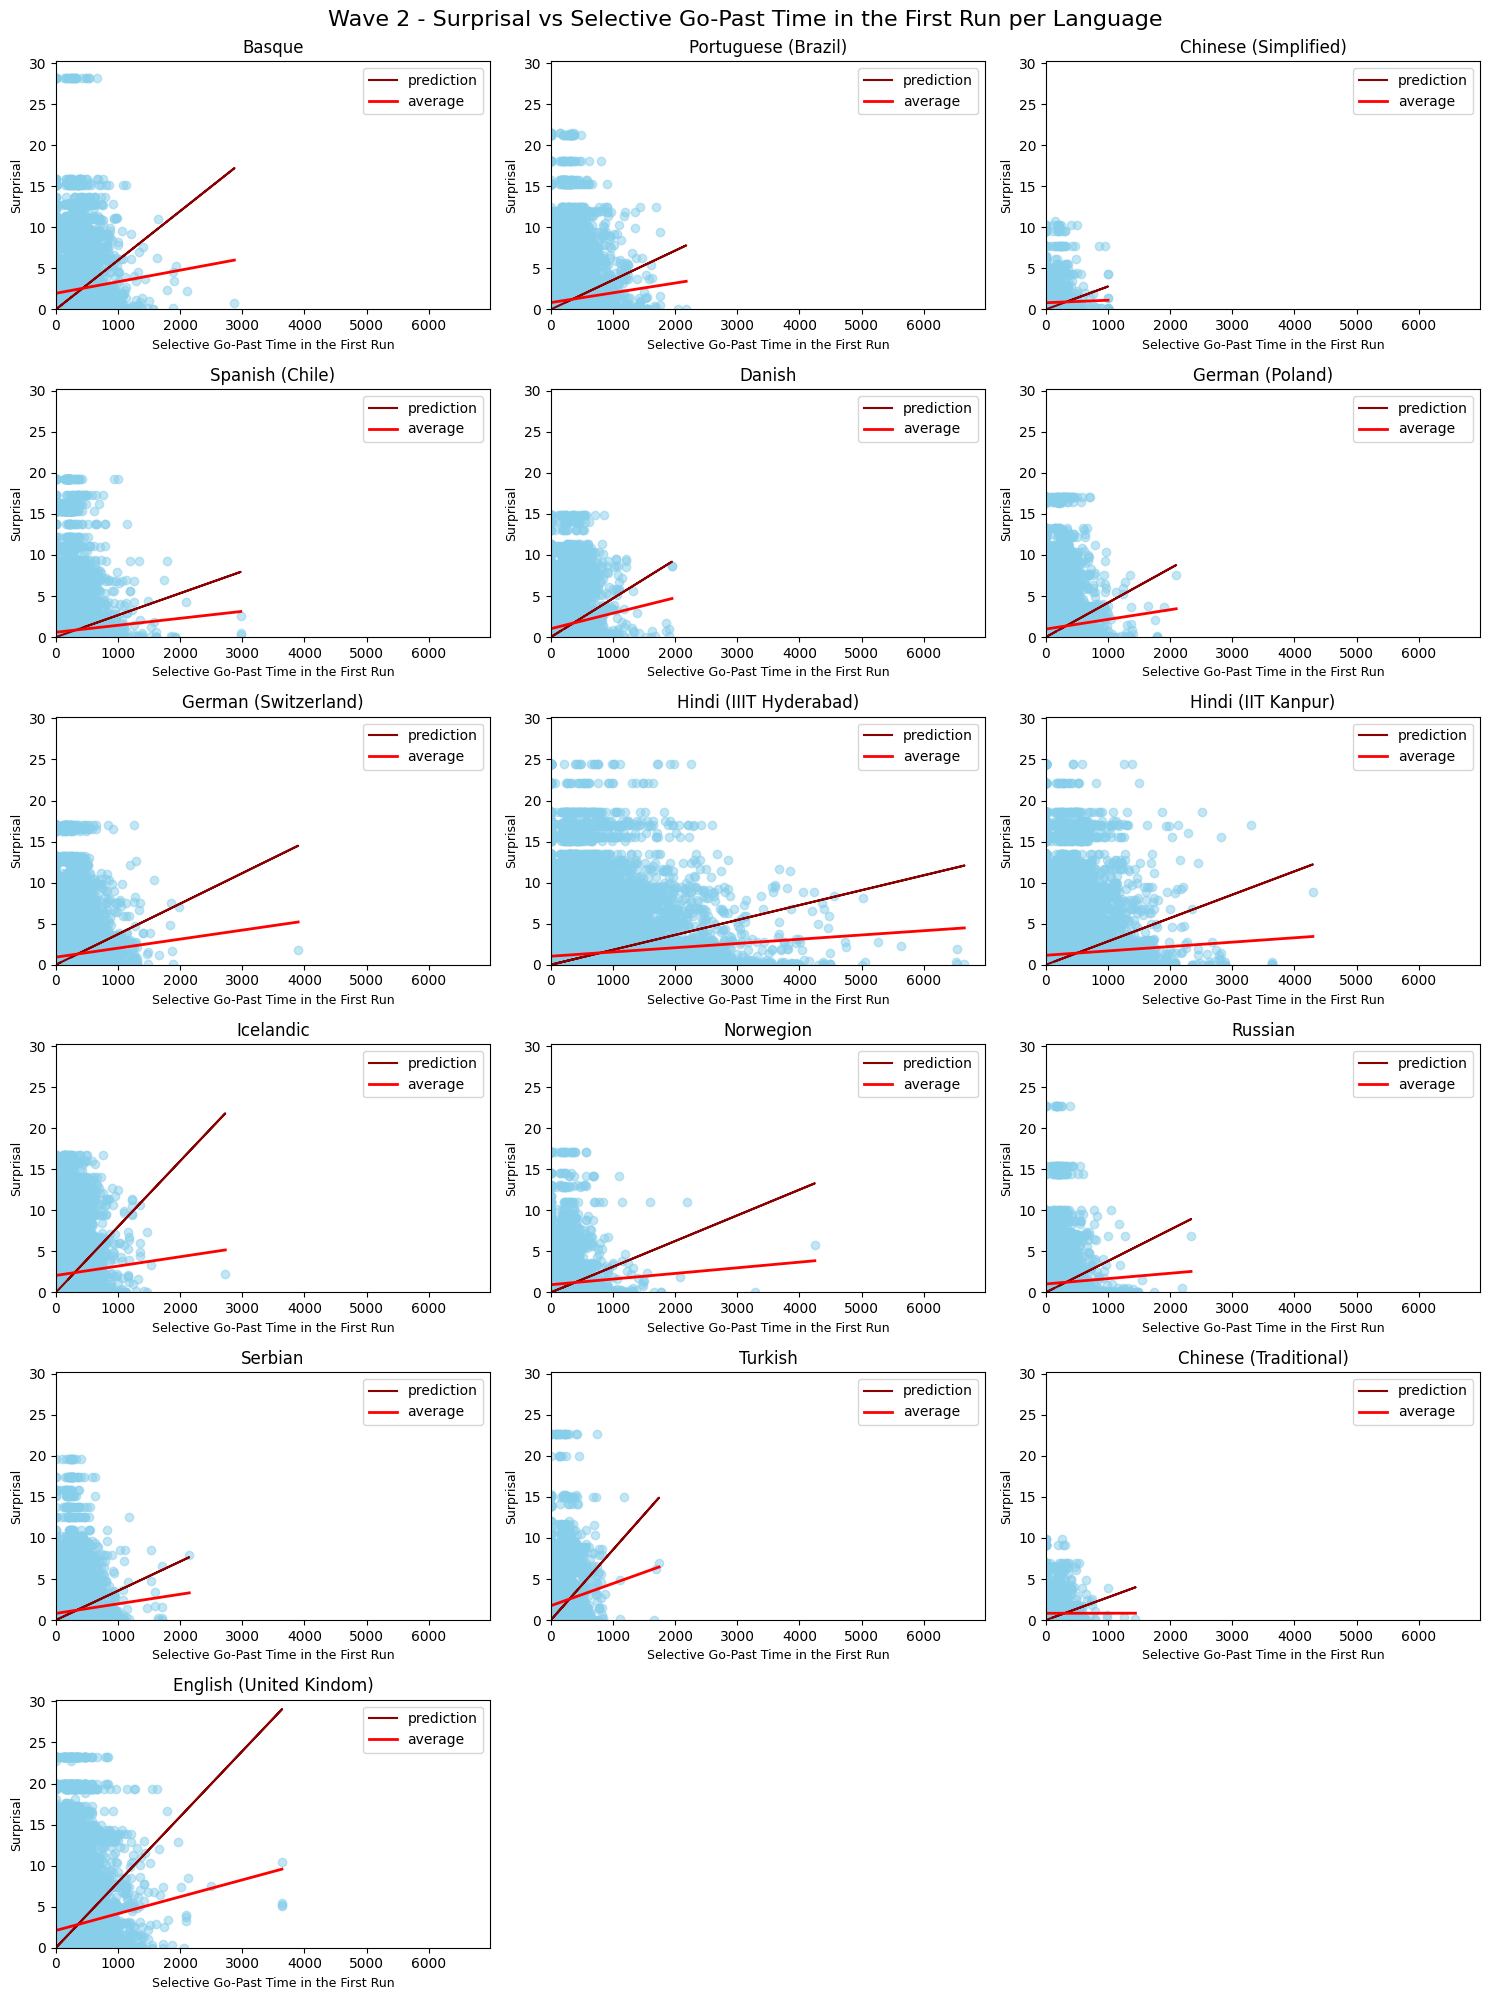

In [ ]:
scatter_plot_per_language(wave2_dict, wave2_languages, languages, wave2_OLS, 'firstrun.gopast.sel', 'Selective Go-Past Time in the First Run', 2)

### Incoming Sacade Length in the First Fixation

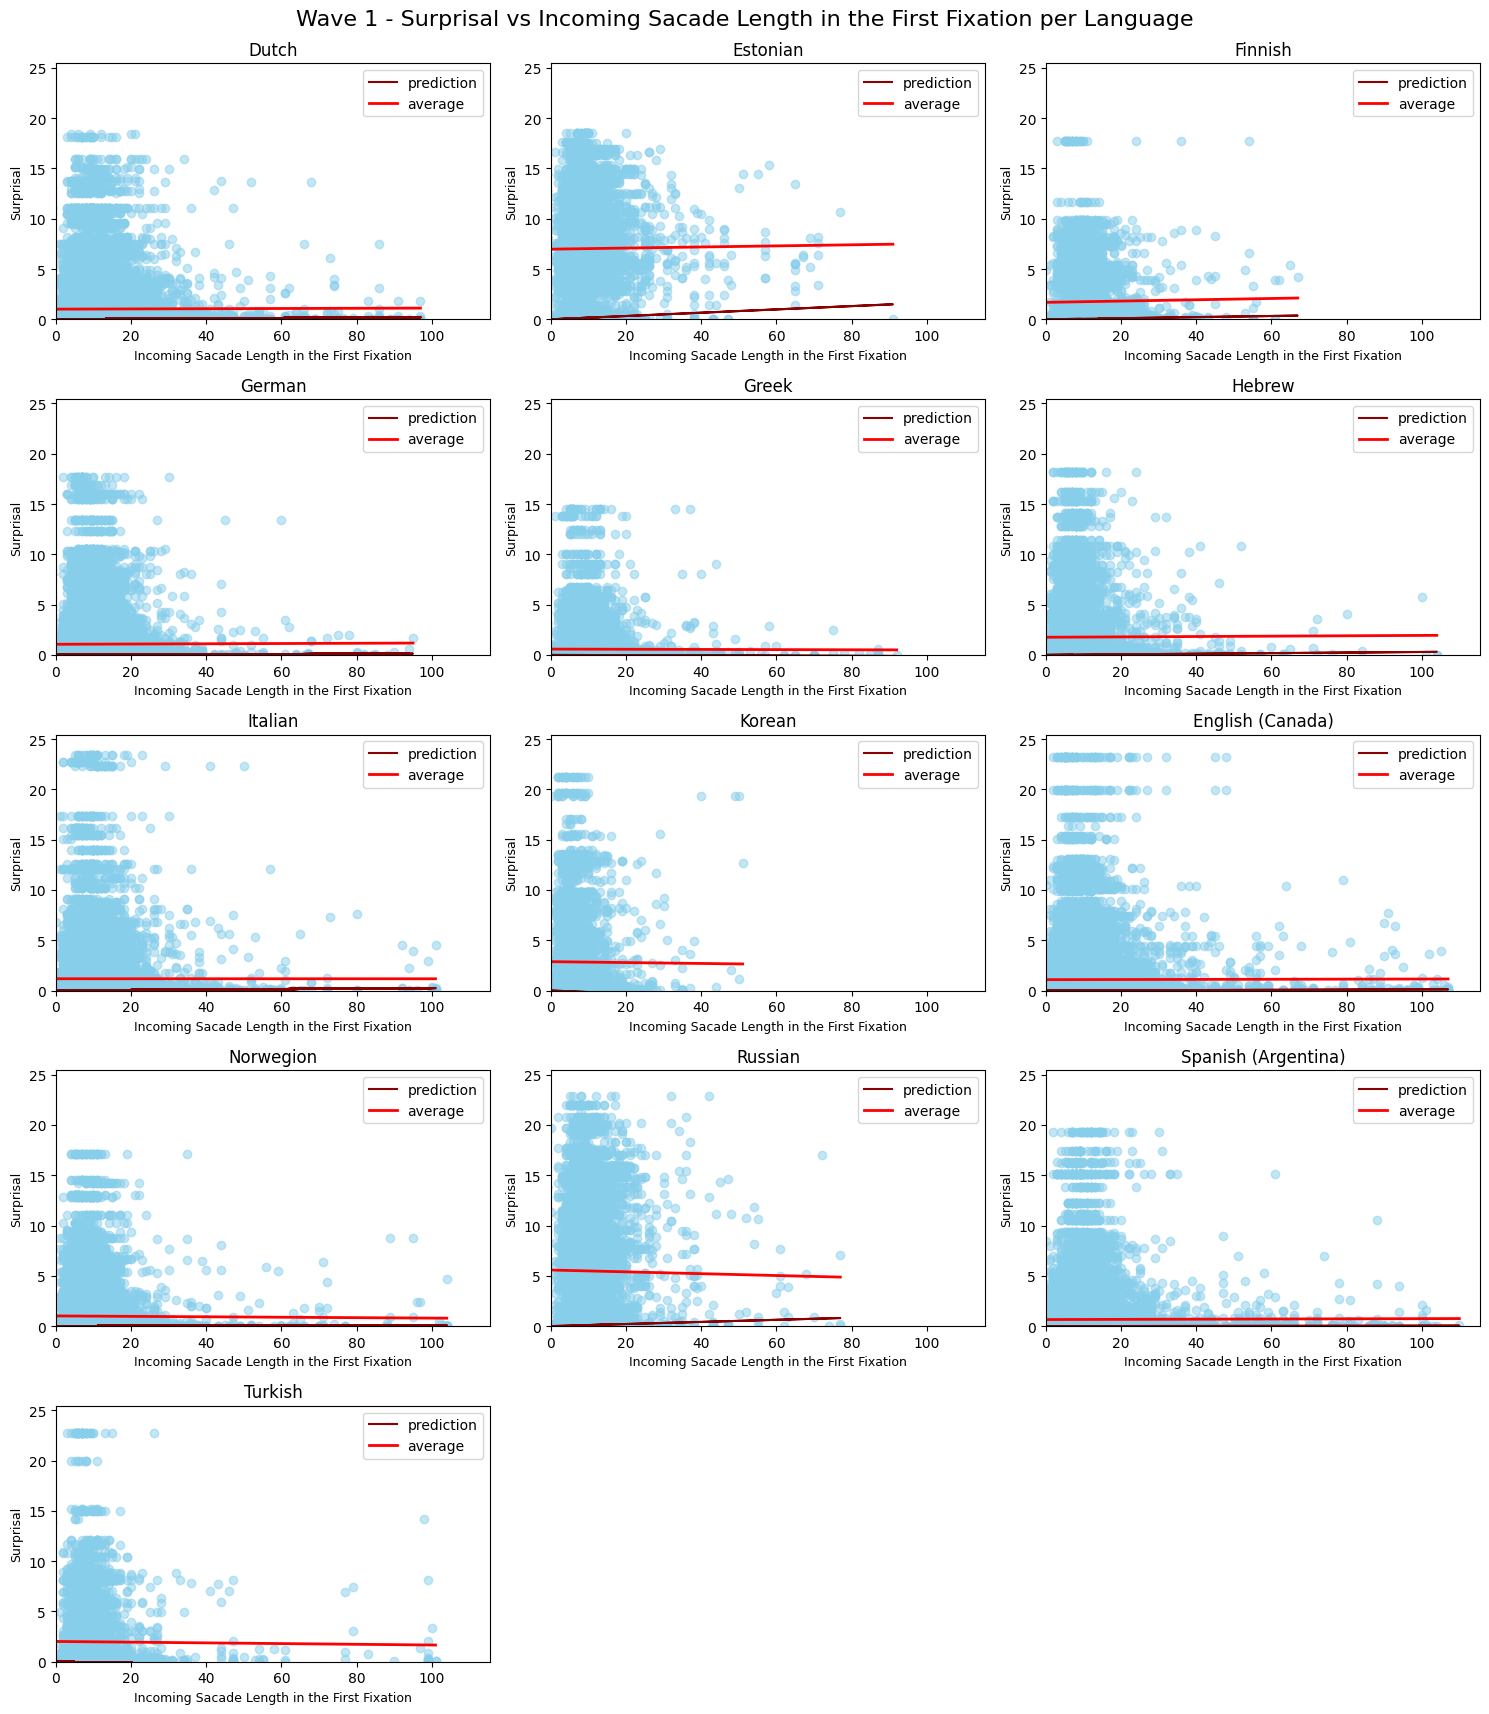

In [ ]:
scatter_plot_per_language(wave1_dict, wave1_languages, languages, wave1_OLS, 'firstfix.sac.in', 'Incoming Sacade Length in the First Fixation', 1)

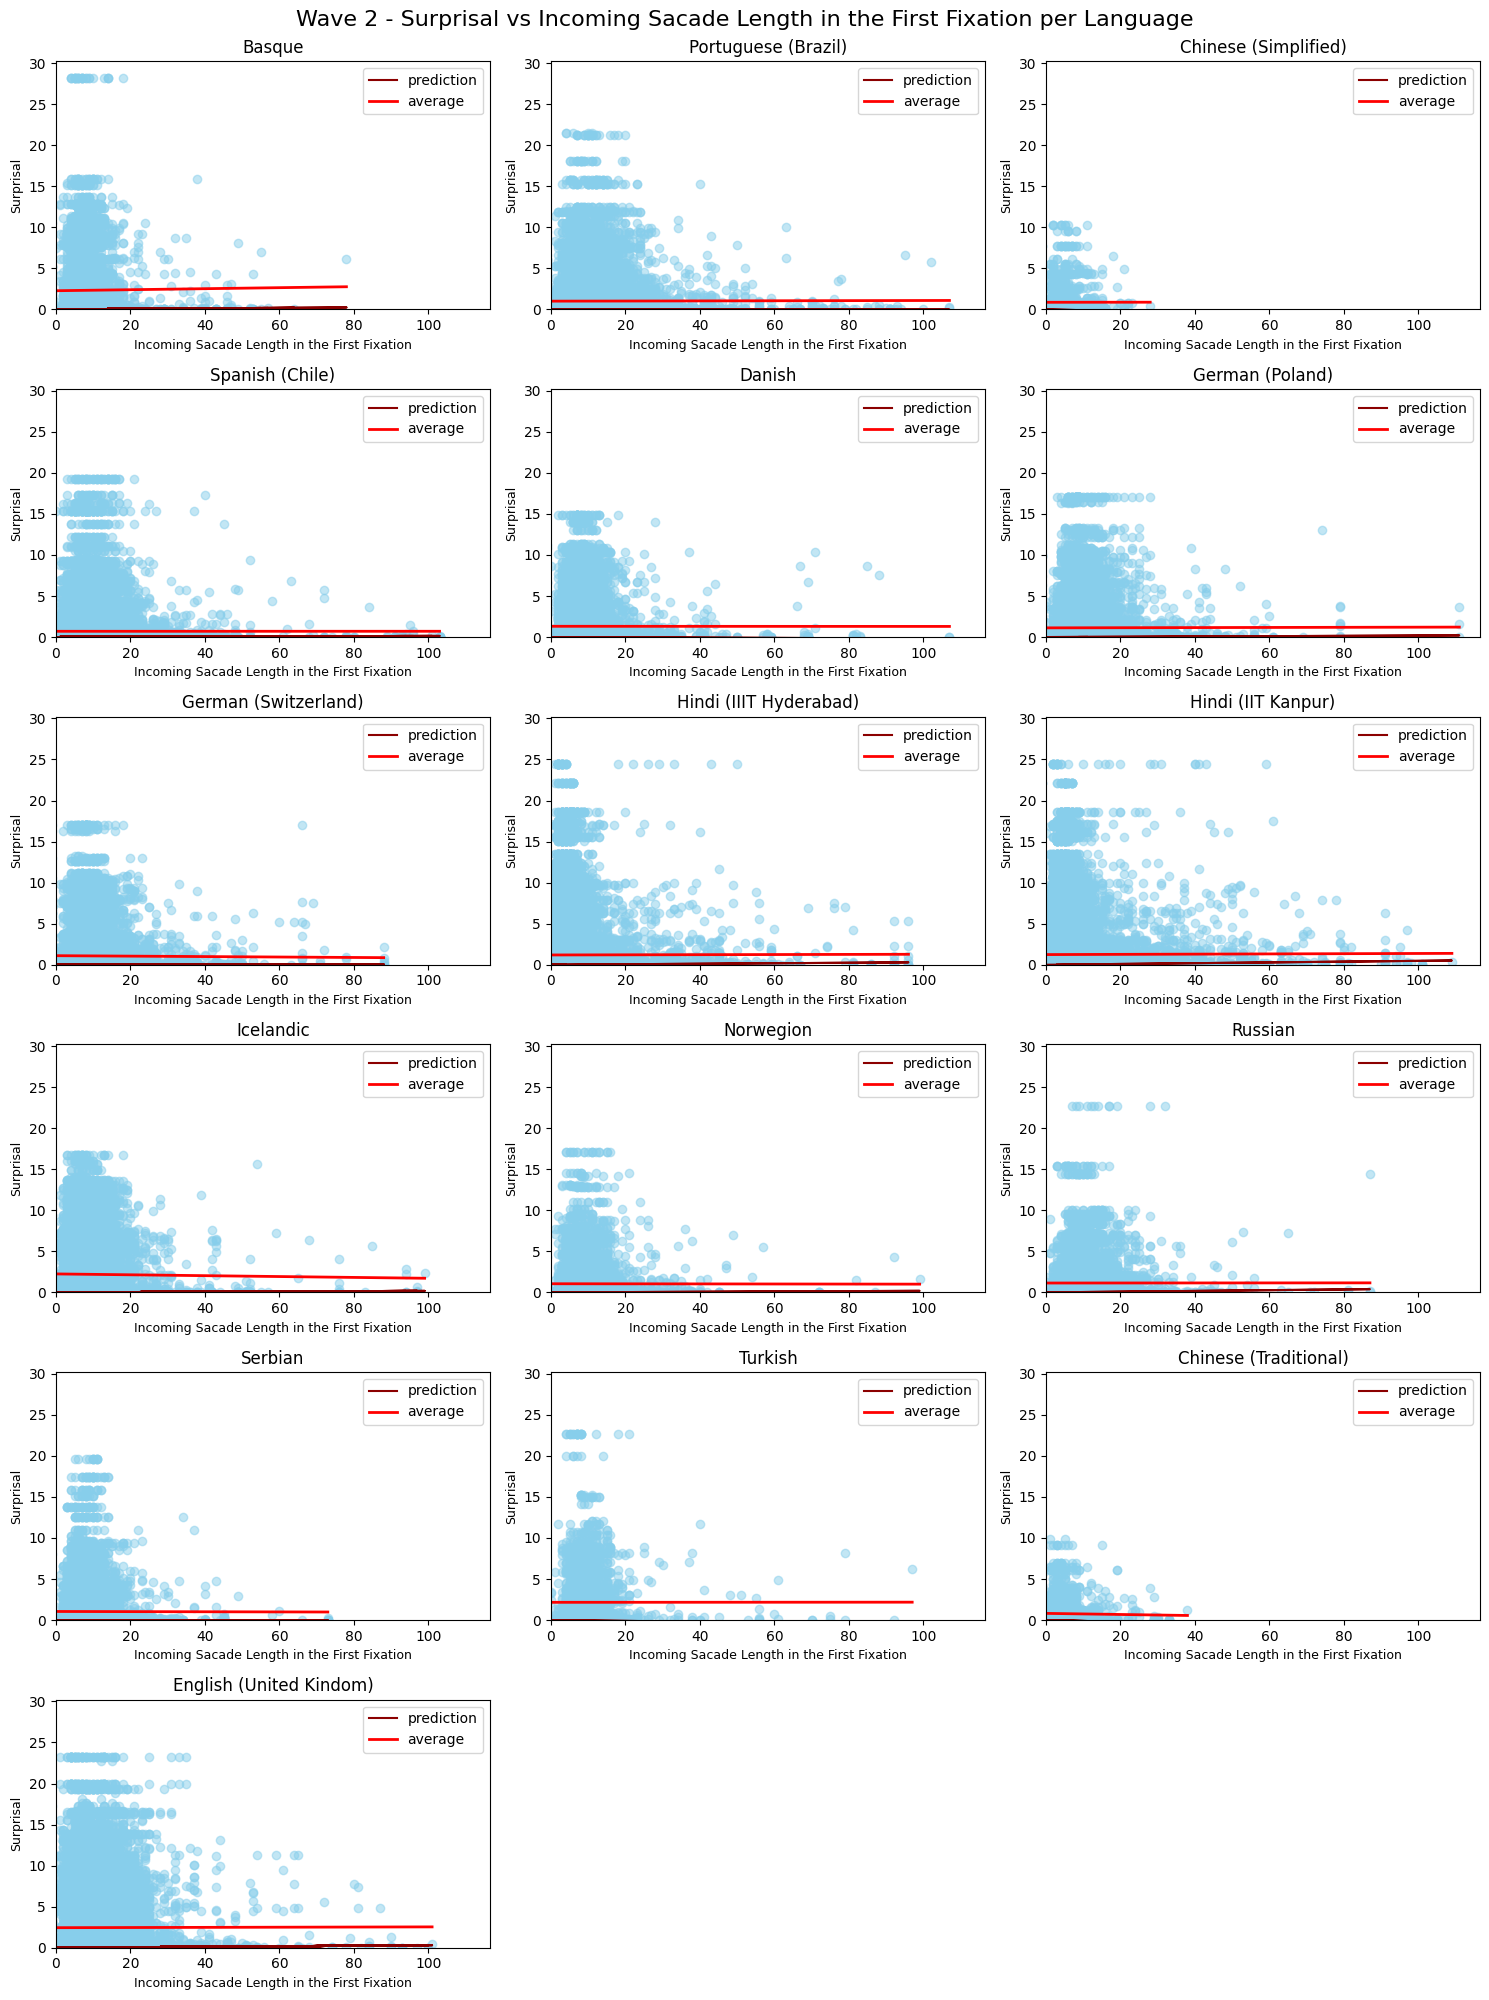

In [ ]:
scatter_plot_per_language(wave2_dict, wave2_languages, languages, wave2_OLS, 'firstfix.sac.in', 'Incoming Sacade Length in the First Fixation', 2)

### Outgoing Sacade Length in the First Fixation

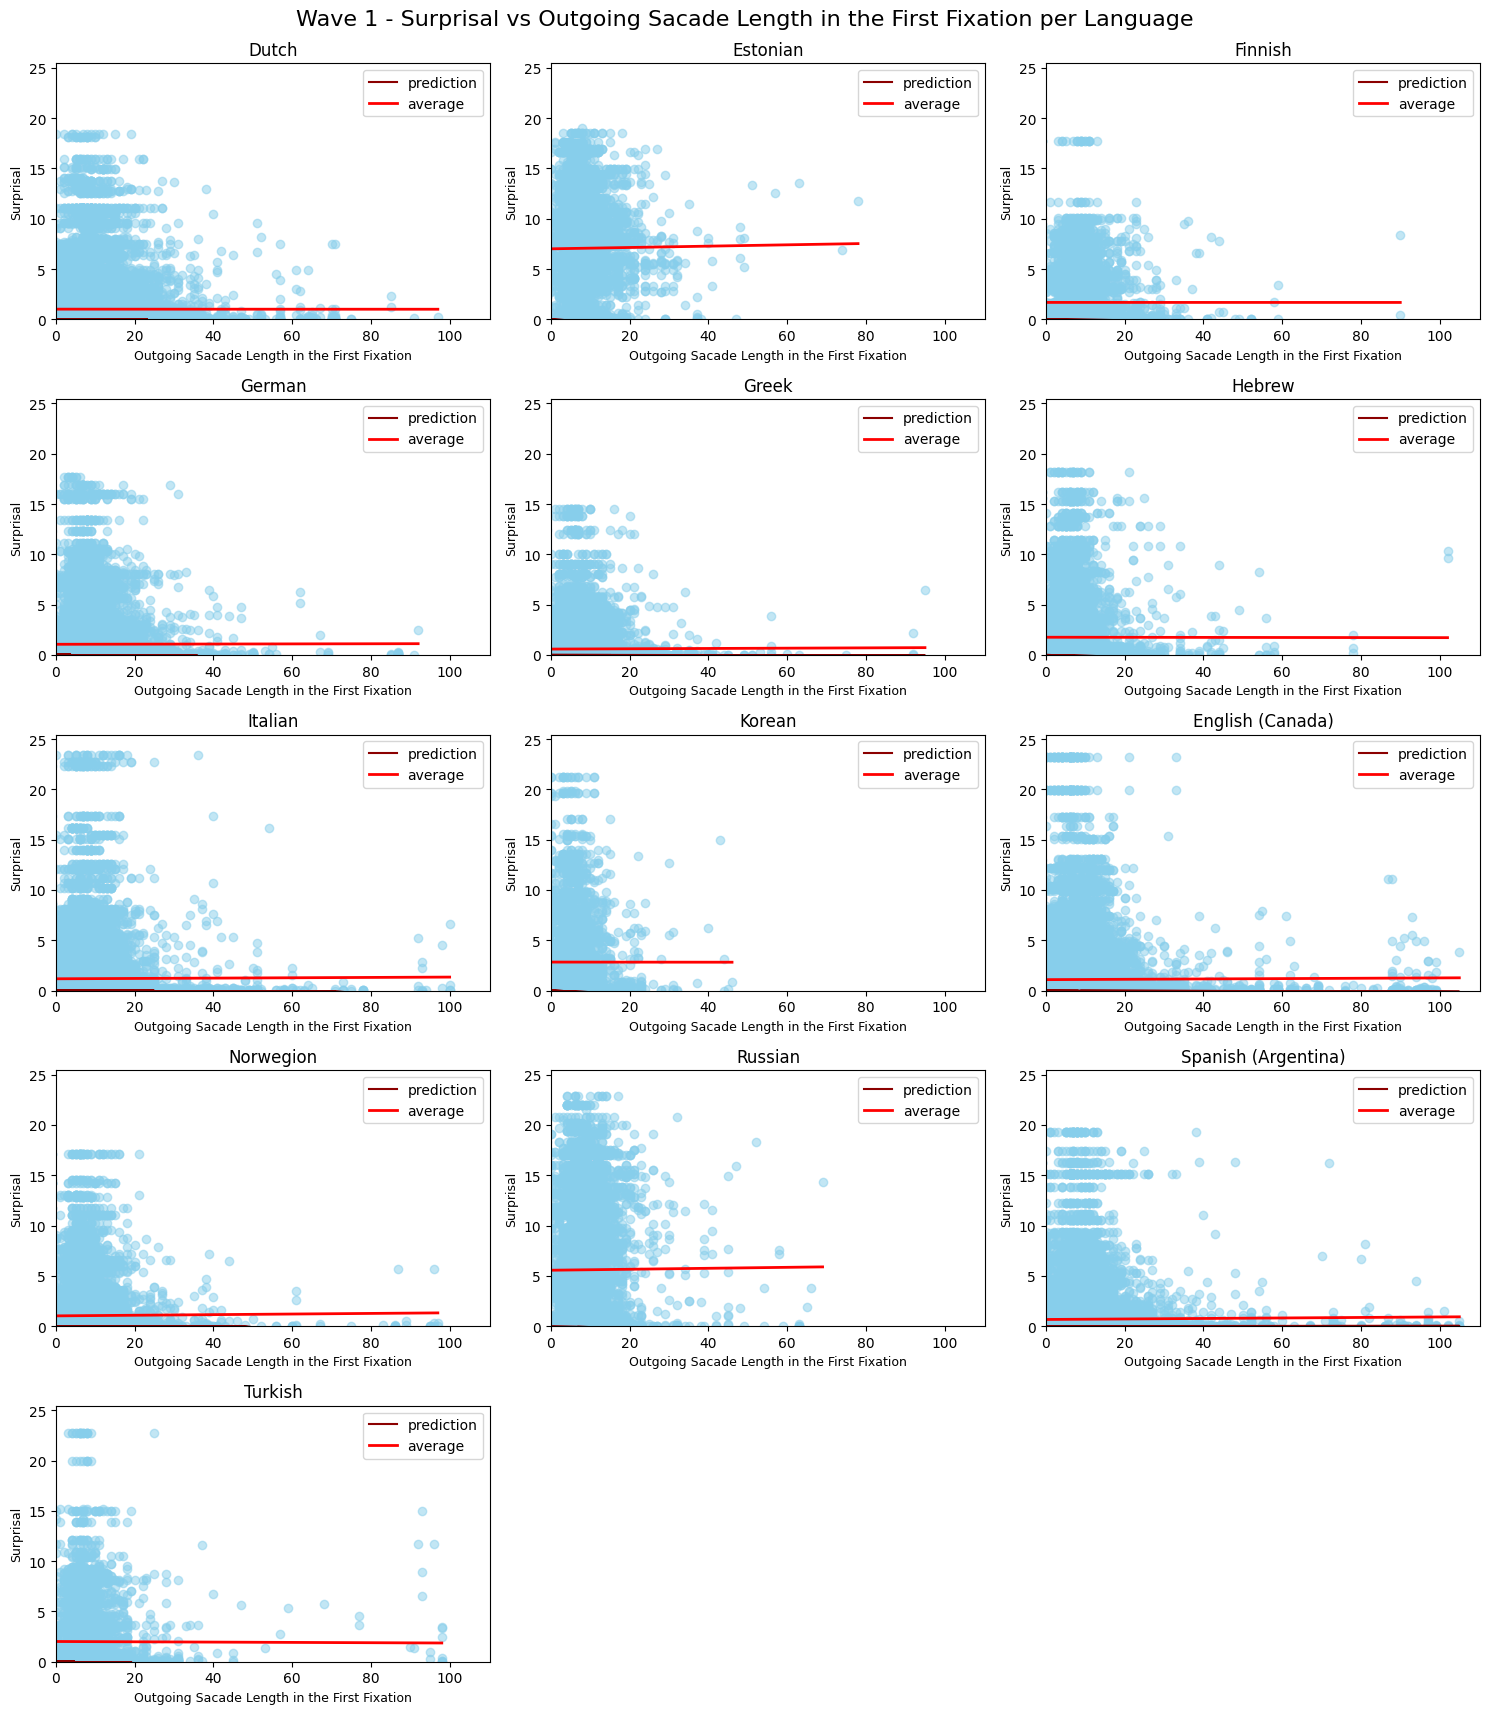

In [ ]:
scatter_plot_per_language(wave1_dict, wave1_languages, languages, wave1_OLS, 'firstfix.sac.out', 'Outgoing Sacade Length in the First Fixation', 1)

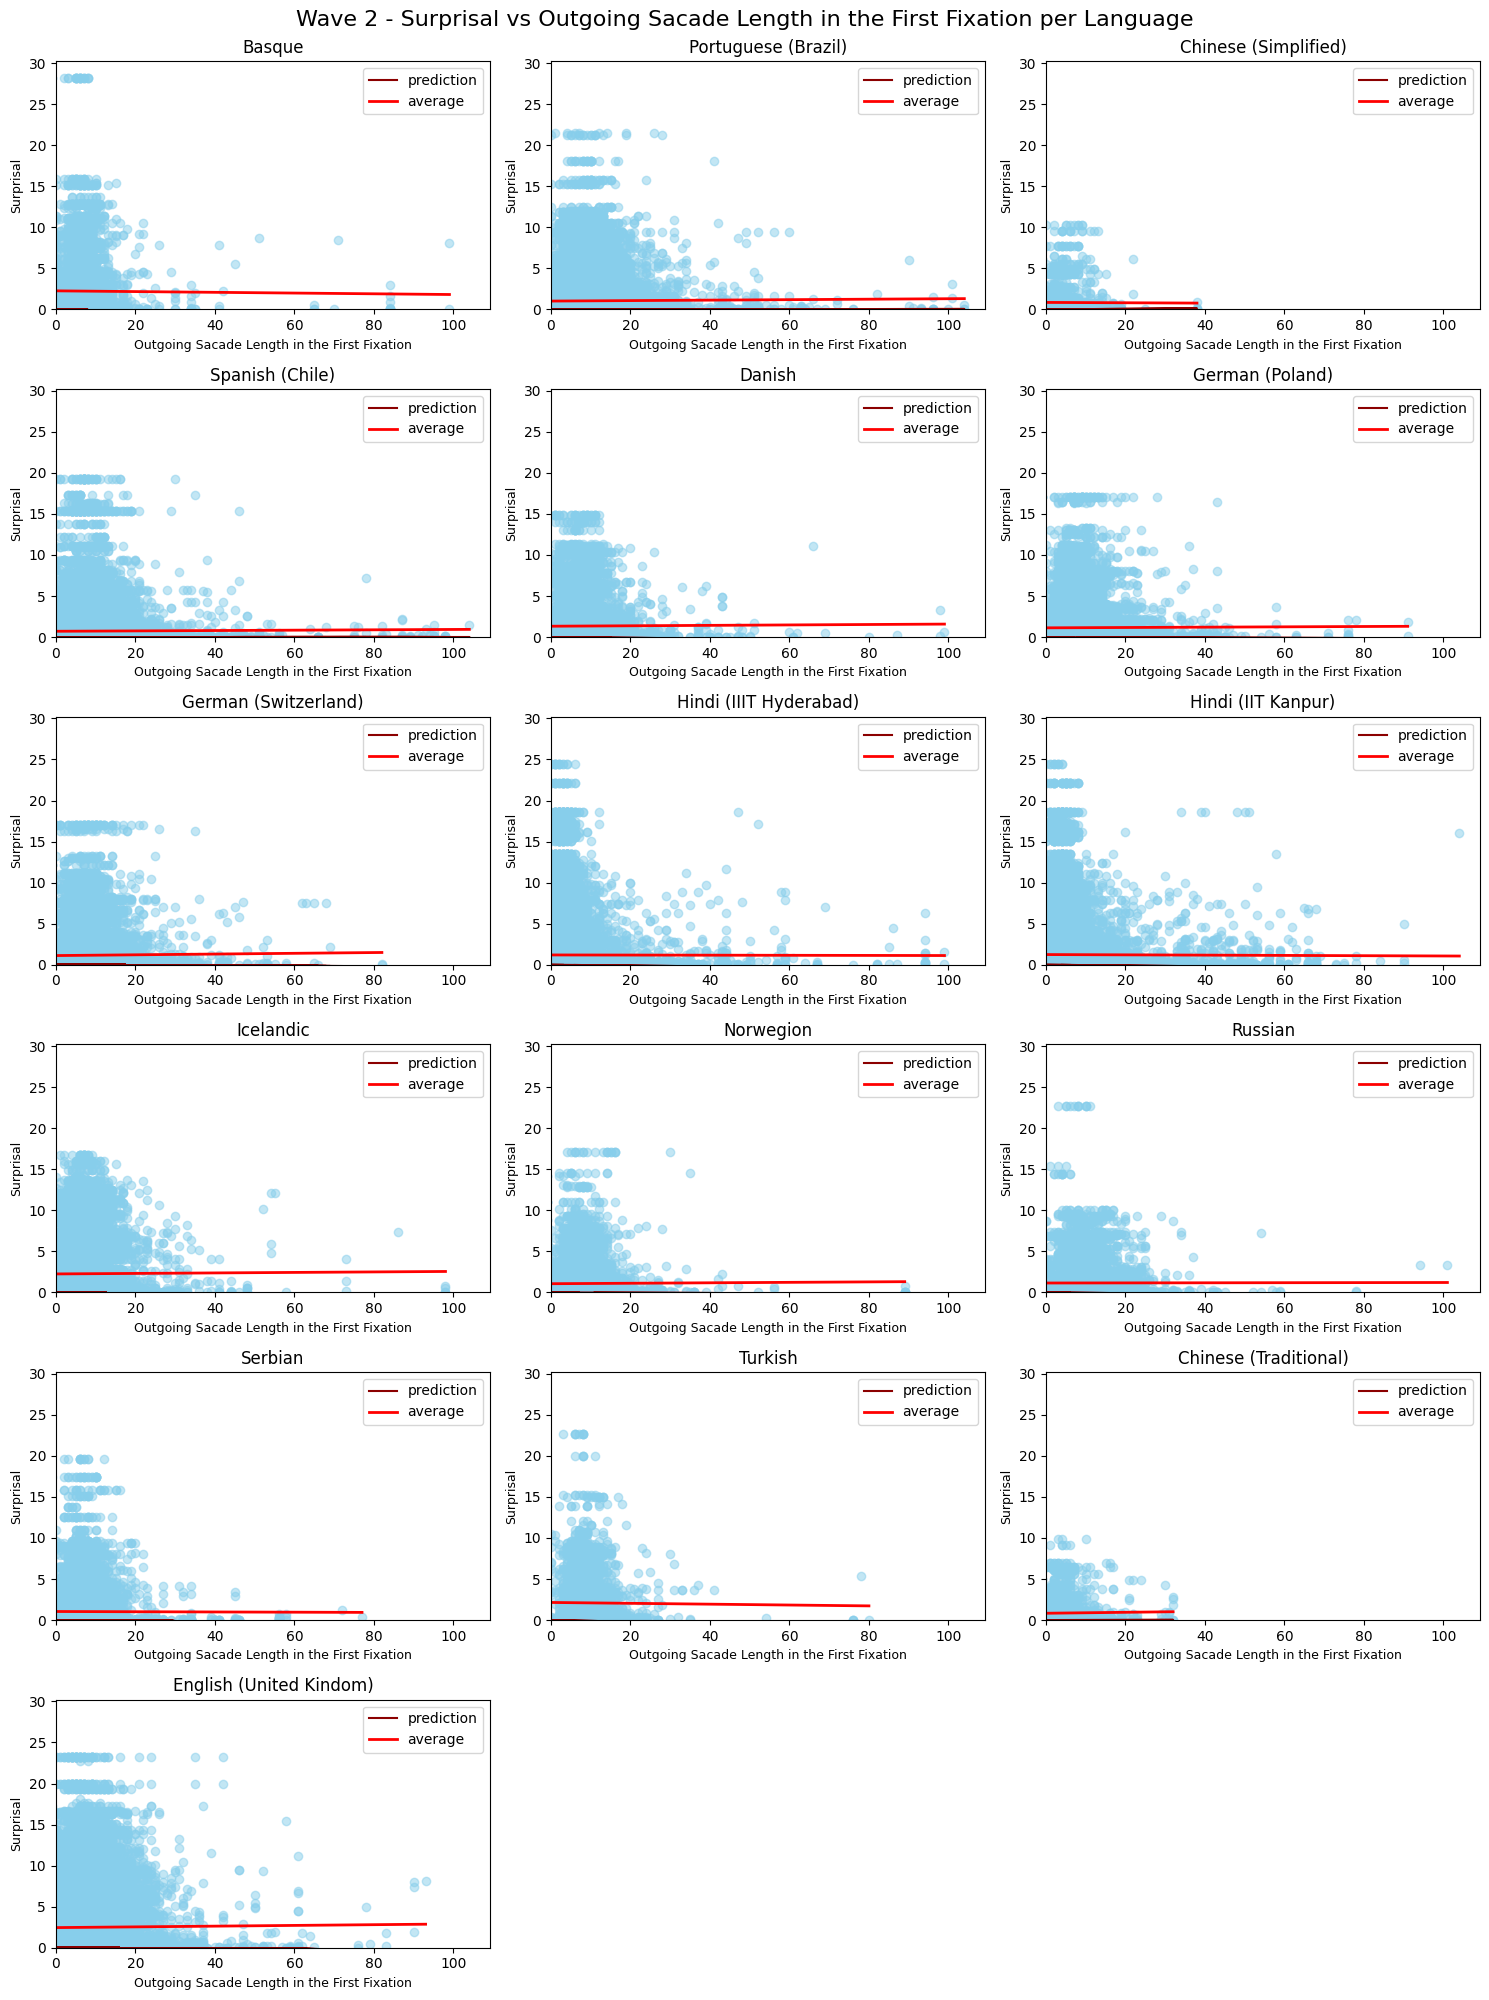

In [ ]:
scatter_plot_per_language(wave2_dict, wave2_languages, languages, wave2_OLS, 'firstfix.sac.out', 'Outgoing Sacade Length in the First Fixation', 2)

### Duration in the First Fixation

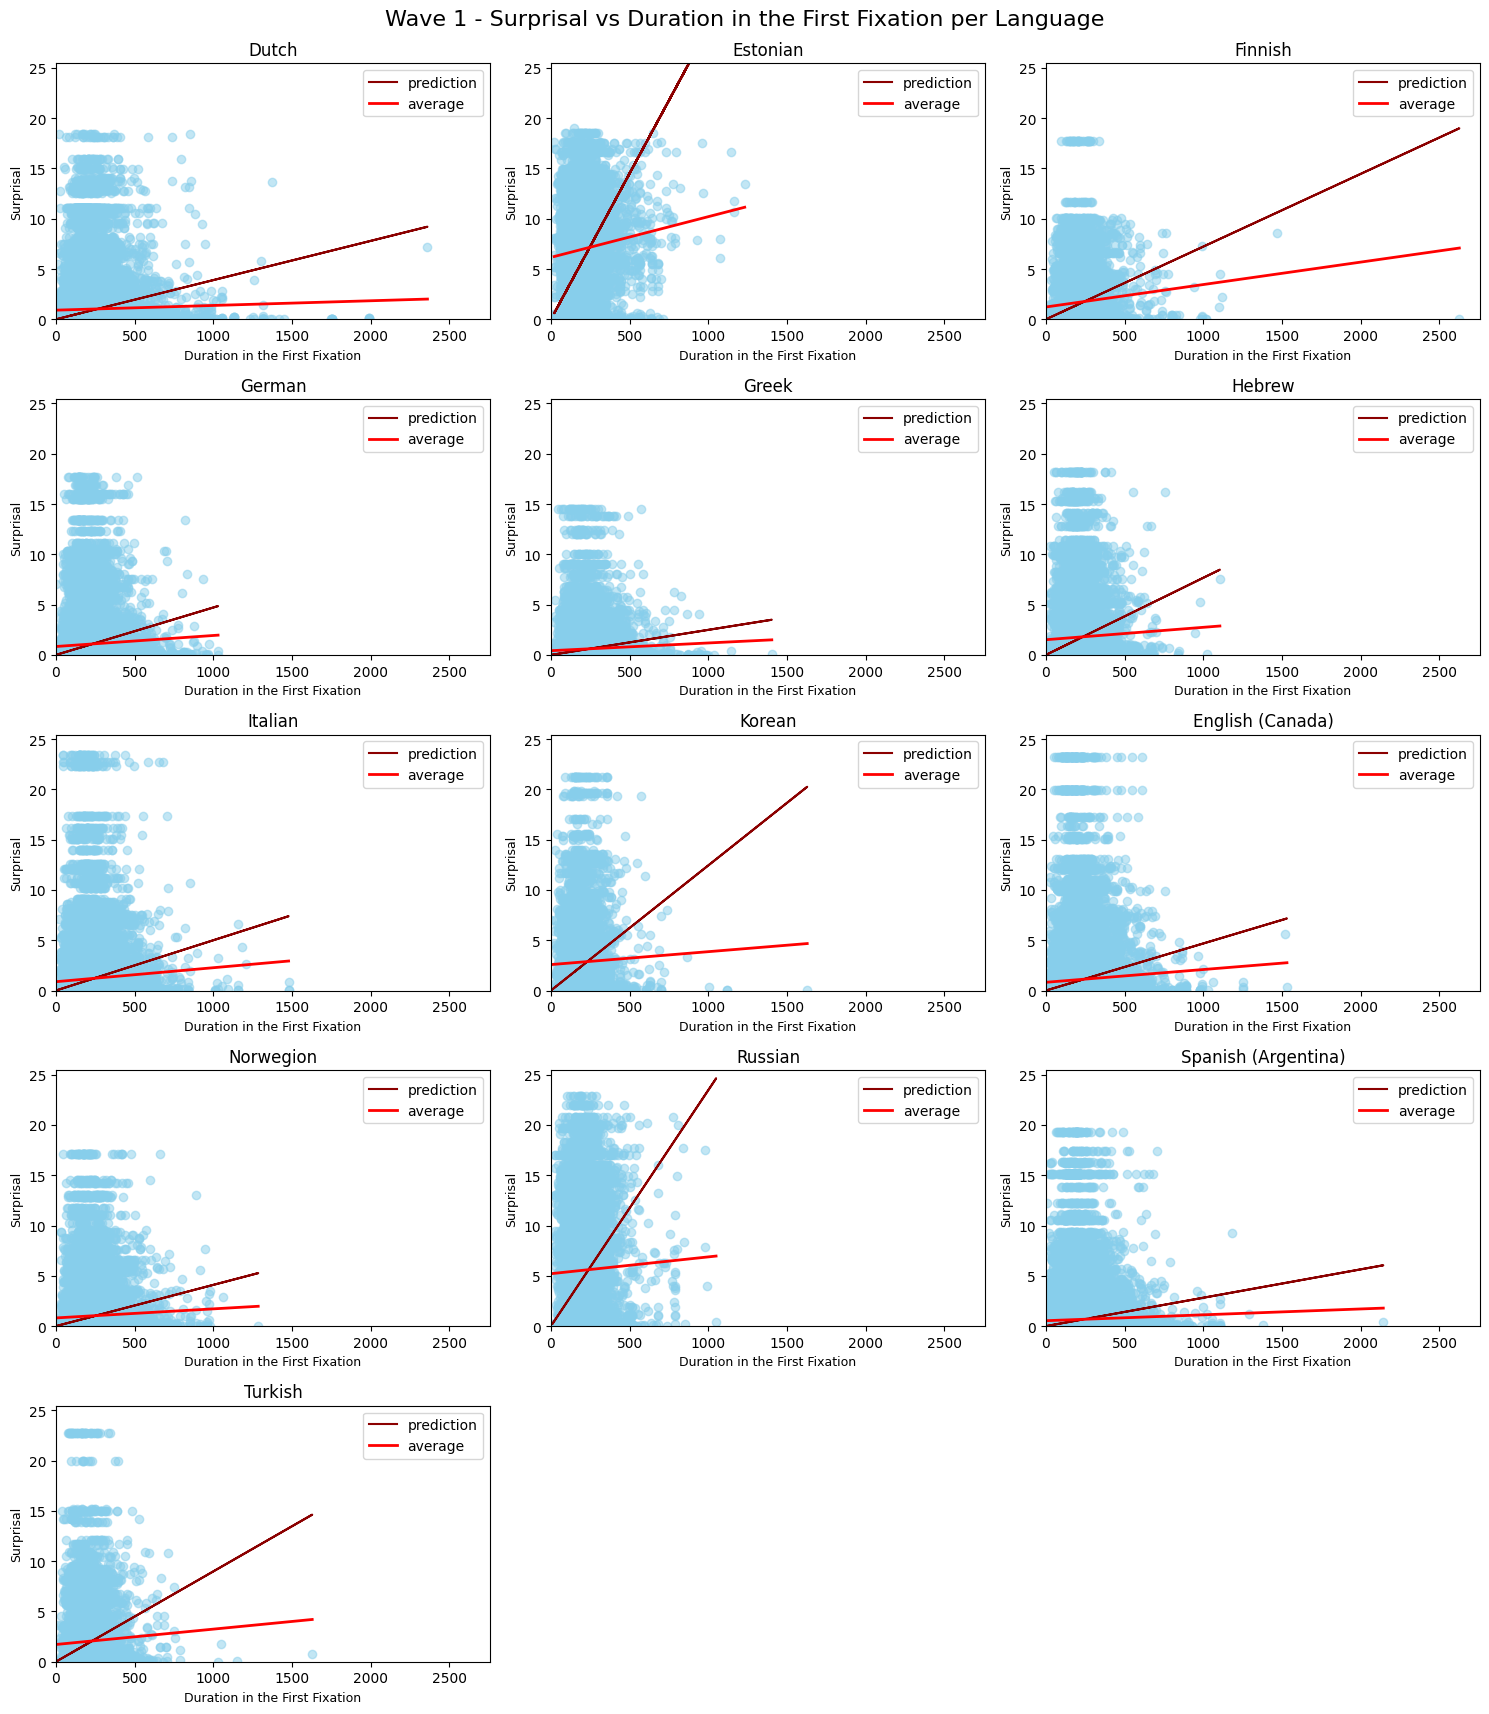

In [ ]:
scatter_plot_per_language(wave1_dict, wave1_languages, languages, wave1_OLS, 'firstfix.dur', 'Duration in the First Fixation', 1)

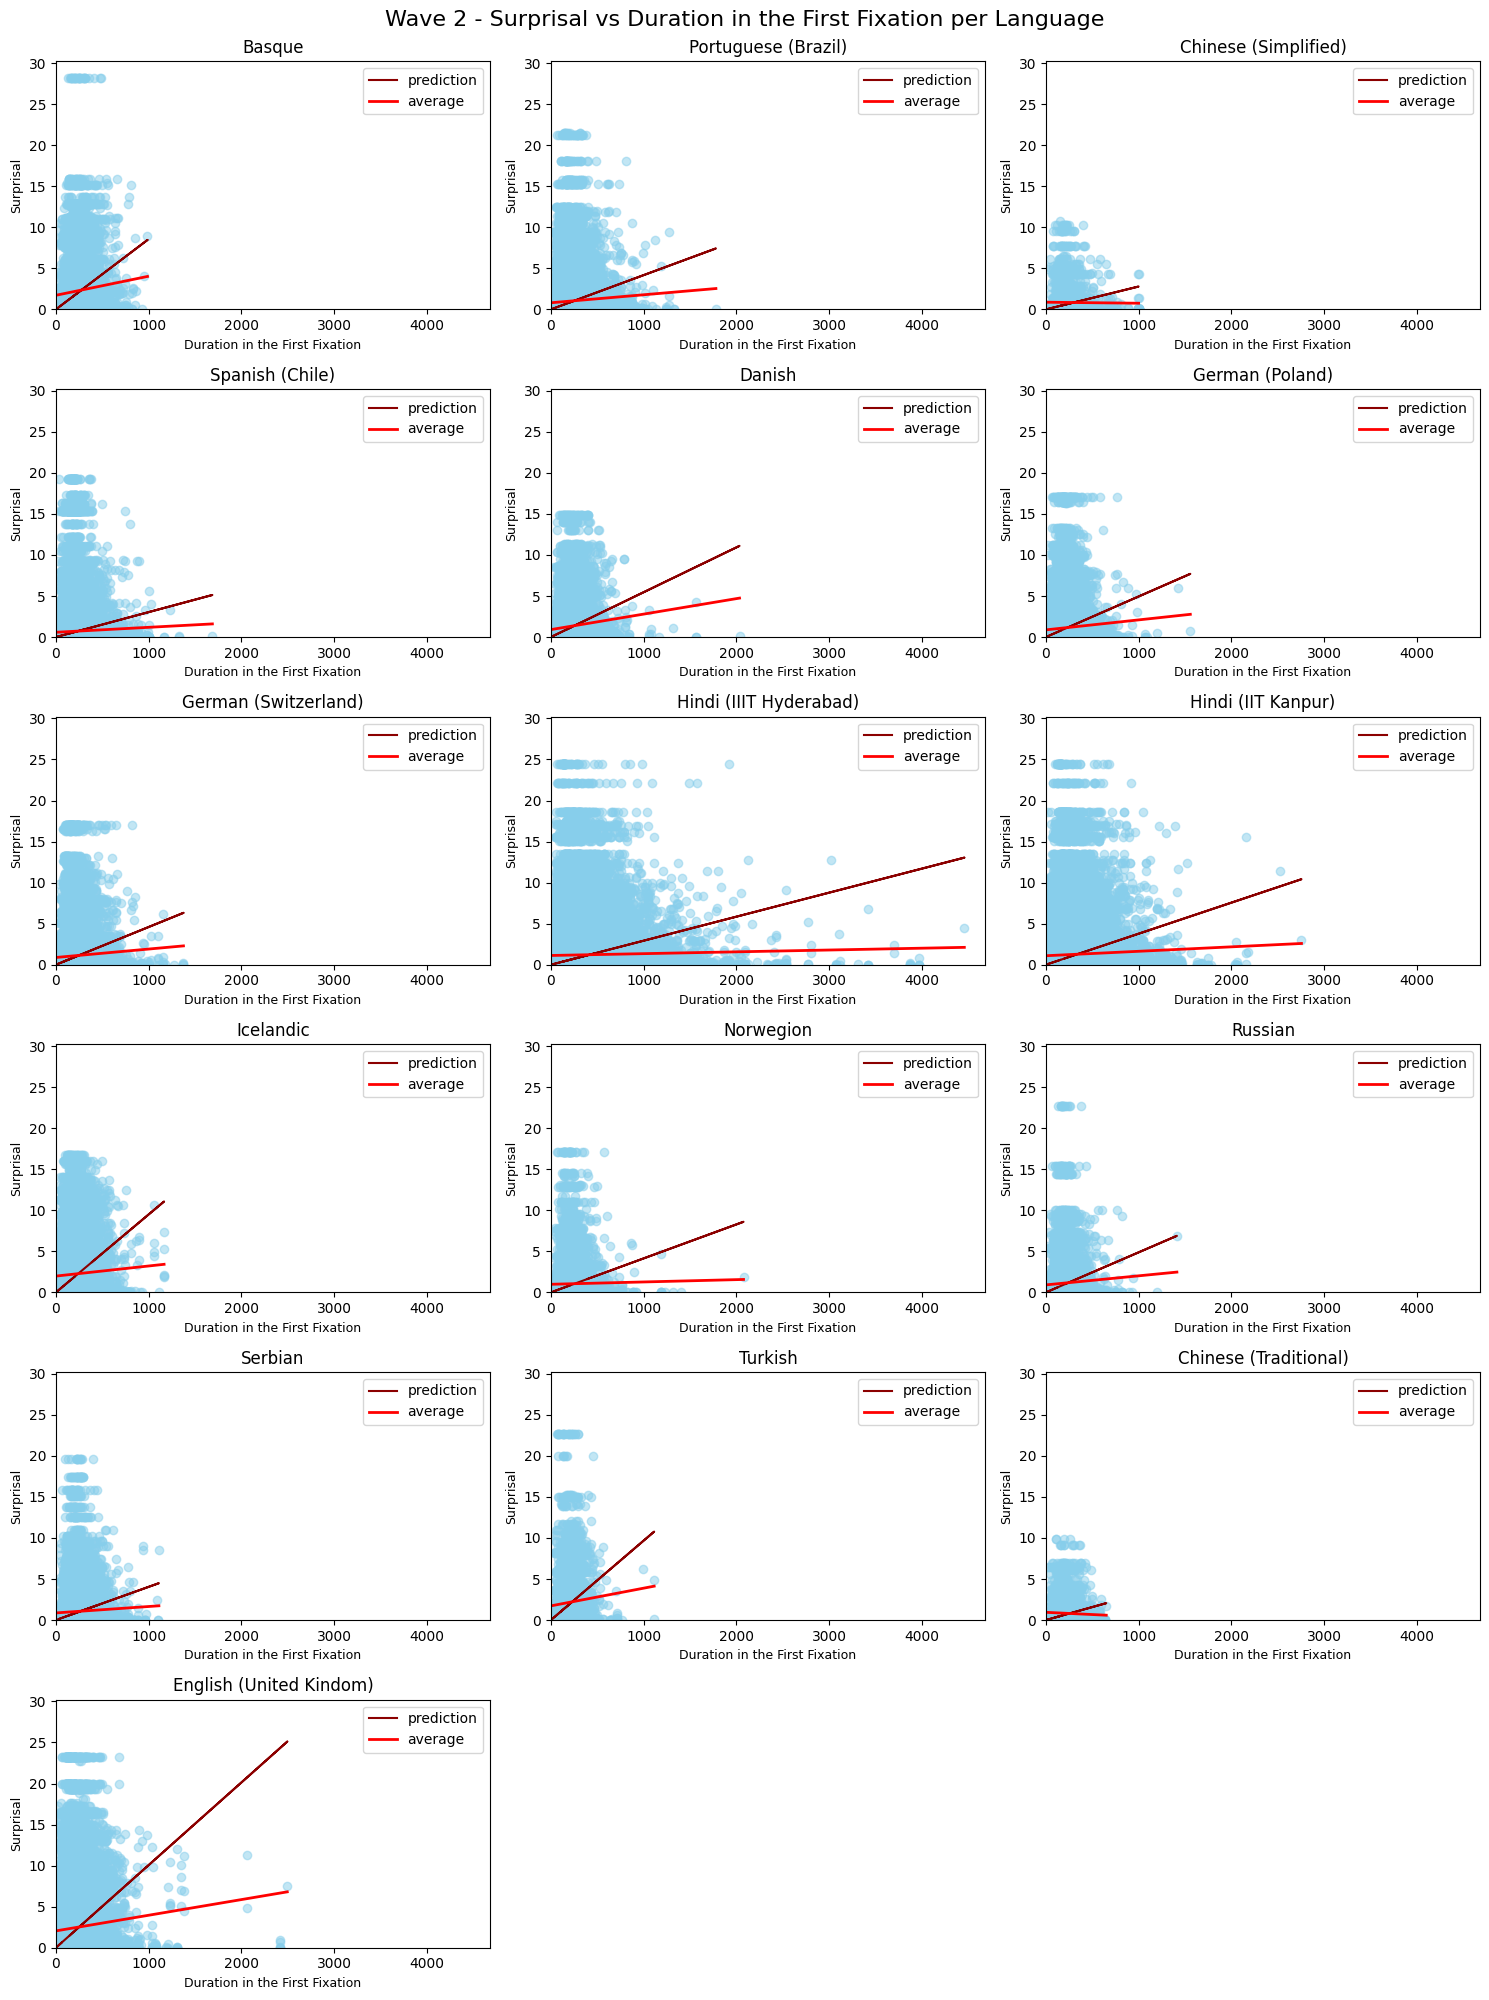

In [ ]:
scatter_plot_per_language(wave2_dict, wave2_languages, languages, wave2_OLS, 'firstfix.dur', 'Duration in the First Fixation', 2)